In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA

import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# read hr_data.csv
hr_data = pd.read_csv('hr_data.csv')

hr_data.head()

Unnamed: 0  HR_TD_Mean  HR_TD_Median  HR_TD_std  HR_TD_Min  HR_TD_Max  \
0           0   78.663878         76.70   7.480043      67.25      92.48   
1           1   76.540732         76.61   2.584756      69.82      82.33   
2           2   78.173563         77.92   2.681255      72.22      82.80   
3           3   83.073688         83.88   7.363598      69.42      96.12   
4           4   72.281250         72.91   3.193762      64.95      79.98   

   HR_TD_AUC  HR_TD_Kurtosis  HR_TD_Skew  HR_TD_Slope_min  ...  upset  \
0  23048.450       -1.091448    0.369955          -0.7300  ...    1.0   
1  23959.920       -0.245338    0.338732          -0.3600  ...    2.0   
2  20324.605       -0.615922   -0.233047          -0.6300  ...    1.0   
3  24924.300       -0.866610   -0.046021          -0.4650  ...    1.0   
4  23052.100        0.200401   -0.560948          -0.3725  ...    3.0   

   hostile  alert  ashamed  inspired  nervous  attentive  afraid  active  \
0      1.0    2.0      1.0       2.0      2.0        3.0     1.0     2.0   
1      1.0    3.0      2.0       2.0      2.0        3.0     1.0     3.0   
2      1.0    2.0      1.0       3.0      2.0        3.0     2.0     3.0   
3      1.0    2.0      1.0       3.0      2.0        3.0     2.0     3.0   
4      1.0    3.0      2.0       3.0      3.0        4.0     2.0     4.0   

   determined  
0         2.0  
1         3.0  
2         3.0  
3         3.0  
4         4.0  

[5 rows x 68 columns]

> change columns 'Frustrated', 'upset', 'hostile', 'alert', 'ashamed', 'inspired', 'nervous','attentive', 'afraid', 'active', 'determined' to categorical

In [3]:
# change columns 'Frustrated', 'upset', 'hostile', 'alert', 'ashamed', 'inspired', 'nervous','attentive', 'afraid', 'active', 'determined' to categorical
hr_data['Frustrated'] = hr_data['Frustrated'].astype('category')
hr_data['upset'] = hr_data['upset'].astype('category')
hr_data['hostile'] = hr_data['hostile'].astype('category')
hr_data['alert'] = hr_data['alert'].astype('category')
hr_data['ashamed'] = hr_data['ashamed'].astype('category')
hr_data['inspired'] = hr_data['inspired'].astype('category')
hr_data['nervous'] = hr_data['nervous'].astype('category')
hr_data['attentive'] = hr_data['attentive'].astype('category')
hr_data['afraid'] = hr_data['afraid'].astype('category')
hr_data['active'] = hr_data['active'].astype('category')
hr_data['determined'] = hr_data['determined'].astype('category')

> fill nan values with the most frequent value with same 'phase', fill nan values with KNN for the columns 'EDA_TD_P_RT', 'EDA_TD_P_ReT' with the same 'phase'

In [4]:
# fill nan values with the most frequent value with same 'phase'
hr_data['inspired'] = hr_data['inspired'].fillna(hr_data.groupby('Phase')['inspired'].transform(lambda x: x.value_counts().idxmax()))
hr_data['attentive'] = hr_data['attentive'].fillna(hr_data.groupby('Phase')['attentive'].transform(lambda x: x.value_counts().idxmax()))
hr_data['afraid'] = hr_data['afraid'].fillna(hr_data.groupby('Phase')['afraid'].transform(lambda x: x.value_counts().idxmax()))
hr_data['active'] = hr_data['active'].fillna(hr_data.groupby('Phase')['active'].transform(lambda x: x.value_counts().idxmax()))
hr_data['determined'] = hr_data['determined'].fillna(hr_data.groupby('Phase')['determined'].transform(lambda x: x.value_counts().idxmax()))

# fill nan values with KNN for the columns 'EDA_TD_P_RT', 'EDA_TD_P_ReT' with the same 'phase'
imputer = KNNImputer(n_neighbors=5, weights='distance')
hr_data['EDA_TD_P_RT'] = imputer.fit_transform(hr_data[['EDA_TD_P_RT']])
hr_data['EDA_TD_P_ReT'] = imputer.fit_transform(hr_data[['EDA_TD_P_ReT']])


# drop unamed:0 column
hr_data = hr_data.drop(['Unnamed: 0'], axis=1)

In [5]:
# one hot encoding for the columns 'Round', 'Phase', 'Cohort'
hr_data_preprocessed = hr_data.drop(columns=['Round', 'Phase', 'Cohort'])

> Split the data and create a new dataset hr_data1 containing only the measurements from the biosensor 

In [6]:
#hr_data1 = hr_data.select_dtypes(include=['float64']) and add column EDA_TD_P_Peaks
hr_data1 = hr_data.select_dtypes(include=['float64'])
hr_data1['EDA_TD_P_Peaks'] = hr_data['EDA_TD_P_Peaks']

> ## Create 4 new datasets. Isolate individual metrics from the biosensor HR, TEMP, EDA_P, EDA_T

In [7]:
featuresHR = hr_data1[['HR_TD_Mean', 'HR_TD_std', 'HR_TD_Min', 'HR_TD_Kurtosis', 'HR_TD_Skew', 
                       'HR_TD_Slope_min', 'HR_TD_Slope_max', 'HR_TD_Slope_mean','HR_TD_Median', 
                       'HR_TD_AUC', 'HR_TD_Max', 'HR_TD_Slope']]

featuresTEMP = hr_data1[['TEMP_TD_Mean', 'TEMP_TD_std', 'TEMP_TD_Min', 'TEMP_TD_Kurtosis', 
                         'TEMP_TD_Skew', 'TEMP_TD_Slope_min', 'TEMP_TD_Slope_max', 'TEMP_TD_Slope_mean',
                         'TEMP_TD_Median', 'TEMP_TD_AUC', 'TEMP_TD_Max', 'TEMP_TD_Slope']]

featuresEDA_P = hr_data1[['EDA_TD_P_Mean', 'EDA_TD_P_std', 'EDA_TD_P_Min', 'EDA_TD_P_Kurtosis', 
                          'EDA_TD_P_Skew', 'EDA_TD_P_Slope_min', 'EDA_TD_P_Slope_max', 'EDA_TD_P_Slope_mean',
                          'EDA_TD_P_Median', 'EDA_TD_P_AUC', 'EDA_TD_P_Max', 'EDA_TD_P_Slope', 'EDA_TD_P_RT', 'EDA_TD_P_ReT', 'EDA_TD_P_Peaks']]

featuresEDA_T = hr_data1[['EDA_TD_T_Mean', 'EDA_TD_T_std', 'EDA_TD_T_Min', 'EDA_TD_T_Kurtosis', 
                          'EDA_TD_T_Skew', 'EDA_TD_T_Slope_min', 'EDA_TD_T_Slope_max', 'EDA_TD_T_Slope_mean',
                          'EDA_TD_T_Median', 'EDA_TD_T_AUC', 'EDA_TD_T_Max', 'EDA_TD_T_Slope']]

We have 5 datasets: hr_data_preprocessed (whole dataset), featuresHR, featuresTEMP, featuresEDA_P, featuresEDA_T

# PCA Analysis for featuresHR, featuresTEMP, featuresEDA_P, featuresEDA_T, hr_data_preprocessed and ICA for hr_data_preprocessed

Number of components for HR features:  4
Explained variance ratio for HR features:  [0.36343769 0.24728804 0.13755483 0.10238596]
Sum of explained variance ratio for HR features:  0.8506665237665714
Number of components for TEMP features:  4
Explained variance ratio for TEMP features:  [0.36010665 0.23664667 0.13748586 0.08600315]
Sum of explained variance ratio for TEMP features:  0.8202423234411752
Number of components for EDA_P features:  3
Explained variance ratio for EDA_P features:  [0.57702897 0.14526974 0.07807617]
Sum of explained variance ratio for EDA_P features:  0.8003748781275364
Number of components for EDA_T features:  3
Explained variance ratio for EDA_T features:  [0.52594144 0.19195309 0.13476627]
Sum of explained variance ratio for EDA_T features:  0.852660794792996
Number of components for All features:  16
Explained variance ratio for All features:  [0.22471783 0.0882205  0.06622892 0.06520346 0.04876173 0.04362549
 0.03904854 0.03672591 0.03211537 0.02991003 0.02

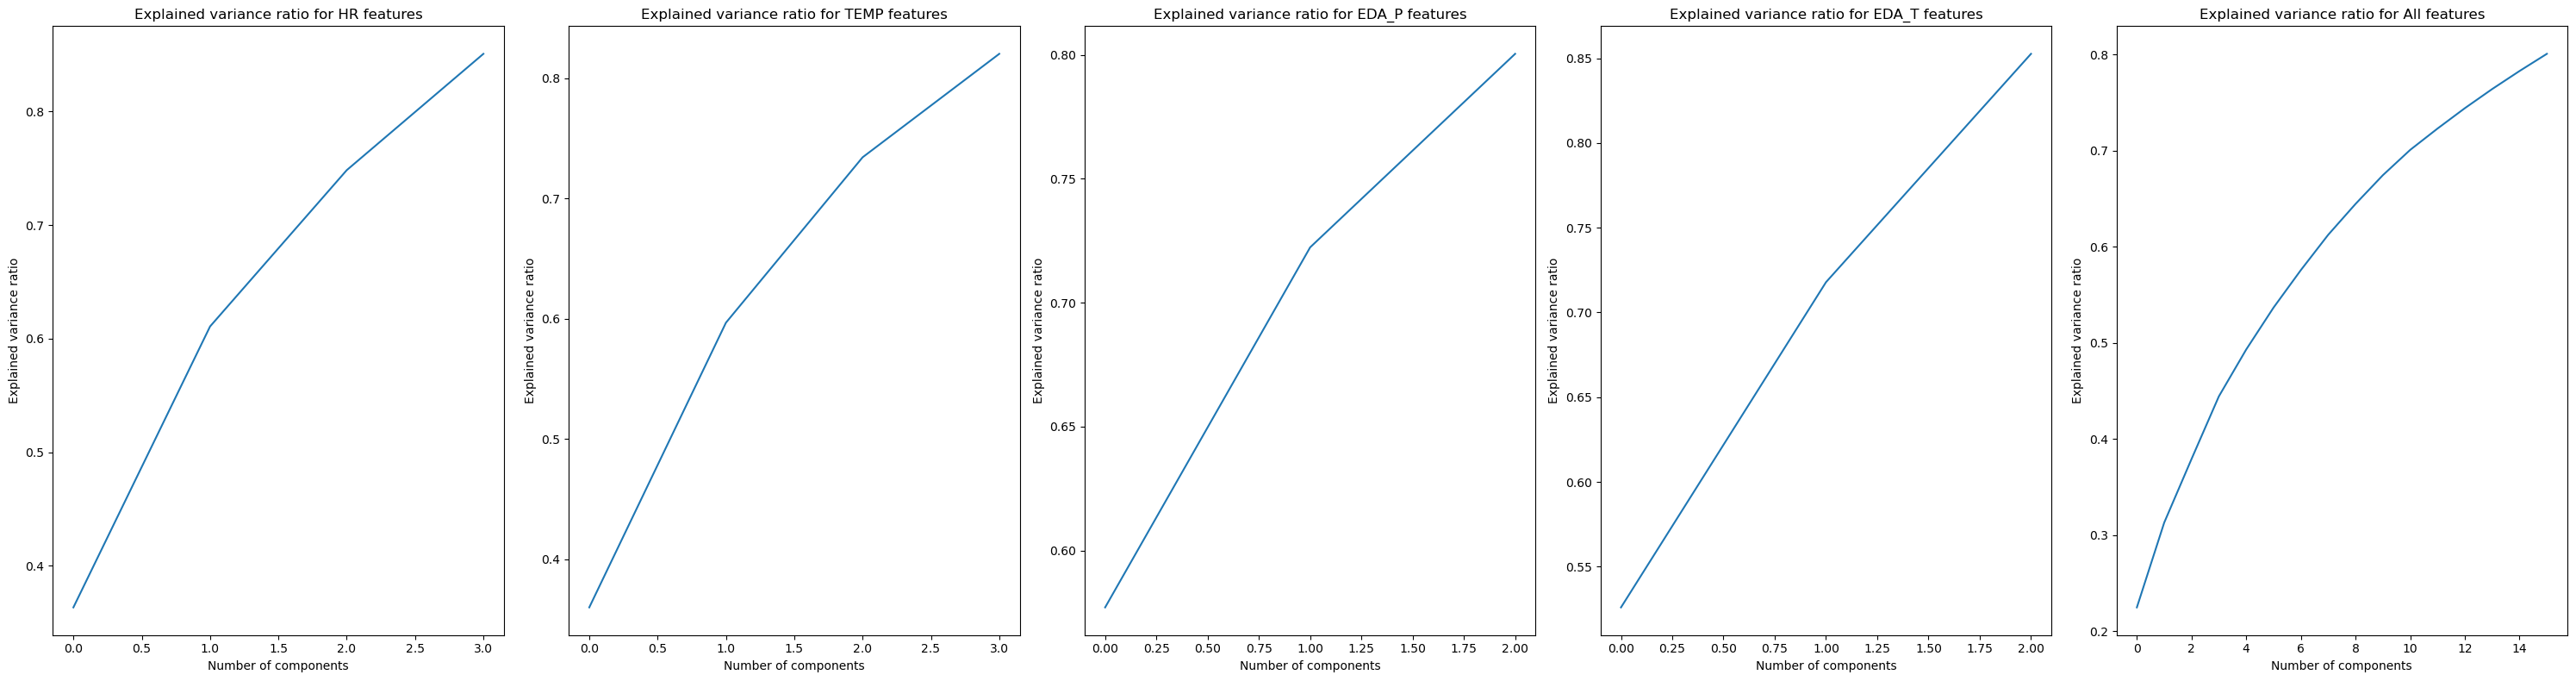

In [8]:
# perform pca on featureHR that explain the 95% variance and plot the explained variance ratio
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
pca = PCA(n_components=0.8)

# Create a figure with a single row of 4 subplots
fig, axs = plt.subplots(1, 5, figsize=(30, 8))

# List of features sets
features_list = [featuresHR, featuresTEMP, featuresEDA_P, featuresEDA_T, hr_data_preprocessed]
titles = ['HR features', 'TEMP features', 'EDA_P features', 'EDA_T features', 'All features']

# Apply PCA and plot for each feature set
for i, features in enumerate(features_list):
    features = scaler.fit_transform(features)
    pca.fit(features)
    transformed_features = pca.transform(features)
    
    if i == 0:
        featuresHR_pca = transformed_features
    if i == 1:
        featuresTEMP_pca = transformed_features
    if i == 2:
        featuresEDA_P_pca = transformed_features
    if i== 3:
        featuresEDA_T_pca = transformed_features
    else:
        hr_data_preprocessed_pca = transformed_features
    
    # Print the results
    print(f"Number of components for {titles[i]}: ", pca.n_components_)
    print(f"Explained variance ratio for {titles[i]}: ", pca.explained_variance_ratio_)
    print(f"Sum of explained variance ratio for {titles[i]}: ", sum(pca.explained_variance_ratio_))
    
    # Plot the explained variance ratio
    axs[i].plot(np.cumsum(pca.explained_variance_ratio_))
    axs[i].set_xlabel('Number of components')
    axs[i].set_ylabel('Explained variance ratio')
    axs[i].set_title(f'Explained variance ratio for {titles[i]}')

plt.tight_layout()
plt.show()

In [9]:
# perform pca on featureHR that explain the 95% variance and plot the explained variance ratio
from sklearn.decomposition import FastICA

scaler = StandardScaler()
ica = FastICA(n_components = 3)

# Create a figure with a single row of 4 subplots
# fig, axs = plt.subplots(1, 5, figsize=(30, 8))

# List of features sets
features_list = [featuresHR, featuresTEMP, featuresEDA_P, featuresEDA_T, hr_data_preprocessed]
titles = ['HR features', 'TEMP features', 'EDA_P features', 'EDA_T features', 'All features']

# Apply PCA and plot for each feature set
for i, features in enumerate(features_list):

    features = scaler.fit_transform(features)
    
    ica.fit(features)
    transformed_features = ica.transform(features)
    
    if i == 0:
        featuresHR_ica = transformed_features
    if i == 1:
        featuresTEMP_ica = transformed_features
    if i == 2:
        featuresEDA_P_ica = transformed_features
    if i== 3:
        featuresEDA_T_ica = transformed_features
    else:
        hr_data_preprocessed_ica = transformed_features
    
    # Print the results
    # print(f"Number of components for {titles[i]}: ", ica.n_features_in_)
    # print(f"Explained variance ratio for {titles[i]}: ", ica.explained_variance_ratio_)
    # print(f"Sum of explained variance ratio for {titles[i]}: ", sum(ica.explained_variance_ratio_))
    
    # # Plot the explained variance ratio
    # axs[i].plot(np.cumsum(ica.explained_variance_ratio_))
    # axs[i].set_xlabel('Number of components')
    # axs[i].set_ylabel('Explained variance ratio')
    # axs[i].set_title(f'Explained variance ratio for {titles[i]}')

# plt.tight_layout()
# plt.show()

# K-means clustering - silhouete coef PCA and ICA

c:\Users\mario\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\mario\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\mario\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\mario\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Window

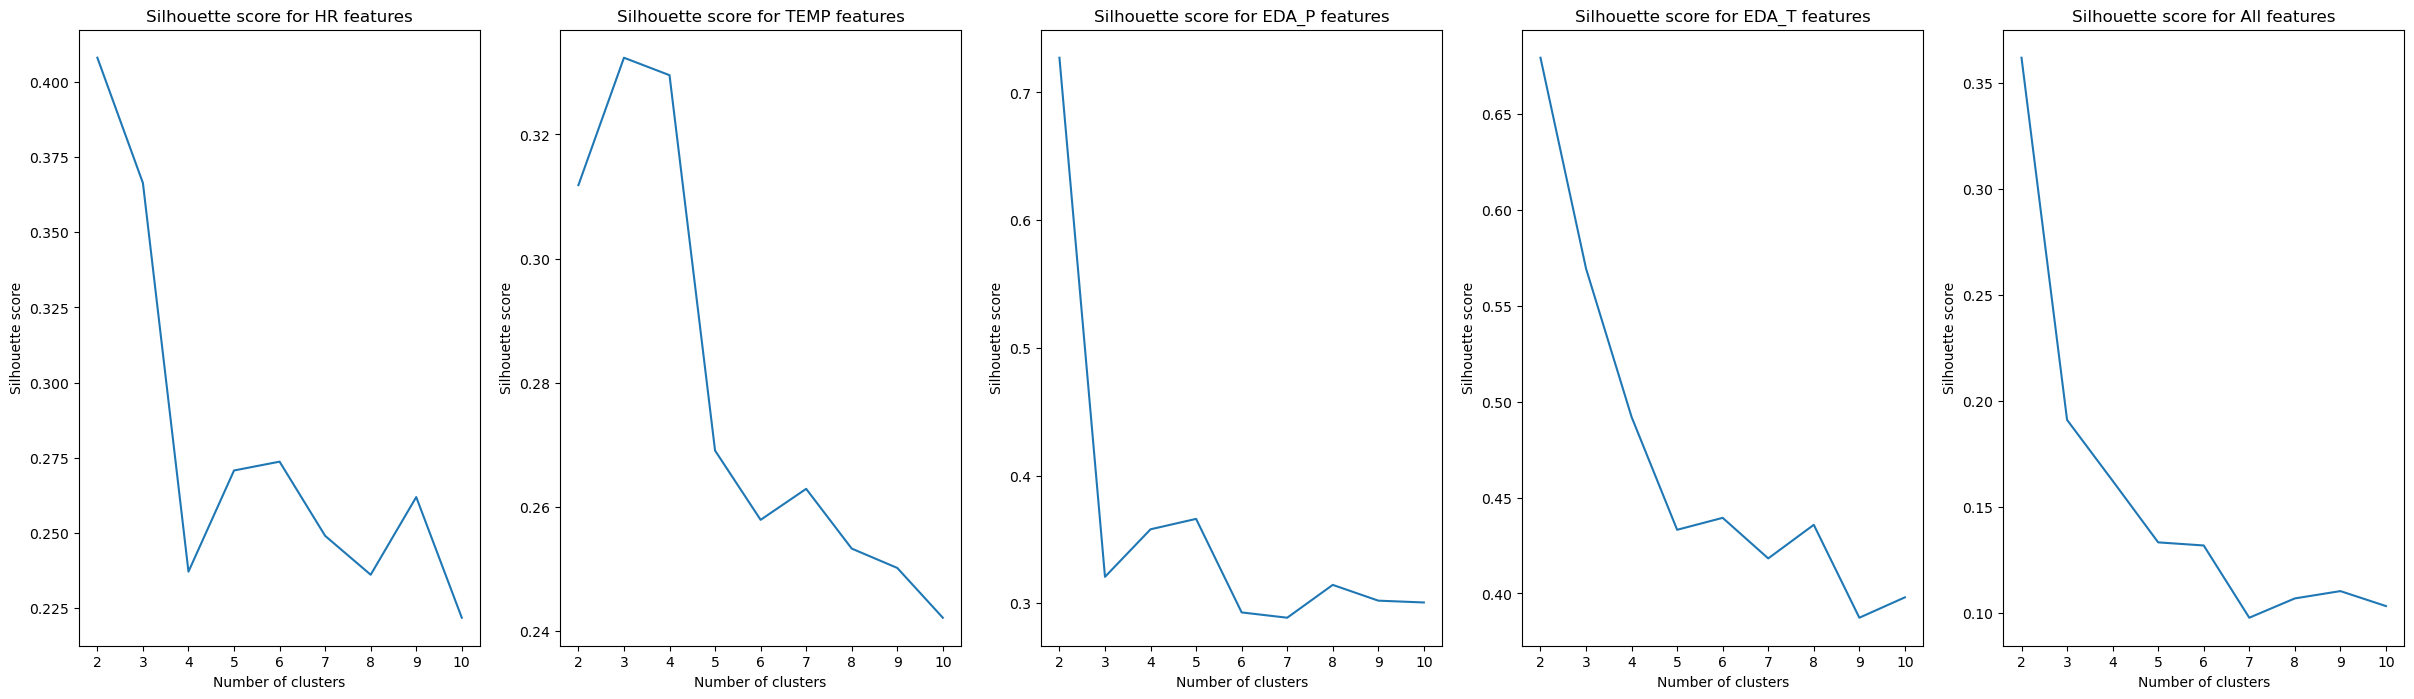

In [10]:
# shilouette score for featuresHR, featuresTEMP, featuresEDA_P, featuresEDA_T, hr_data_preprocessed with 2 to 10 clusters
silhouette_scoresHR = []
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(featuresHR_pca)
    silhouette_scoresHR.append(silhouette_score(featuresHR_pca, kmeans.labels_))

silhouette_scoresTEMP = []
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(featuresTEMP_pca)
    silhouette_scoresTEMP.append(silhouette_score(featuresTEMP_pca, kmeans.labels_))

silhouette_scoresEDA_P = []
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(featuresEDA_P_pca)
    silhouette_scoresEDA_P.append(silhouette_score(featuresEDA_P_pca, kmeans.labels_))

silhouette_scoresEDA_T = []
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(featuresEDA_T_pca)
    silhouette_scoresEDA_T.append(silhouette_score(featuresEDA_T_pca, kmeans.labels_))

silhouette_scoresAll = []
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(hr_data_preprocessed_pca)
    silhouette_scoresAll.append(silhouette_score(hr_data_preprocessed_pca, kmeans.labels_))

# plot the silhouette score for featuresHR, featuresTEMP, featuresEDA_P, featuresEDA_T
fig, ax = plt.subplots(1, 5, figsize=(30, 8))
ax[0].plot(range(2, 11), silhouette_scoresHR)
ax[0].set_xlabel('Number of clusters')
ax[0].set_ylabel('Silhouette score')
ax[0].set_title('Silhouette score for HR features')

ax[1].plot(range(2, 11), silhouette_scoresTEMP)
ax[1].set_xlabel('Number of clusters')
ax[1].set_ylabel('Silhouette score')
ax[1].set_title('Silhouette score for TEMP features')

ax[2].plot(range(2, 11), silhouette_scoresEDA_P)
ax[2].set_xlabel('Number of clusters')
ax[2].set_ylabel('Silhouette score')
ax[2].set_title('Silhouette score for EDA_P features')

ax[3].plot(range(2, 11), silhouette_scoresEDA_T)
ax[3].set_xlabel('Number of clusters')
ax[3].set_ylabel('Silhouette score')
ax[3].set_title('Silhouette score for EDA_T features')

ax[4].plot(range(2, 11), silhouette_scoresAll)
ax[4].set_xlabel('Number of clusters')
ax[4].set_ylabel('Silhouette score')
ax[4].set_title('Silhouette score for All features')
plt.show()

c:\Users\mario\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\mario\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\mario\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\mario\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Window

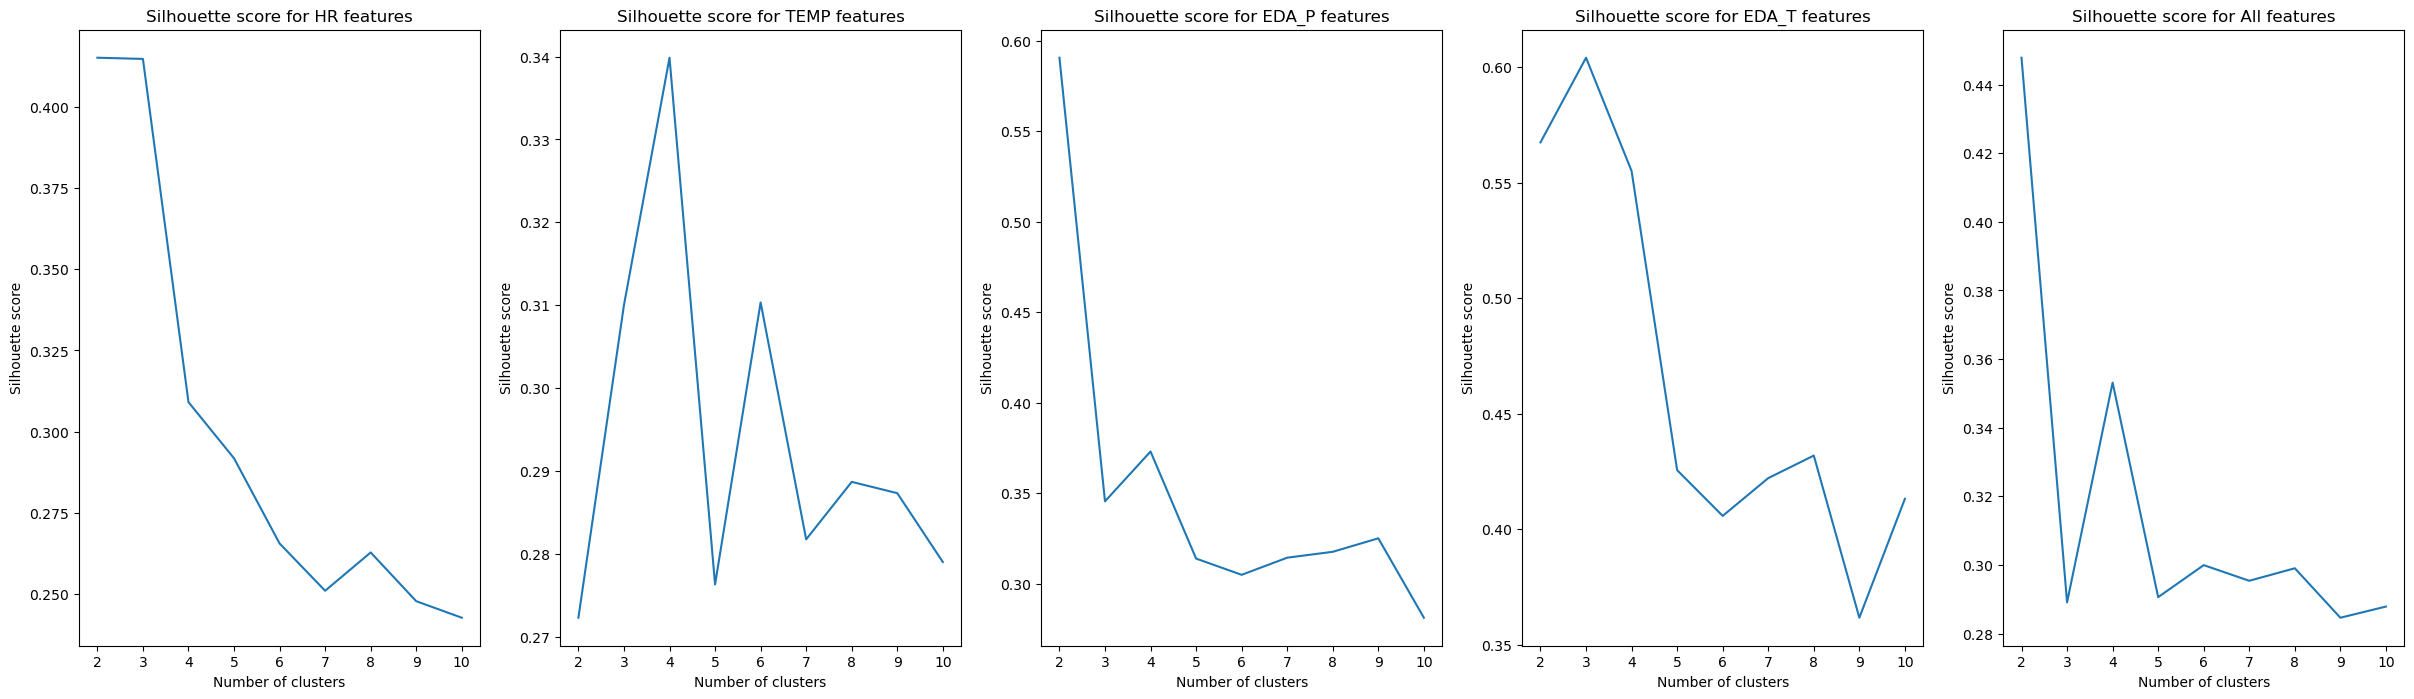

In [11]:
# shilouette score for featuresHR, featuresTEMP, featuresEDA_P, featuresEDA_T, hr_data_preprocessed with 2 to 10 clusters
silhouette_scoresHR = []
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(featuresHR_ica)
    silhouette_scoresHR.append(silhouette_score(featuresHR_ica, kmeans.labels_))

silhouette_scoresTEMP = []
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(featuresTEMP_ica)
    silhouette_scoresTEMP.append(silhouette_score(featuresTEMP_ica, kmeans.labels_))

silhouette_scoresEDA_P = []
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(featuresEDA_P_ica)
    silhouette_scoresEDA_P.append(silhouette_score(featuresEDA_P_ica, kmeans.labels_))

silhouette_scoresEDA_T = []
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(featuresEDA_T_ica)
    silhouette_scoresEDA_T.append(silhouette_score(featuresEDA_T_ica, kmeans.labels_))

silhouette_scoresAll = []
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(hr_data_preprocessed_ica)
    silhouette_scoresAll.append(silhouette_score(hr_data_preprocessed_ica, kmeans.labels_))

# plot the silhouette score for featuresHR, featuresTEMP, featuresEDA_P, featuresEDA_T
fig, ax = plt.subplots(1, 5, figsize=(30, 8))
ax[0].plot(range(2, 11), silhouette_scoresHR)
ax[0].set_xlabel('Number of clusters')
ax[0].set_ylabel('Silhouette score')
ax[0].set_title('Silhouette score for HR features')

ax[1].plot(range(2, 11), silhouette_scoresTEMP)
ax[1].set_xlabel('Number of clusters')
ax[1].set_ylabel('Silhouette score')
ax[1].set_title('Silhouette score for TEMP features')

ax[2].plot(range(2, 11), silhouette_scoresEDA_P)
ax[2].set_xlabel('Number of clusters')
ax[2].set_ylabel('Silhouette score')
ax[2].set_title('Silhouette score for EDA_P features')

ax[3].plot(range(2, 11), silhouette_scoresEDA_T)
ax[3].set_xlabel('Number of clusters')
ax[3].set_ylabel('Silhouette score')
ax[3].set_title('Silhouette score for EDA_T features')

ax[4].plot(range(2, 11), silhouette_scoresAll)
ax[4].set_xlabel('Number of clusters')
ax[4].set_ylabel('Silhouette score')
ax[4].set_title('Silhouette score for All features')
plt.show()

## K-means Clustering PCA

In [12]:
X1 = np.asarray(featuresHR_pca)
X2 = np.asarray(featuresTEMP_pca)
X3 = np.asarray(featuresEDA_P_pca)
X4 = np.asarray(featuresEDA_T_pca)
X5 = np.asarray(hr_data_preprocessed_pca)

> ## featuresHR_pca

c:\Users\mario\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


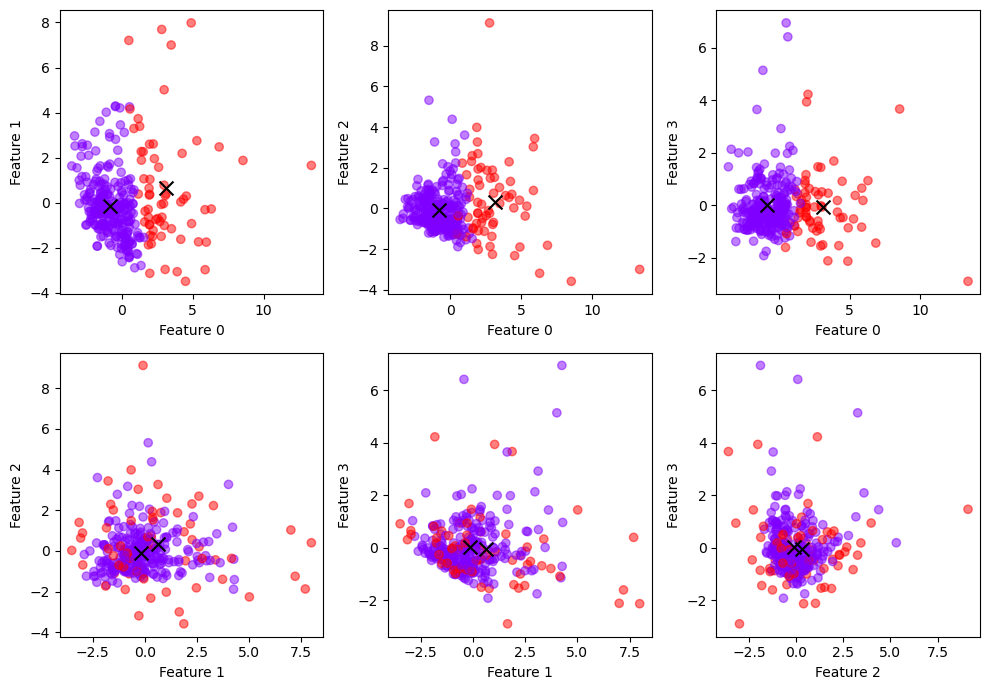

In [13]:
# k means clustering for the optimal number of clusters
kmeans = KMeans(n_clusters=2).fit(X1)
C = kmeans.cluster_centers_ # the cluster centers in the p dimensions
labelCluster = kmeans.labels_ # the labelling for each point

# Number of features in X1
num_features = X1.shape[1]

# Determine the number of rows and columns for the subplots based on the number of features
n_plots = num_features * (num_features - 1) // 2  # Total number of plots needed
n_cols = int(num_features - 1)  # Number of columns (one less than the number of features)
n_rows = int(np.ceil(n_plots / n_cols))  # Number of rows of plots

fig, axs = plt.subplots(n_rows, n_cols, figsize=(10, 7))

# Flatten the array of axes for easy indexing
axs = axs.flatten()

# Counter for the subplot index
plot_number = 0

for i in range(num_features):
    for j in range(i + 1, num_features):
        axs[plot_number].scatter(X1[:, i], X1[:, j], c=labelCluster, cmap='rainbow', alpha=0.5)
        axs[plot_number].scatter(C[:, i], C[:, j], marker='x', color='black', s=100)
        axs[plot_number].set_xlabel(f'Feature {i}')
        axs[plot_number].set_ylabel(f'Feature {j}')
        plot_number += 1

# Hide any unused subplots
for i in range(plot_number, n_rows * n_cols):
    fig.delaxes(axs[i])

plt.tight_layout()
plt.show()

# label clusterHR
hr_data1['ClusterHR_pca'] = labelCluster

> ## featuresTEMP

c:\Users\mario\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


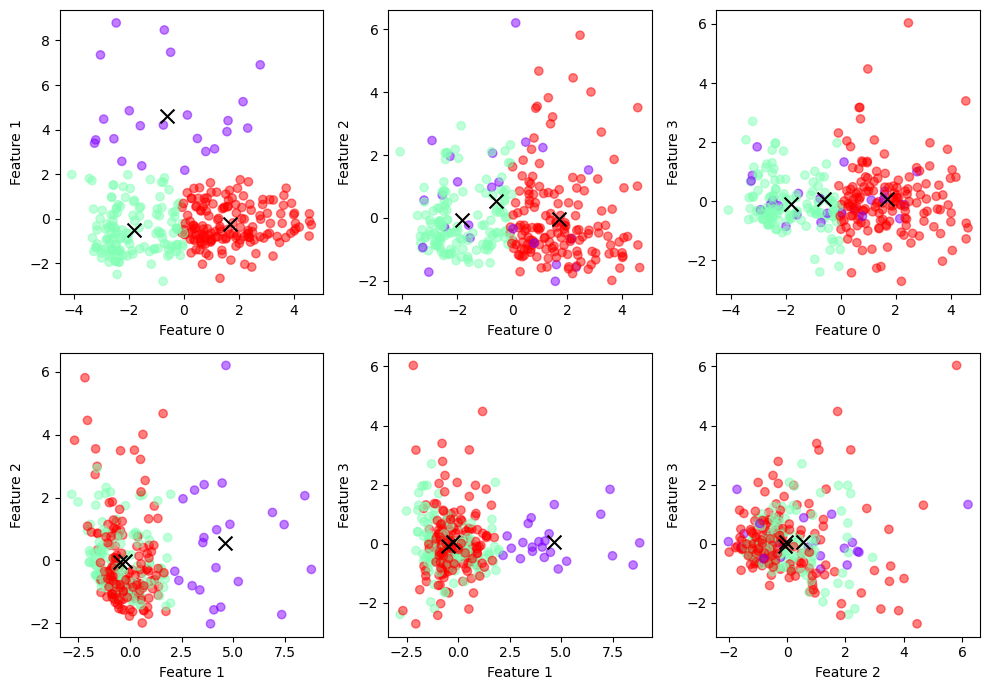

In [14]:
# k means clustering for the optimal number of clusters
kmeans = KMeans(n_clusters=3).fit(X2)
C = kmeans.cluster_centers_ # the cluster centers in the p dimensions
labelCluster = kmeans.labels_ # the labelling for each point

# Number of features in X2
num_features = X2.shape[1]

# Determine the number of rows and columns for the subplots based on the number of features
n_plots = num_features * (num_features - 1) // 2  # Total number of plots needed
n_cols = int(num_features - 1)  # Number of columns (one less than the number of features)
n_rows = int(np.ceil(n_plots / n_cols))  # Number of rows of plots

fig, axs = plt.subplots(n_rows, n_cols, figsize=(10, 7))

# Flatten the array of axes for easy indexing
axs = axs.flatten()

# Counter for the subplot index
plot_number = 0

for i in range(num_features):
    for j in range(i + 1, num_features):
        axs[plot_number].scatter(X2[:, i], X2[:, j], c=labelCluster, cmap='rainbow', alpha=0.5)
        axs[plot_number].scatter(C[:, i], C[:, j], marker='x', color='black', s=100)
        axs[plot_number].set_xlabel(f'Feature {i}')
        axs[plot_number].set_ylabel(f'Feature {j}')
        plot_number += 1

# Hide any unused subplots
for i in range(plot_number, n_rows * n_cols):
    fig.delaxes(axs[i])

plt.tight_layout()
plt.show()

# label clusterTEMP
hr_data1['ClusterTEMP_pca'] = labelCluster


> ## featuresEDA_P

c:\Users\mario\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


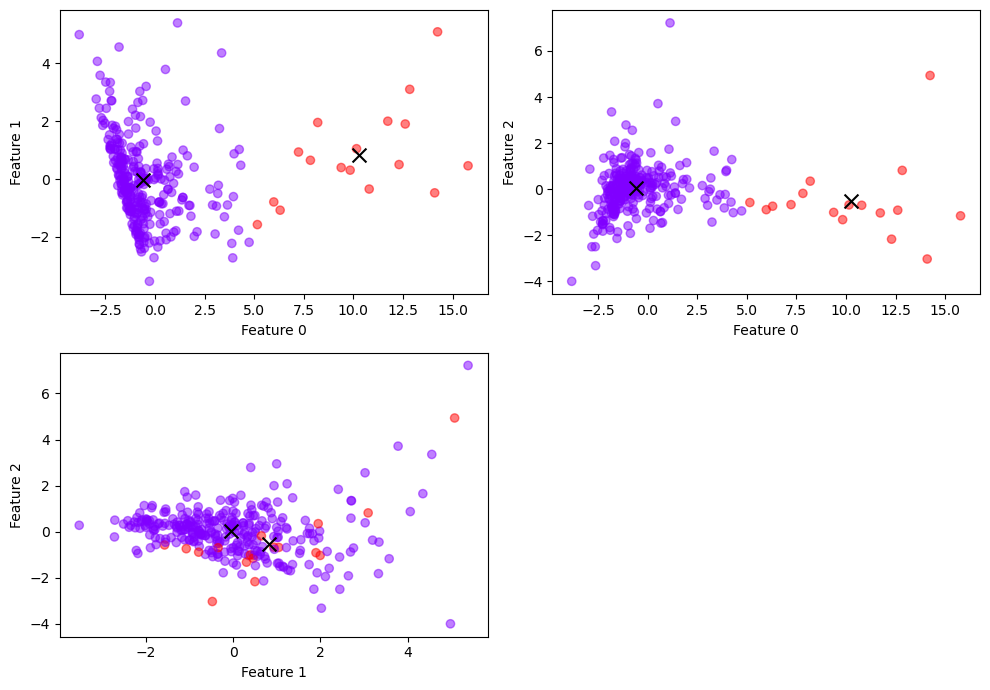

In [15]:
# k means clustering for the optimal number of clusters
kmeans = KMeans(n_clusters=2).fit(X3)
C = kmeans.cluster_centers_ # the cluster centers in the p dimensions
labelCluster = kmeans.labels_ # the labelling for each point

# Number of features in X3
num_features = X3.shape[1]

# Determine the number of rows and columns for the subplots based on the number of features
n_plots = num_features * (num_features - 1) // 2  # Total number of plots needed
n_cols = int(num_features - 1)  # Number of columns (one less than the number of features)
n_rows = int(np.ceil(n_plots / n_cols))  # Number of rows of plots

fig, axs = plt.subplots(n_rows, n_cols, figsize=(10, 7))

# Flatten the array of axes for easy indexing
axs = axs.flatten()

# Counter for the subplot index
plot_number = 0

for i in range(num_features):
    for j in range(i + 1, num_features):
        axs[plot_number].scatter(X3[:, i], X3[:, j], c=labelCluster, cmap='rainbow', alpha=0.5)
        axs[plot_number].scatter(C[:, i], C[:, j], marker='x', color='black', s=100)
        axs[plot_number].set_xlabel(f'Feature {i}')
        axs[plot_number].set_ylabel(f'Feature {j}')
        plot_number += 1

# Hide any unused subplots
for i in range(plot_number, n_rows * n_cols):
    fig.delaxes(axs[i])

plt.tight_layout()
plt.show()

# label clusterEDA_P
hr_data1['ClusterEDA_P_pca'] = labelCluster

> ## featuresEDA_T

c:\Users\mario\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


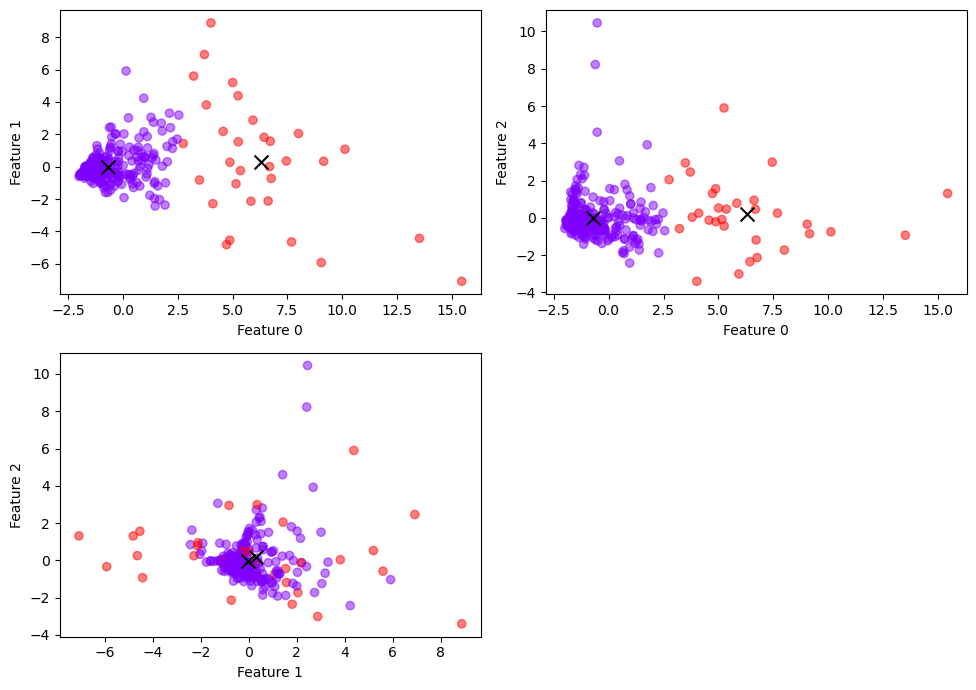

In [16]:
# k means clustering for the optimal number of clusters
kmeans = KMeans(n_clusters=2).fit(X4)
C = kmeans.cluster_centers_ # the cluster centers in the p dimensions
labelCluster = kmeans.labels_ # the labelling for each point

# Number of features in X4
num_features = X4.shape[1]

# Determine the number of rows and columns for the subplots based on the number of features
n_plots = num_features * (num_features - 1) // 2  # Total number of plots needed
n_cols = int(num_features - 1)  # Number of columns (one less than the number of features)
n_rows = int(np.ceil(n_plots / n_cols))  # Number of rows of plots

fig, axs = plt.subplots(n_rows, n_cols, figsize=(10, 7))

# Flatten the array of axes for easy indexing
axs = axs.flatten()

# Counter for the subplot index
plot_number = 0

for i in range(num_features):
    for j in range(i + 1, num_features):
        axs[plot_number].scatter(X4[:, i], X4[:, j], c=labelCluster, cmap='rainbow', alpha=0.5)
        axs[plot_number].scatter(C[:, i], C[:, j], marker='x', color='black', s=100)
        axs[plot_number].set_xlabel(f'Feature {i}')
        axs[plot_number].set_ylabel(f'Feature {j}')
        plot_number += 1

# Hide any unused subplots
for i in range(plot_number, n_rows * n_cols):
    fig.delaxes(axs[i])

plt.tight_layout()
plt.show()

# label clusterEDA_T
hr_data1['ClusterEDA_T_pca'] = labelCluster

> ## hr_data_preprocessed

c:\Users\mario\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\mario\AppData\Local\Temp\ipykernel_21868\2551183851.py:35: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


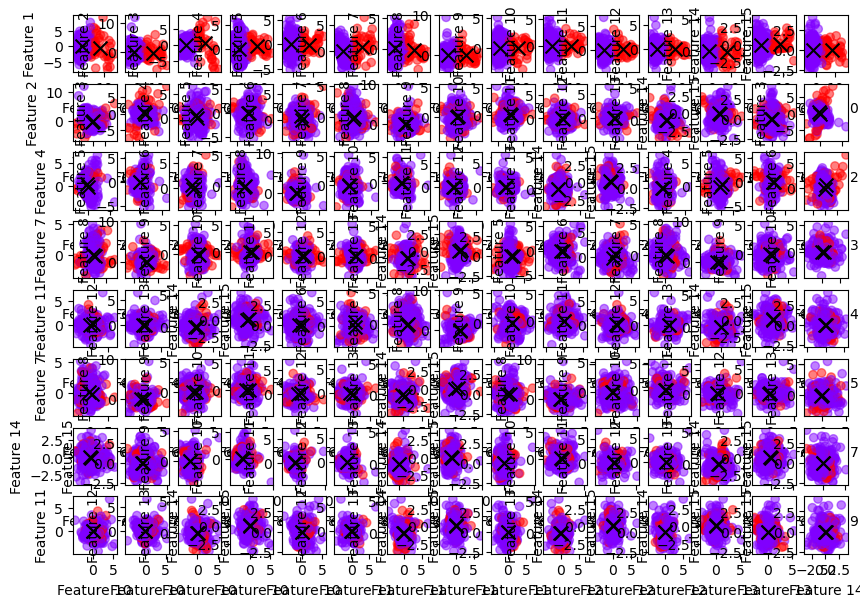

In [17]:

# k means clustering for the optimal number of clusters
kmeans = KMeans(n_clusters=2).fit(X5)
C = kmeans.cluster_centers_ # the cluster centers in the p dimensions

labelCluster = kmeans.labels_ # the labelling for each point

# Number of features in X5
num_features = X5.shape[1]

# Determine the number of rows and columns for the subplots based on the number of features
n_plots = num_features * (num_features - 1) // 2  # Total number of plots needed
n_cols = int(num_features - 1)  # Number of columns (one less than the number of features)
n_rows = int(np.ceil(n_plots / n_cols))  # Number of rows of plots

fig, axs = plt.subplots(n_rows, n_cols, figsize=(10, 7))

# Flatten the array of axes for easy indexing
axs = axs.flatten()

# Counter for the subplot index
plot_number = 0

for i in range(num_features):
    for j in range(i + 1, num_features):
        axs[plot_number].scatter(X5[:, i], X5[:, j], c=labelCluster, cmap='rainbow', alpha=0.5)
        axs[plot_number].scatter(C[:, i], C[:, j], marker='x', color='black', s=100)
        axs[plot_number].set_xlabel(f'Feature {i}')
        axs[plot_number].set_ylabel(f'Feature {j}')
        plot_number += 1

# Hide any unused subplots
for i in range(plot_number, n_rows * n_cols):
    fig.delaxes(axs[i])

plt.tight_layout()
plt.show()

# label clusterAll
hr_data1['ClusterAll_pca'] = labelCluster

# hierarchical PCA

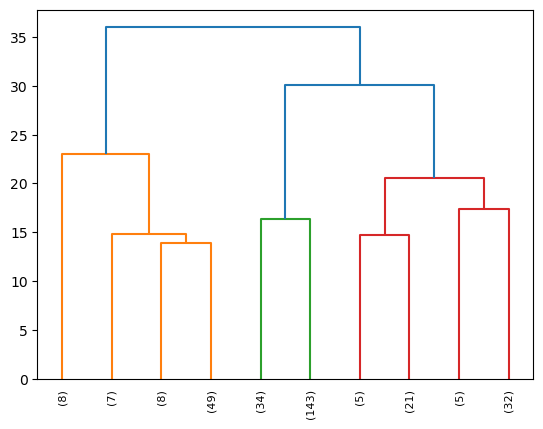

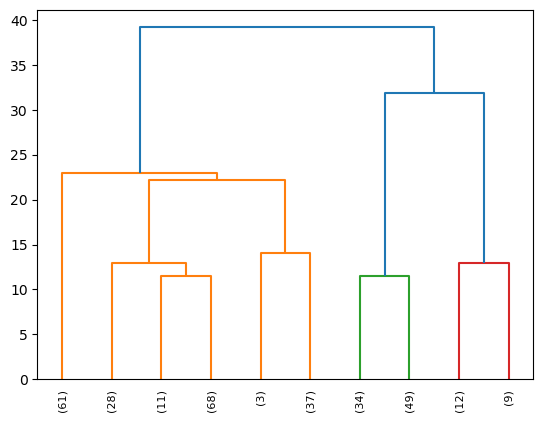

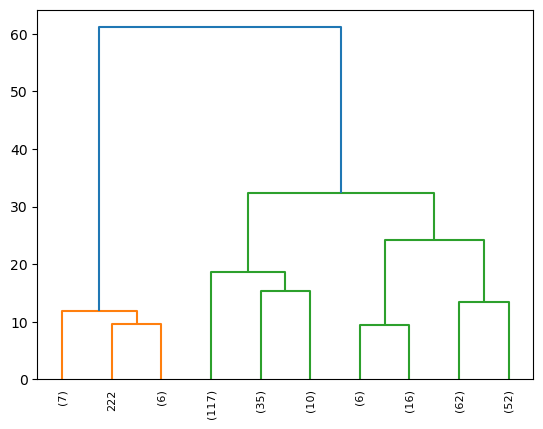

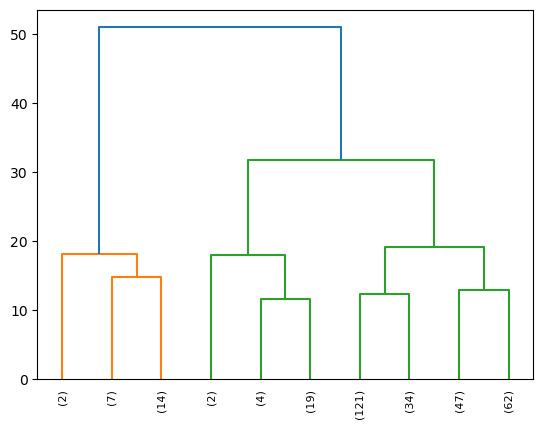

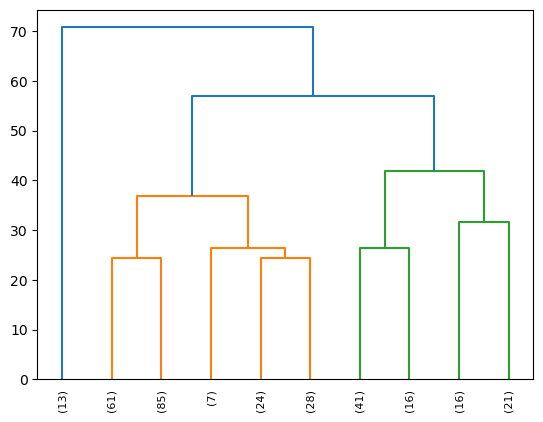

In [18]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

d_sample = 'euclidean' 
d_group = 'ward' 
N_leafs = 10 

Z1 = linkage(X1, method=d_group, metric=d_sample) #method denotes cluster distance, metric denotes sample distance

den = dendrogram(
    Z1,
    leaf_rotation=90.,
    leaf_font_size=8.,
    truncate_mode='lastp',
    p = N_leafs,
)
plt.show()

Z2 = linkage(X2, method=d_group, metric=d_sample) #method denotes cluster distance, metric denotes sample distance

den = dendrogram(
    Z2,
    leaf_rotation=90.,
    leaf_font_size=8.,
    truncate_mode='lastp',
    p = N_leafs,
)

plt.show()

Z3 = linkage(X3, method=d_group, metric=d_sample) #method denotes cluster distance, metric denotes sample distance

den = dendrogram(
    Z3,
    leaf_rotation=90.,
    leaf_font_size=8.,
    truncate_mode='lastp',
    p = N_leafs,
)

plt.show()

Z4 = linkage(X4, method=d_group, metric=d_sample) #method denotes cluster distance, metric denotes sample distance

den = dendrogram(
    Z4,
    leaf_rotation=90.,
    leaf_font_size=8.,
    truncate_mode='lastp',
    p = N_leafs,
)

plt.show()

Z5 = linkage(X5, method=d_group, metric=d_sample) #method denotes cluster distance, metric denotes sample distance

den = dendrogram(
    Z5,
    leaf_rotation=90.,
    leaf_font_size=8.,
    truncate_mode='lastp',
    p = N_leafs,
)

plt.show()



# plot the silhouette score for featuresHR, featuresTEMP, featuresEDA_P, featuresEDA_T
# fig, ax = plt.subplots(1, 5, figsize=(30, 8))


In [19]:
#look at the individual clusters
k1= 3#Number of clusters. Determine a usable number from dendrogram
k2=3
k3=2
k4=2
k5=2

cluster_designation1 = fcluster(Z1, k1, criterion='maxclust') #Get cluster designation of data points
cluster_designation2= fcluster(Z2, k2, criterion='maxclust') #Get cluster designation of data points
cluster_designation3 = fcluster(Z3, k3, criterion='maxclust') #Get cluster designation of data points
cluster_designation4 = fcluster(Z4, k4, criterion='maxclust') #Get cluster designation of data points
cluster_designation5 = fcluster(Z5, k5, criterion='maxclust') #Get cluster designation of data points

hr_data1['ClusterAll_pca_hc'] = cluster_designation5
hr_data1['ClusterTEMP_pca_hc'] = cluster_designation2
hr_data1['ClusterEDA_P_pca_hc'] = cluster_designation3
hr_data1['ClusterEDA_T_pca_hc'] = cluster_designation4
hr_data1['ClusterHR_pca_hc'] = cluster_designation1

# GMM Clustering PCA

c:\Users\mario\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\mario\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\mario\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


c:\Users\mario\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\mario\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\mario\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\mario\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Window

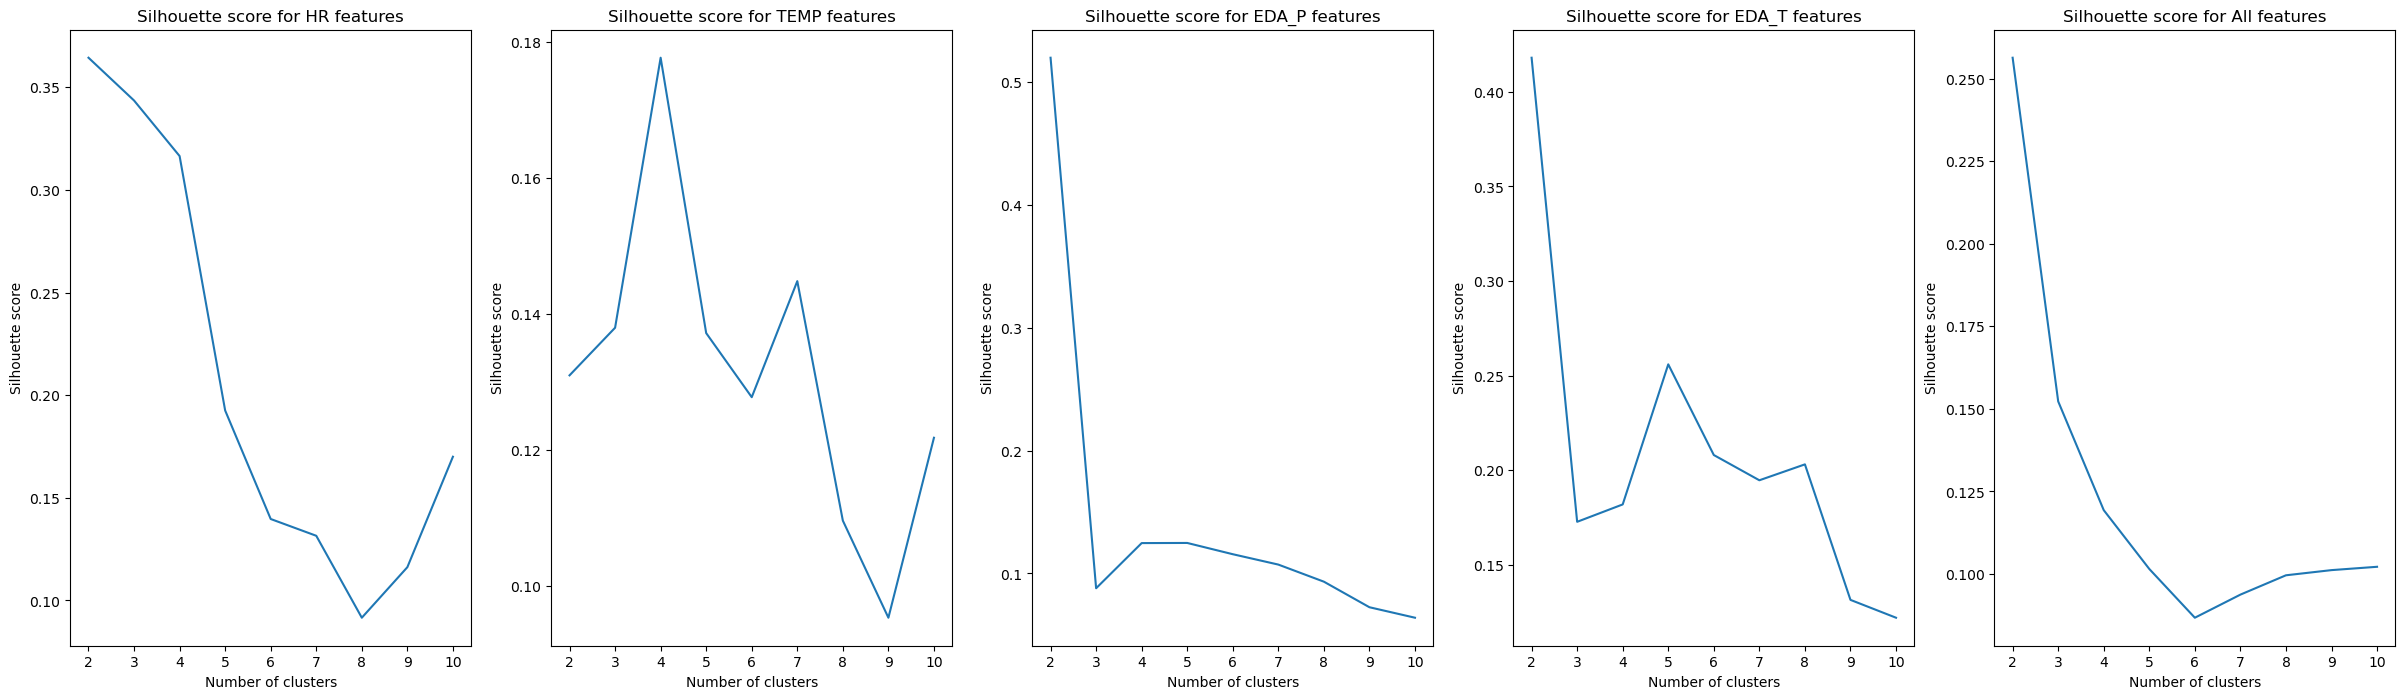

In [20]:
from sklearn.mixture import GaussianMixture


# shilouette score for featuresHR, featuresTEMP, featuresEDA_P, featuresEDA_T, hr_data_preprocessed with 2 to 10 clusters
silhouette_scoresHR = []
for i in range(2, 11):
    kmeans = GaussianMixture(n_components=i, random_state=0)
    kmeans.fit(featuresHR_pca)
    silhouette_scoresHR.append(silhouette_score(featuresHR_pca, kmeans.predict(featuresHR_pca)))

silhouette_scoresTEMP = []
for i in range(2, 11):
    kmeans = GaussianMixture(n_components=i, random_state=0)
    kmeans.fit(featuresTEMP_pca)
    silhouette_scoresTEMP.append(silhouette_score(featuresTEMP_pca, kmeans.predict(featuresTEMP_pca)))

silhouette_scoresEDA_P = []
for i in range(2, 11):
    kmeans = GaussianMixture(n_components=i, random_state=0)
    kmeans.fit(featuresEDA_P_pca)
    silhouette_scoresEDA_P.append(silhouette_score(featuresEDA_P_pca, kmeans.predict(featuresEDA_P_pca)))

silhouette_scoresEDA_T = []
for i in range(2, 11):
    kmeans = GaussianMixture(n_components=i, random_state=0)
    kmeans.fit(featuresEDA_T_pca)
    silhouette_scoresEDA_T.append(silhouette_score(featuresEDA_T_pca, kmeans.predict(featuresEDA_T_pca)))

silhouette_scoresAll = []
for i in range(2, 11):
    kmeans = GaussianMixture(n_components=i, random_state=0)
    kmeans.fit(hr_data_preprocessed_pca)
    silhouette_scoresAll.append(silhouette_score(hr_data_preprocessed_pca, kmeans.predict(hr_data_preprocessed_pca)))

# plot the silhouette score for featuresHR, featuresTEMP, featuresEDA_P, featuresEDA_T
fig, ax = plt.subplots(1, 5, figsize=(30, 8))
ax[0].plot(range(2, 11), silhouette_scoresHR)
ax[0].set_xlabel('Number of clusters')
ax[0].set_ylabel('Silhouette score')
ax[0].set_title('Silhouette score for HR features')

ax[1].plot(range(2, 11), silhouette_scoresTEMP)
ax[1].set_xlabel('Number of clusters')
ax[1].set_ylabel('Silhouette score')
ax[1].set_title('Silhouette score for TEMP features')

ax[2].plot(range(2, 11), silhouette_scoresEDA_P)
ax[2].set_xlabel('Number of clusters')
ax[2].set_ylabel('Silhouette score')
ax[2].set_title('Silhouette score for EDA_P features')

ax[3].plot(range(2, 11), silhouette_scoresEDA_T)
ax[3].set_xlabel('Number of clusters')
ax[3].set_ylabel('Silhouette score')
ax[3].set_title('Silhouette score for EDA_T features')

ax[4].plot(range(2, 11), silhouette_scoresAll)
ax[4].set_xlabel('Number of clusters')
ax[4].set_ylabel('Silhouette score')
ax[4].set_title('Silhouette score for All features')
plt.show()

> ## featuresHR_pca

c:\Users\mario\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


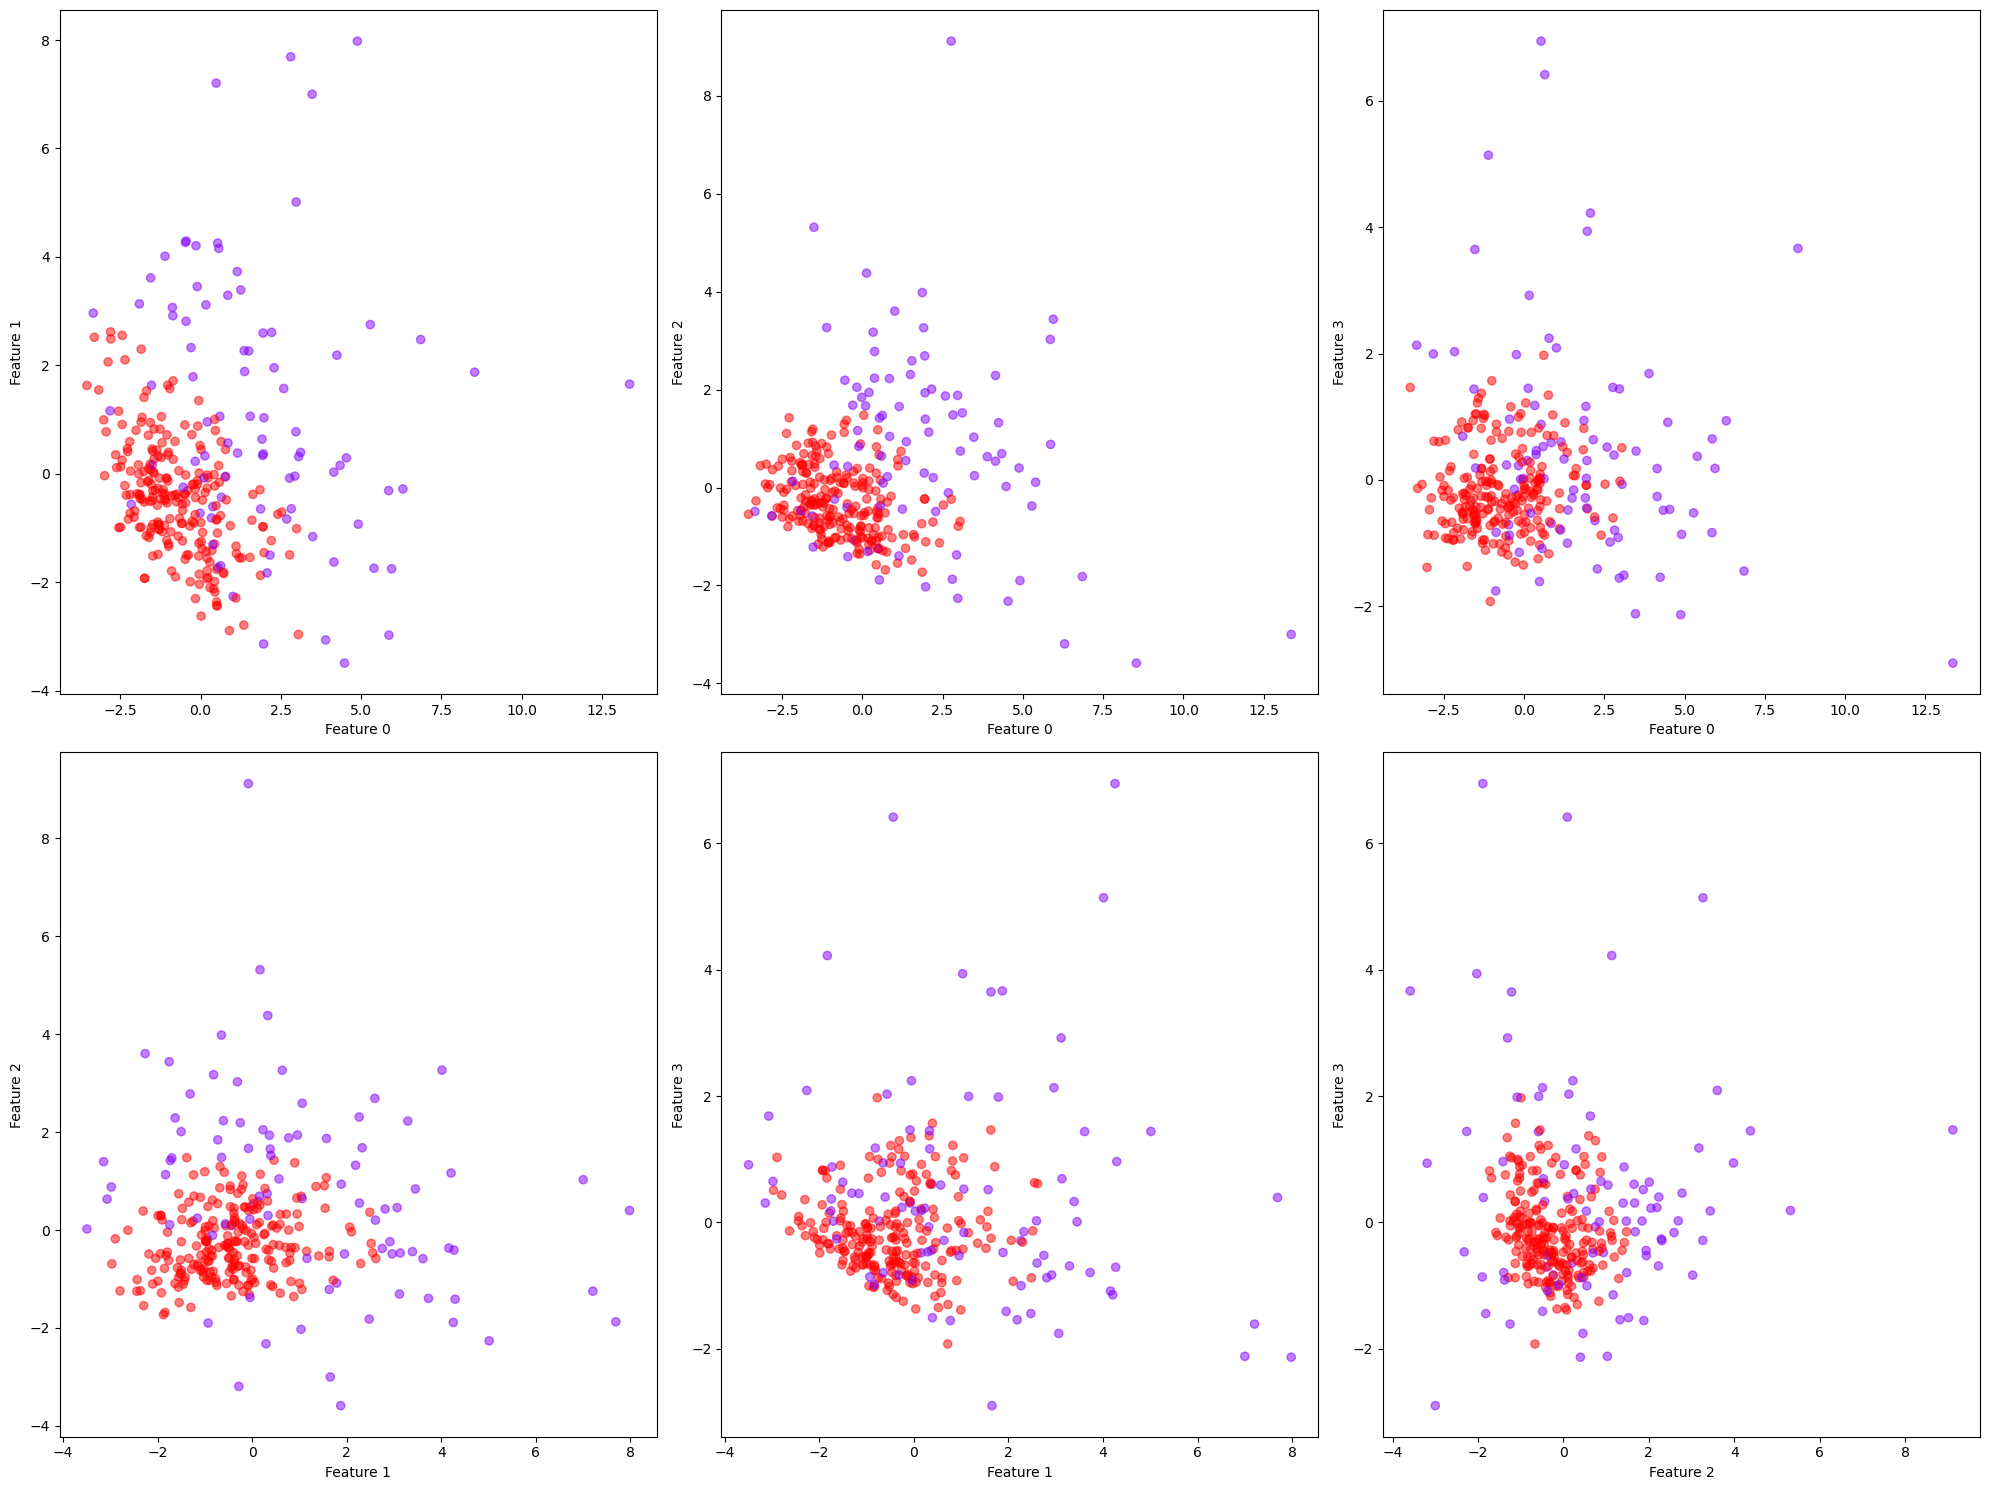

In [21]:
# k means clustering for the optimal number of clusters
kmeans = GaussianMixture(n_components=2).fit(X1)
# C = kmeans.cluster_centers_ # the cluster centers in the p dimensions
labelCluster = kmeans.predict(X1) # the labelling for each point

# Number of features in X1
num_features = X1.shape[1]

# Determine the number of rows and columns for the subplots based on the number of features
n_plots = num_features * (num_features - 1) // 2  # Total number of plots needed
n_cols = int(num_features - 1)  # Number of columns (one less than the number of features)
n_rows = int(np.ceil(n_plots / n_cols))  # Number of rows of plots

fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, 15))

# Flatten the array of axes for easy indexing
axs = axs.flatten()

# Counter for the subplot index
plot_number = 0

for i in range(num_features):
    for j in range(i + 1, num_features):
        axs[plot_number].scatter(X1[:, i], X1[:, j], c=labelCluster, cmap='rainbow', alpha=0.5)
        # axs[plot_number].scatter(C[:, i], C[:, j], marker='x', color='black', s=100)
        axs[plot_number].set_xlabel(f'Feature {i}')
        axs[plot_number].set_ylabel(f'Feature {j}')
        plot_number += 1

# Hide any unused subplots
for i in range(plot_number, n_rows * n_cols):
    fig.delaxes(axs[i])

plt.tight_layout()
plt.show()

# label clusterHR
hr_data1['ClusterHR_pca_GMM'] = labelCluster

> ## featuresTEMP

c:\Users\mario\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


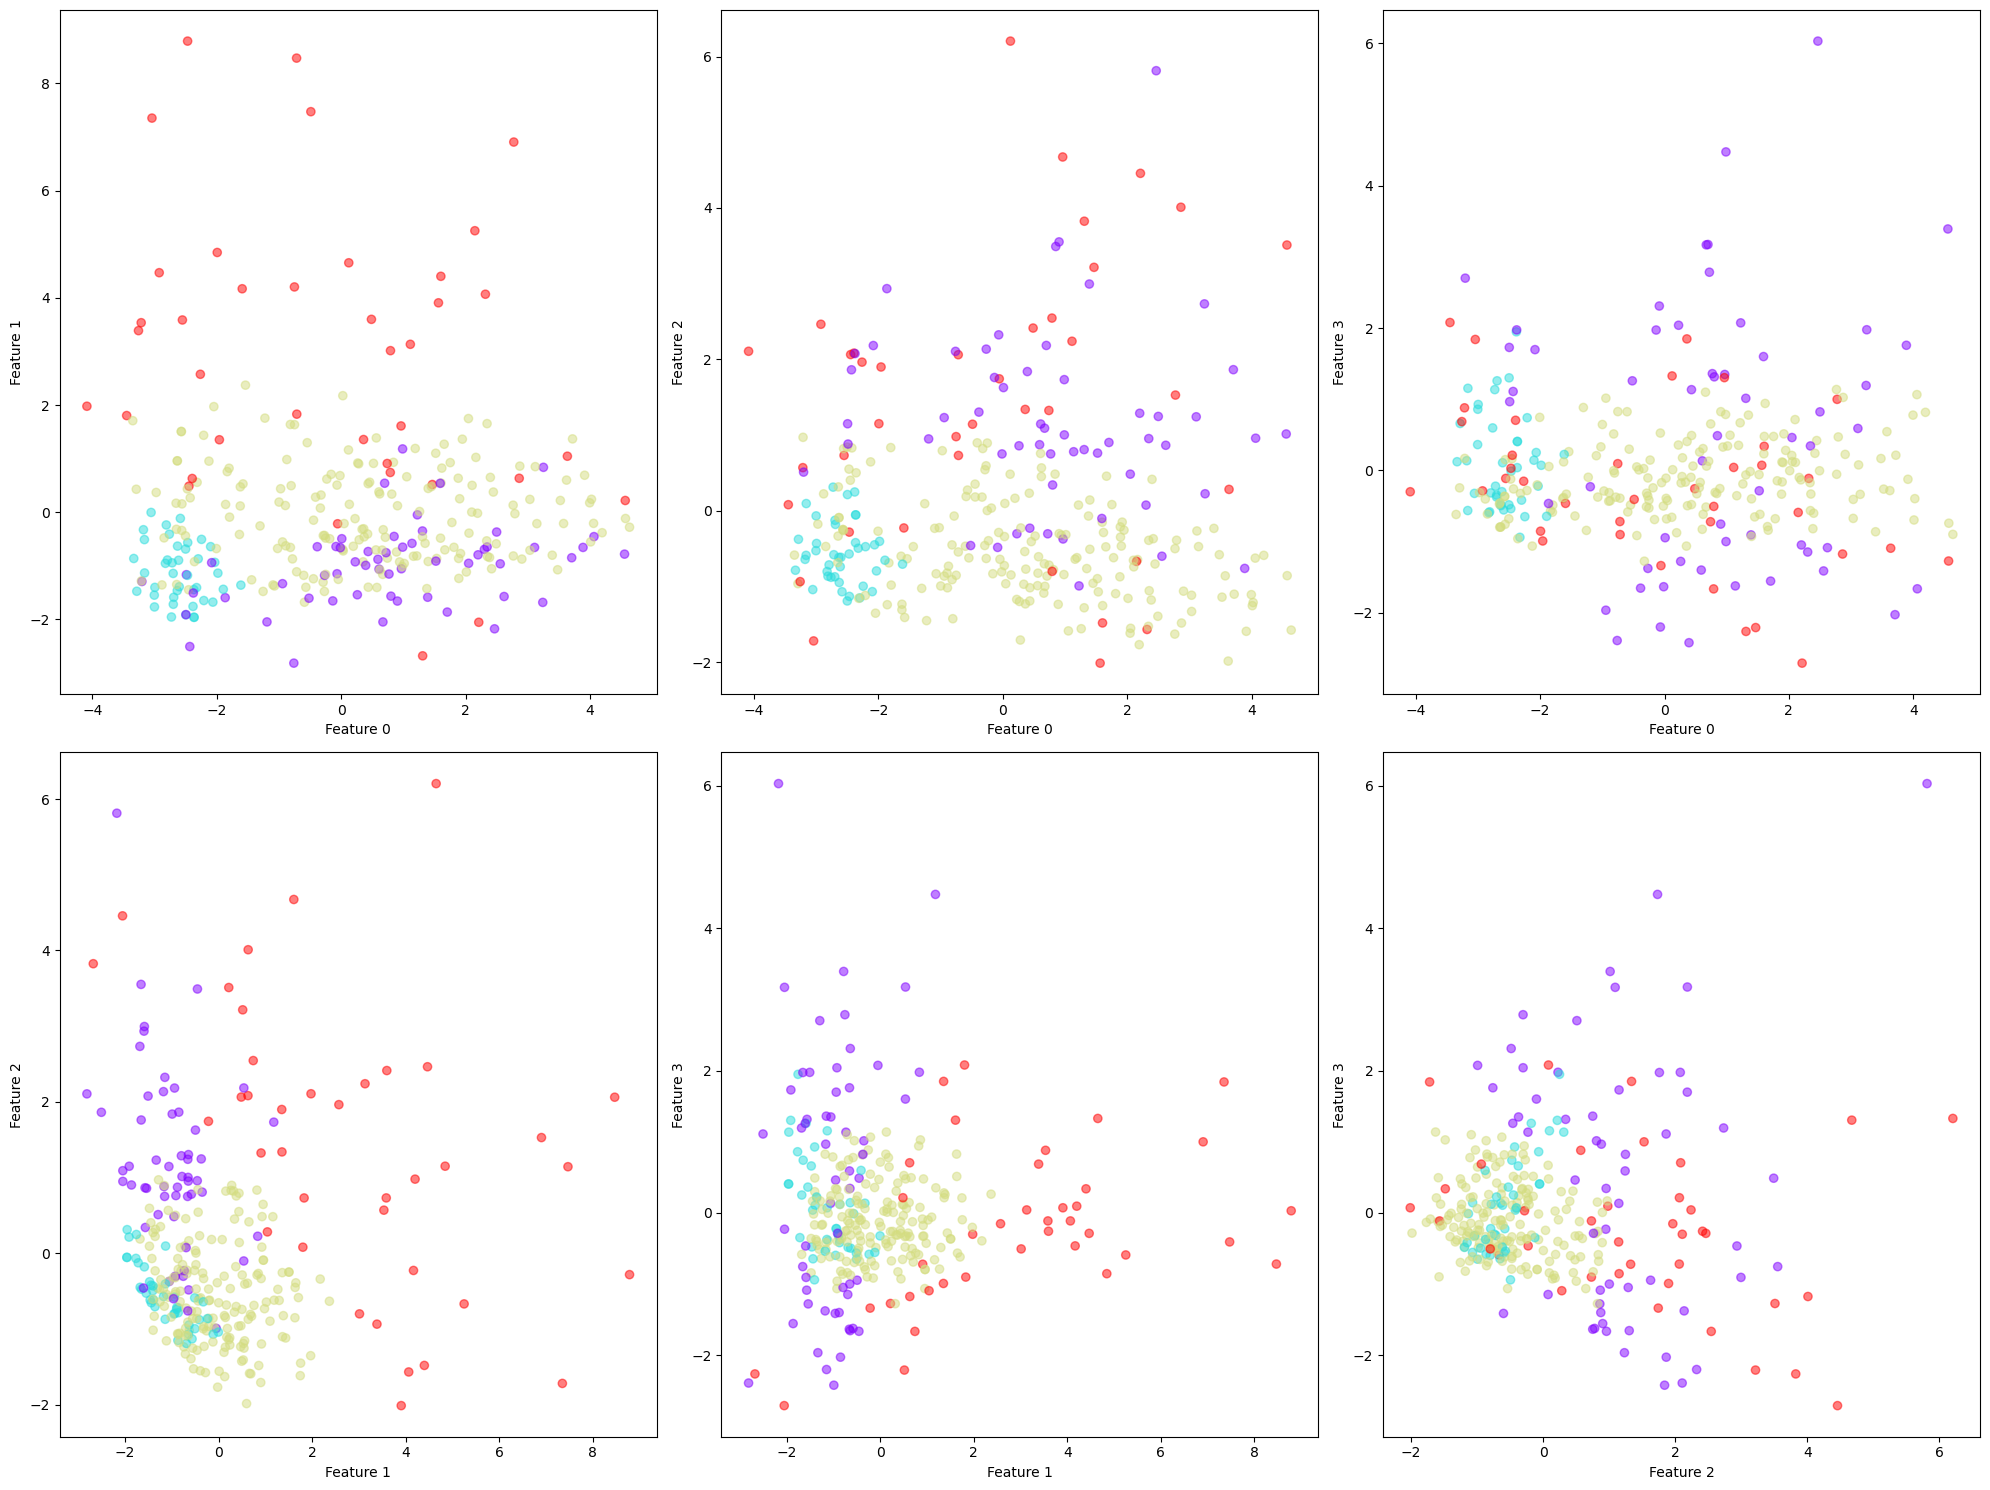

In [22]:
# k means clustering for the optimal number of clusters
kmeans = GaussianMixture(n_components=4).fit(X2)
# C = kmeans.cluster_centers_ # the cluster centers in the p dimensions
labelCluster = kmeans.predict(X2) # the labelling for each point

# Number of features in X2
num_features = X2.shape[1]

# Determine the number of rows and columns for the subplots based on the number of features
n_plots = num_features * (num_features - 1) // 2  # Total number of plots needed
n_cols = int(num_features - 1)  # Number of columns (one less than the number of features)
n_rows = int(np.ceil(n_plots / n_cols))  # Number of rows of plots

fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, 15))

# Flatten the array of axes for easy indexing
axs = axs.flatten()

# Counter for the subplot index
plot_number = 0

for i in range(num_features):
    for j in range(i + 1, num_features):
        axs[plot_number].scatter(X2[:, i], X2[:, j], c=labelCluster, cmap='rainbow', alpha=0.5)
        # axs[plot_number].scatter(C[:, i], C[:, j], marker='x', color='black', s=100)
        axs[plot_number].set_xlabel(f'Feature {i}')
        axs[plot_number].set_ylabel(f'Feature {j}')
        plot_number += 1

# Hide any unused subplots
for i in range(plot_number, n_rows * n_cols):
    fig.delaxes(axs[i])

plt.tight_layout()
plt.show()

# label clusterTEMP
hr_data1['ClusterTEMP_pca_GMM'] = labelCluster


> ## featuresEDA_P

c:\Users\mario\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


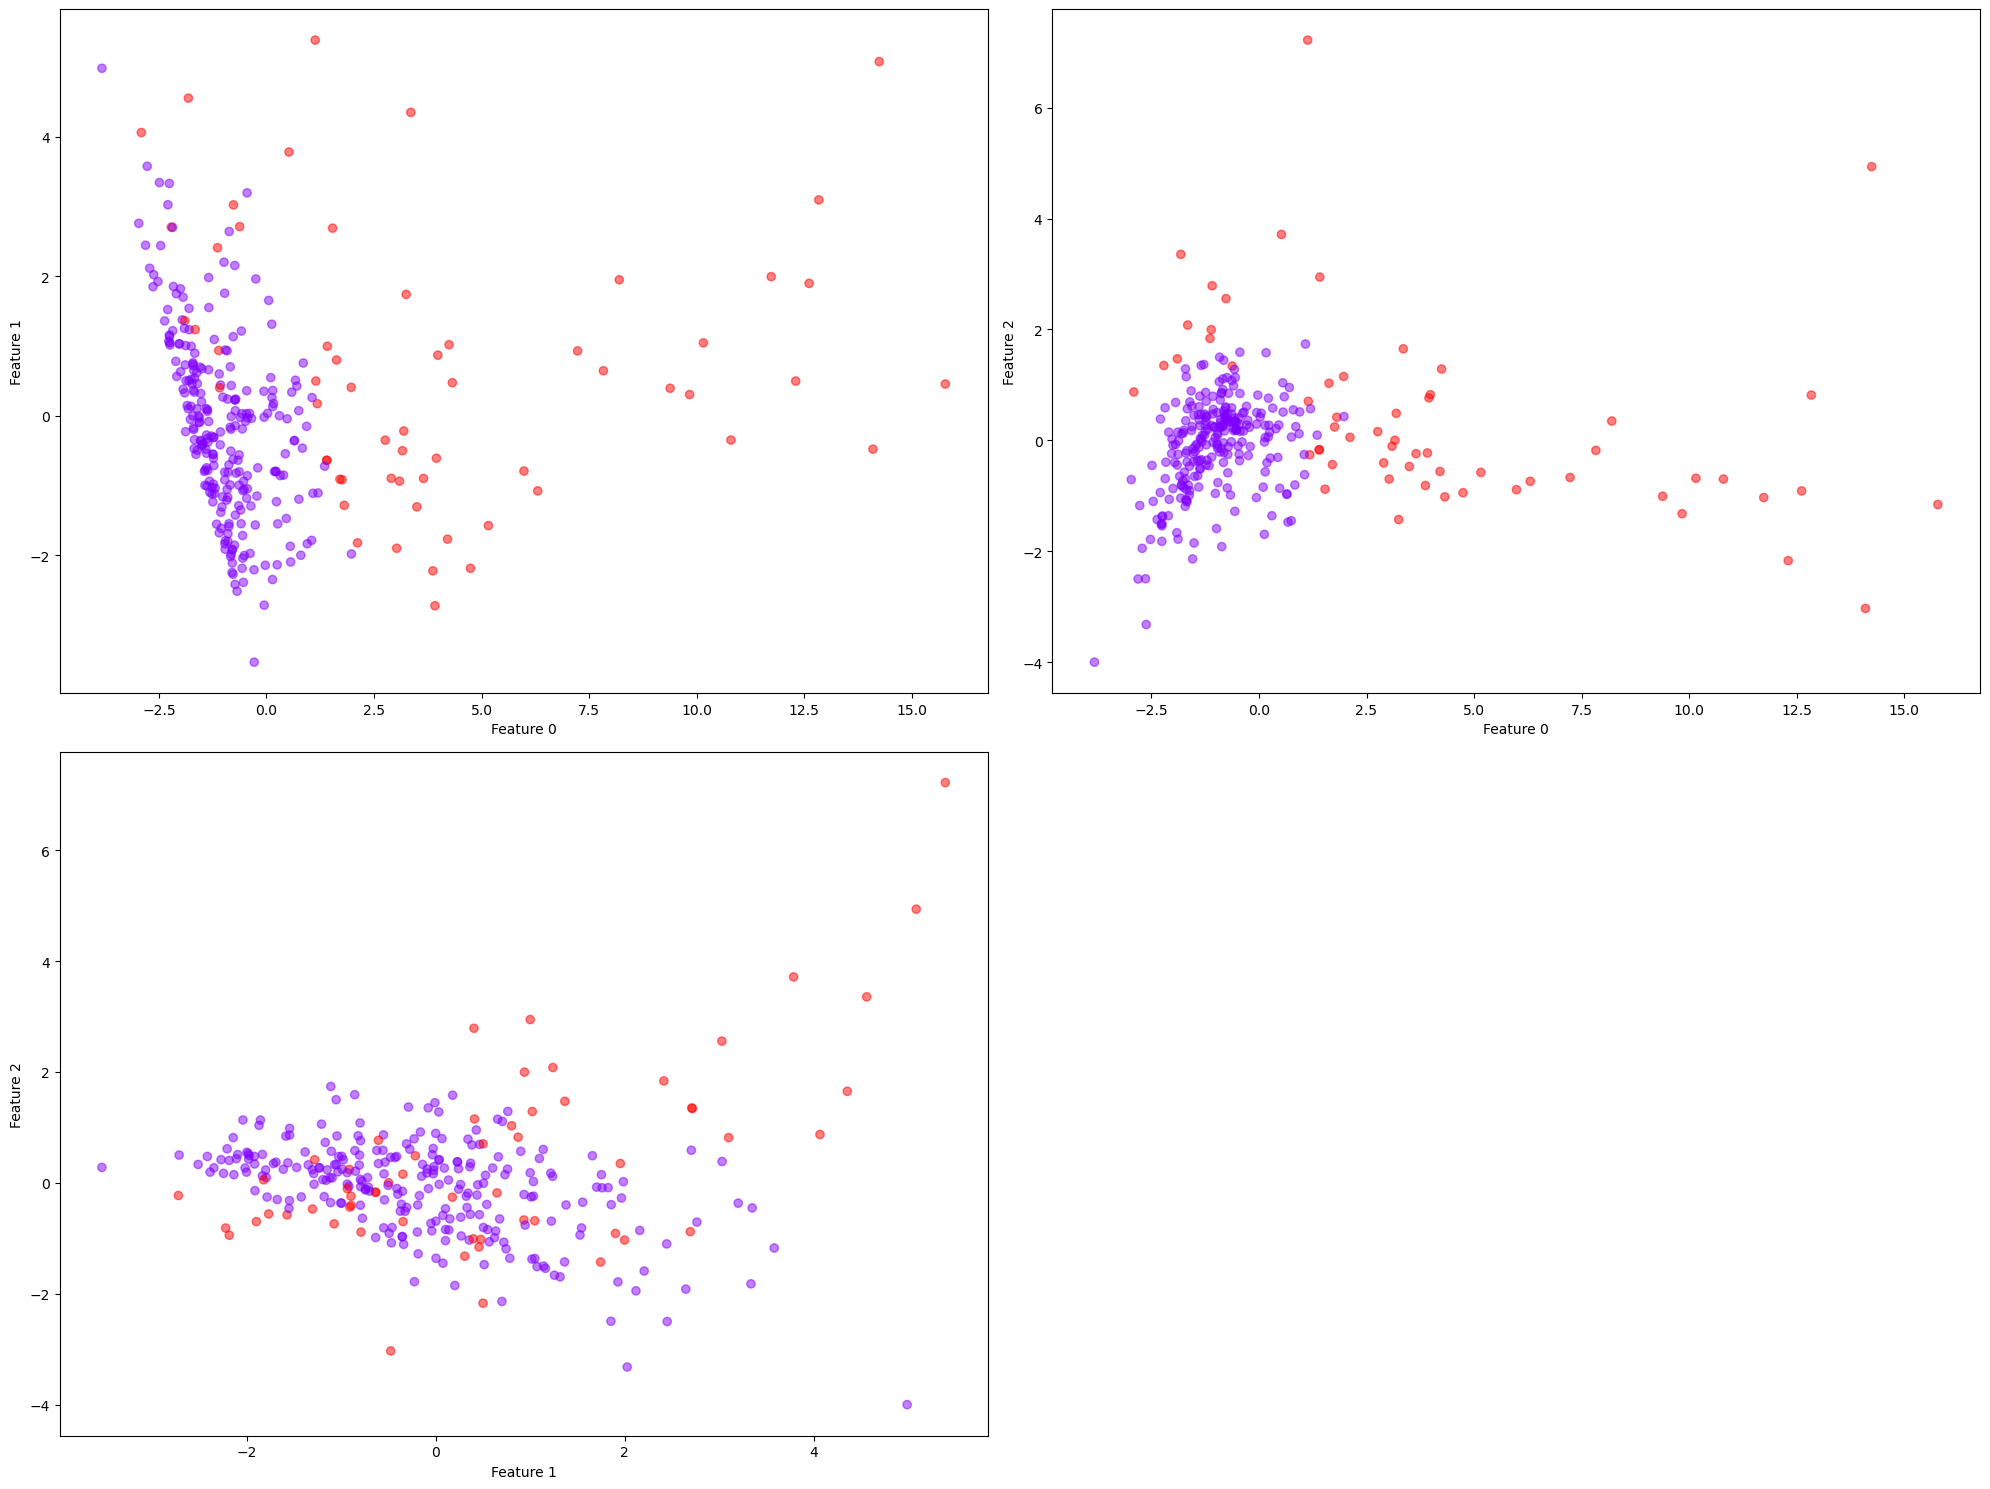

In [23]:
# k means clustering for the optimal number of clusters
kmeans = GaussianMixture(n_components=2).fit(X3)
# C = kmeans.cluster_centers_ # the cluster centers in the p dimensions
labelCluster = kmeans.predict(X3) # the labelling for each point

# Number of features in X3
num_features = X3.shape[1]

# Determine the number of rows and columns for the subplots based on the number of features
n_plots = num_features * (num_features - 1) // 2  # Total number of plots needed
n_cols = int(num_features - 1)  # Number of columns (one less than the number of features)
n_rows = int(np.ceil(n_plots / n_cols))  # Number of rows of plots

fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, 15))

# Flatten the array of axes for easy indexing
axs = axs.flatten()

# Counter for the subplot index
plot_number = 0

for i in range(num_features):
    for j in range(i + 1, num_features):
        axs[plot_number].scatter(X3[:, i], X3[:, j], c=labelCluster, cmap='rainbow', alpha=0.5)
        # axs[plot_number].scatter(C[:, i], C[:, j], marker='x', color='black', s=100)
        axs[plot_number].set_xlabel(f'Feature {i}')
        axs[plot_number].set_ylabel(f'Feature {j}')
        plot_number += 1

# Hide any unused subplots
for i in range(plot_number, n_rows * n_cols):
    fig.delaxes(axs[i])

plt.tight_layout()
plt.show()

# label clusterEDA_P
hr_data1['ClusterEDA_P_pca_GMM'] = labelCluster

> ## featuresEDA_T

c:\Users\mario\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


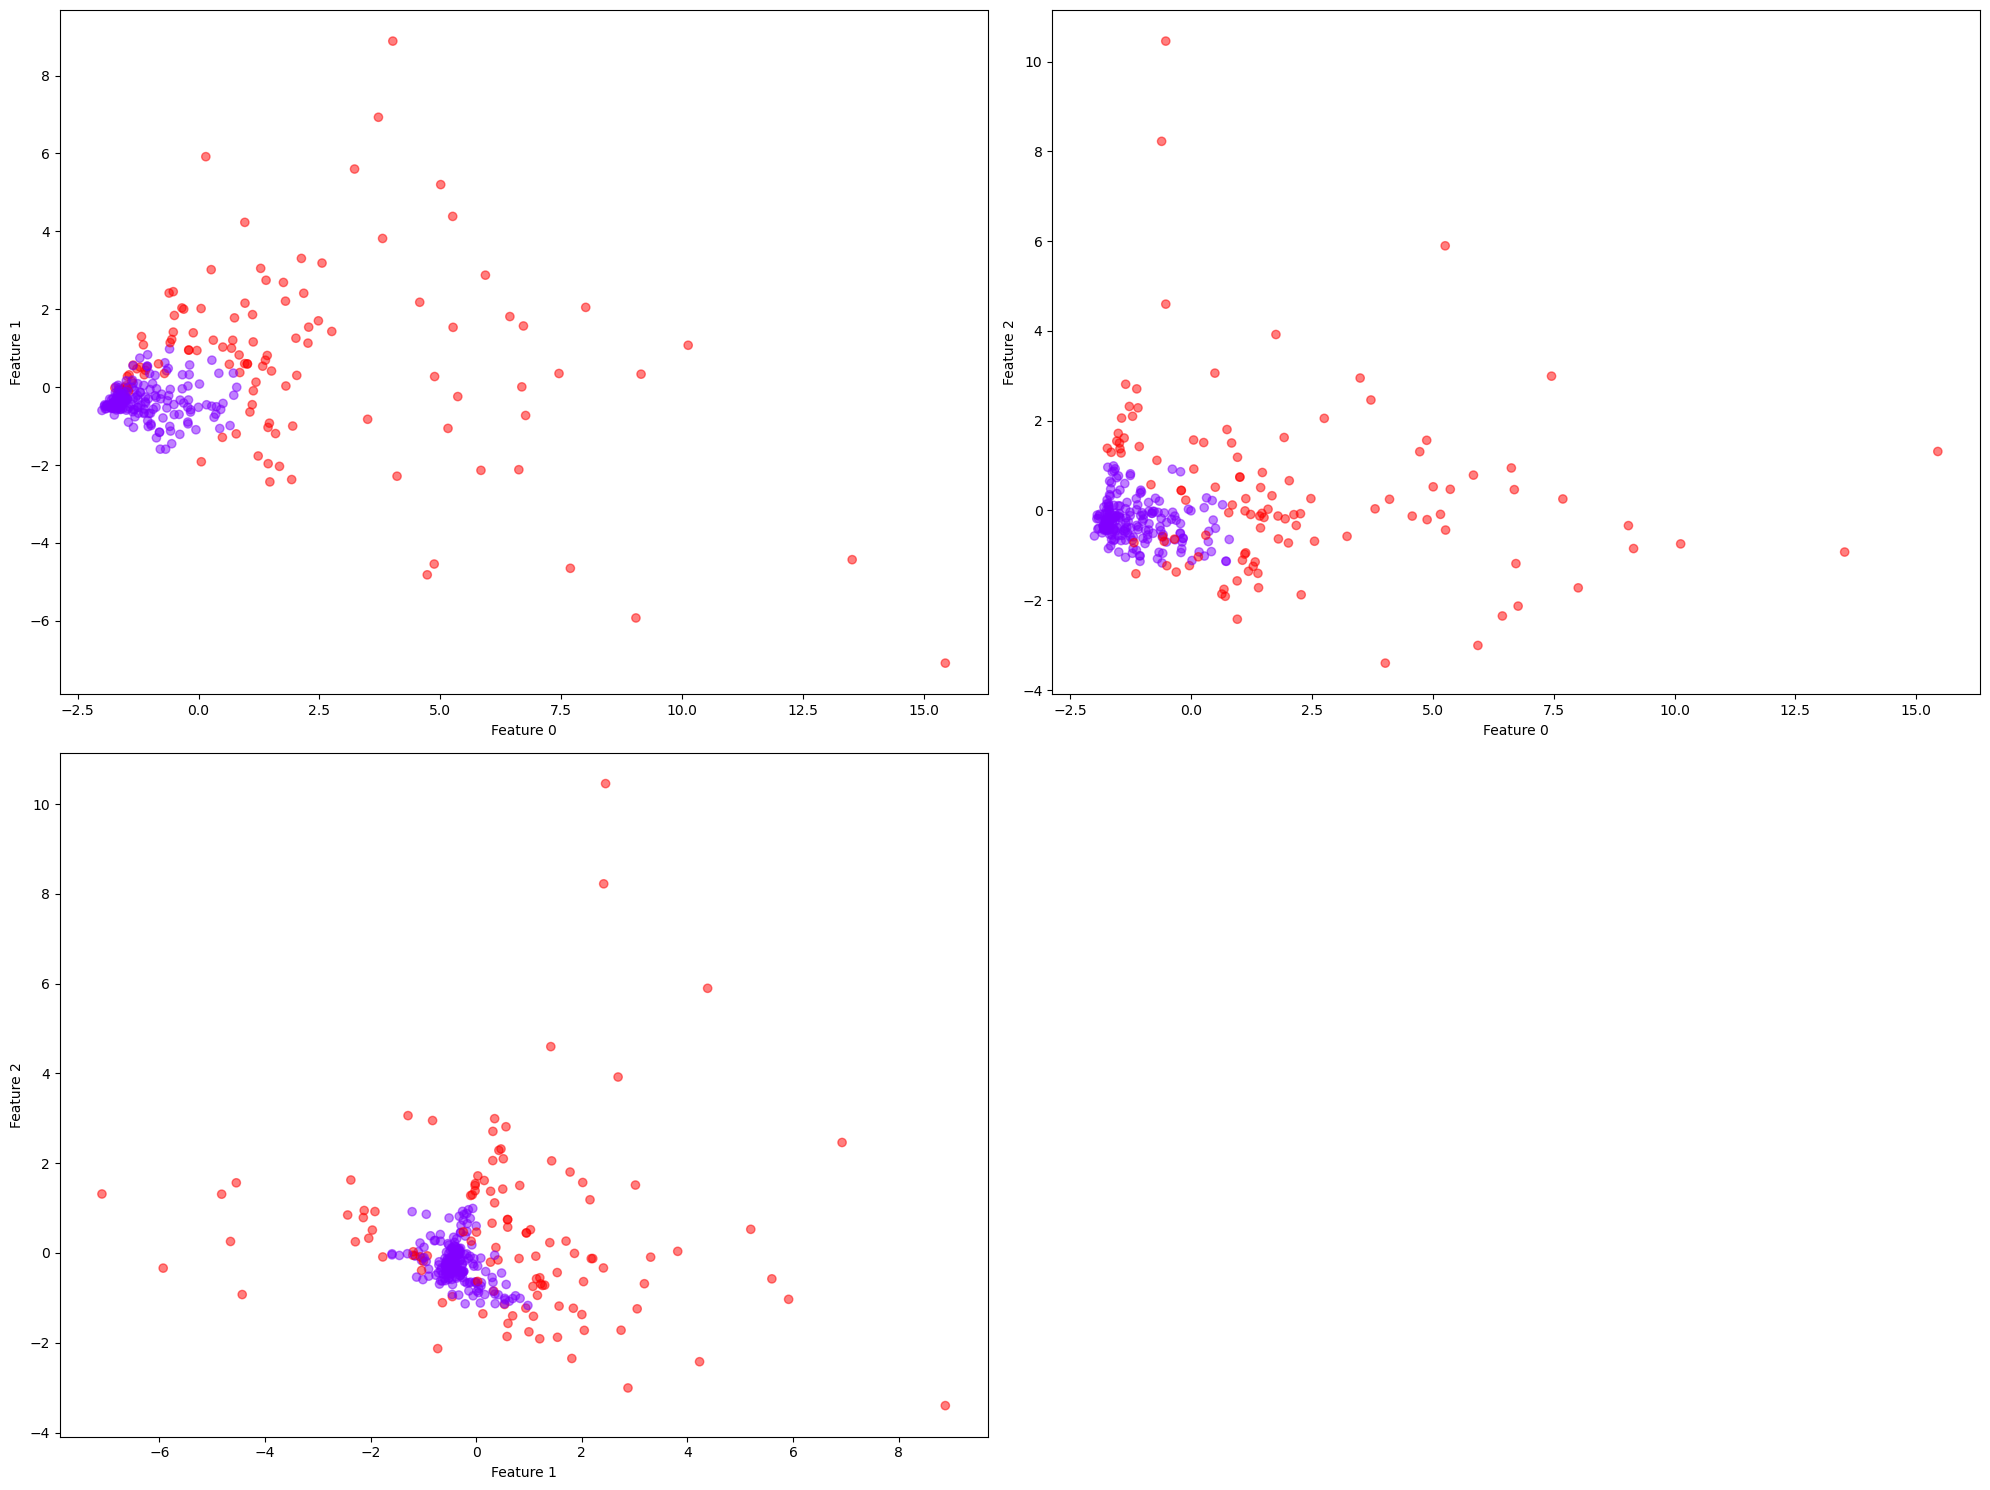

In [24]:
# k means clustering for the optimal number of clusters
kmeans = GaussianMixture(n_components=2).fit(X4)
# C = kmeans.cluster_centers_ # the cluster centers in the p dimensions
labelCluster = kmeans.predict(X4) # the labelling for each point

# Number of features in X4
num_features = X4.shape[1]

# Determine the number of rows and columns for the subplots based on the number of features
n_plots = num_features * (num_features - 1) // 2  # Total number of plots needed
n_cols = int(num_features - 1)  # Number of columns (one less than the number of features)
n_rows = int(np.ceil(n_plots / n_cols))  # Number of rows of plots

fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, 15))

# Flatten the array of axes for easy indexing
axs = axs.flatten()

# Counter for the subplot index
plot_number = 0

for i in range(num_features):
    for j in range(i + 1, num_features):
        axs[plot_number].scatter(X4[:, i], X4[:, j], c=labelCluster, cmap='rainbow', alpha=0.5)
        # axs[plot_number].scatter(C[:, i], C[:, j], marker='x', color='black', s=100)
        axs[plot_number].set_xlabel(f'Feature {i}')
        axs[plot_number].set_ylabel(f'Feature {j}')
        plot_number += 1

# Hide any unused subplots
for i in range(plot_number, n_rows * n_cols):
    fig.delaxes(axs[i])

plt.tight_layout()
plt.show()

# label clusterEDA_T
hr_data1['ClusterEDA_T_pca_GMM'] = labelCluster

> ## hr_data_preprocessed

c:\Users\mario\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


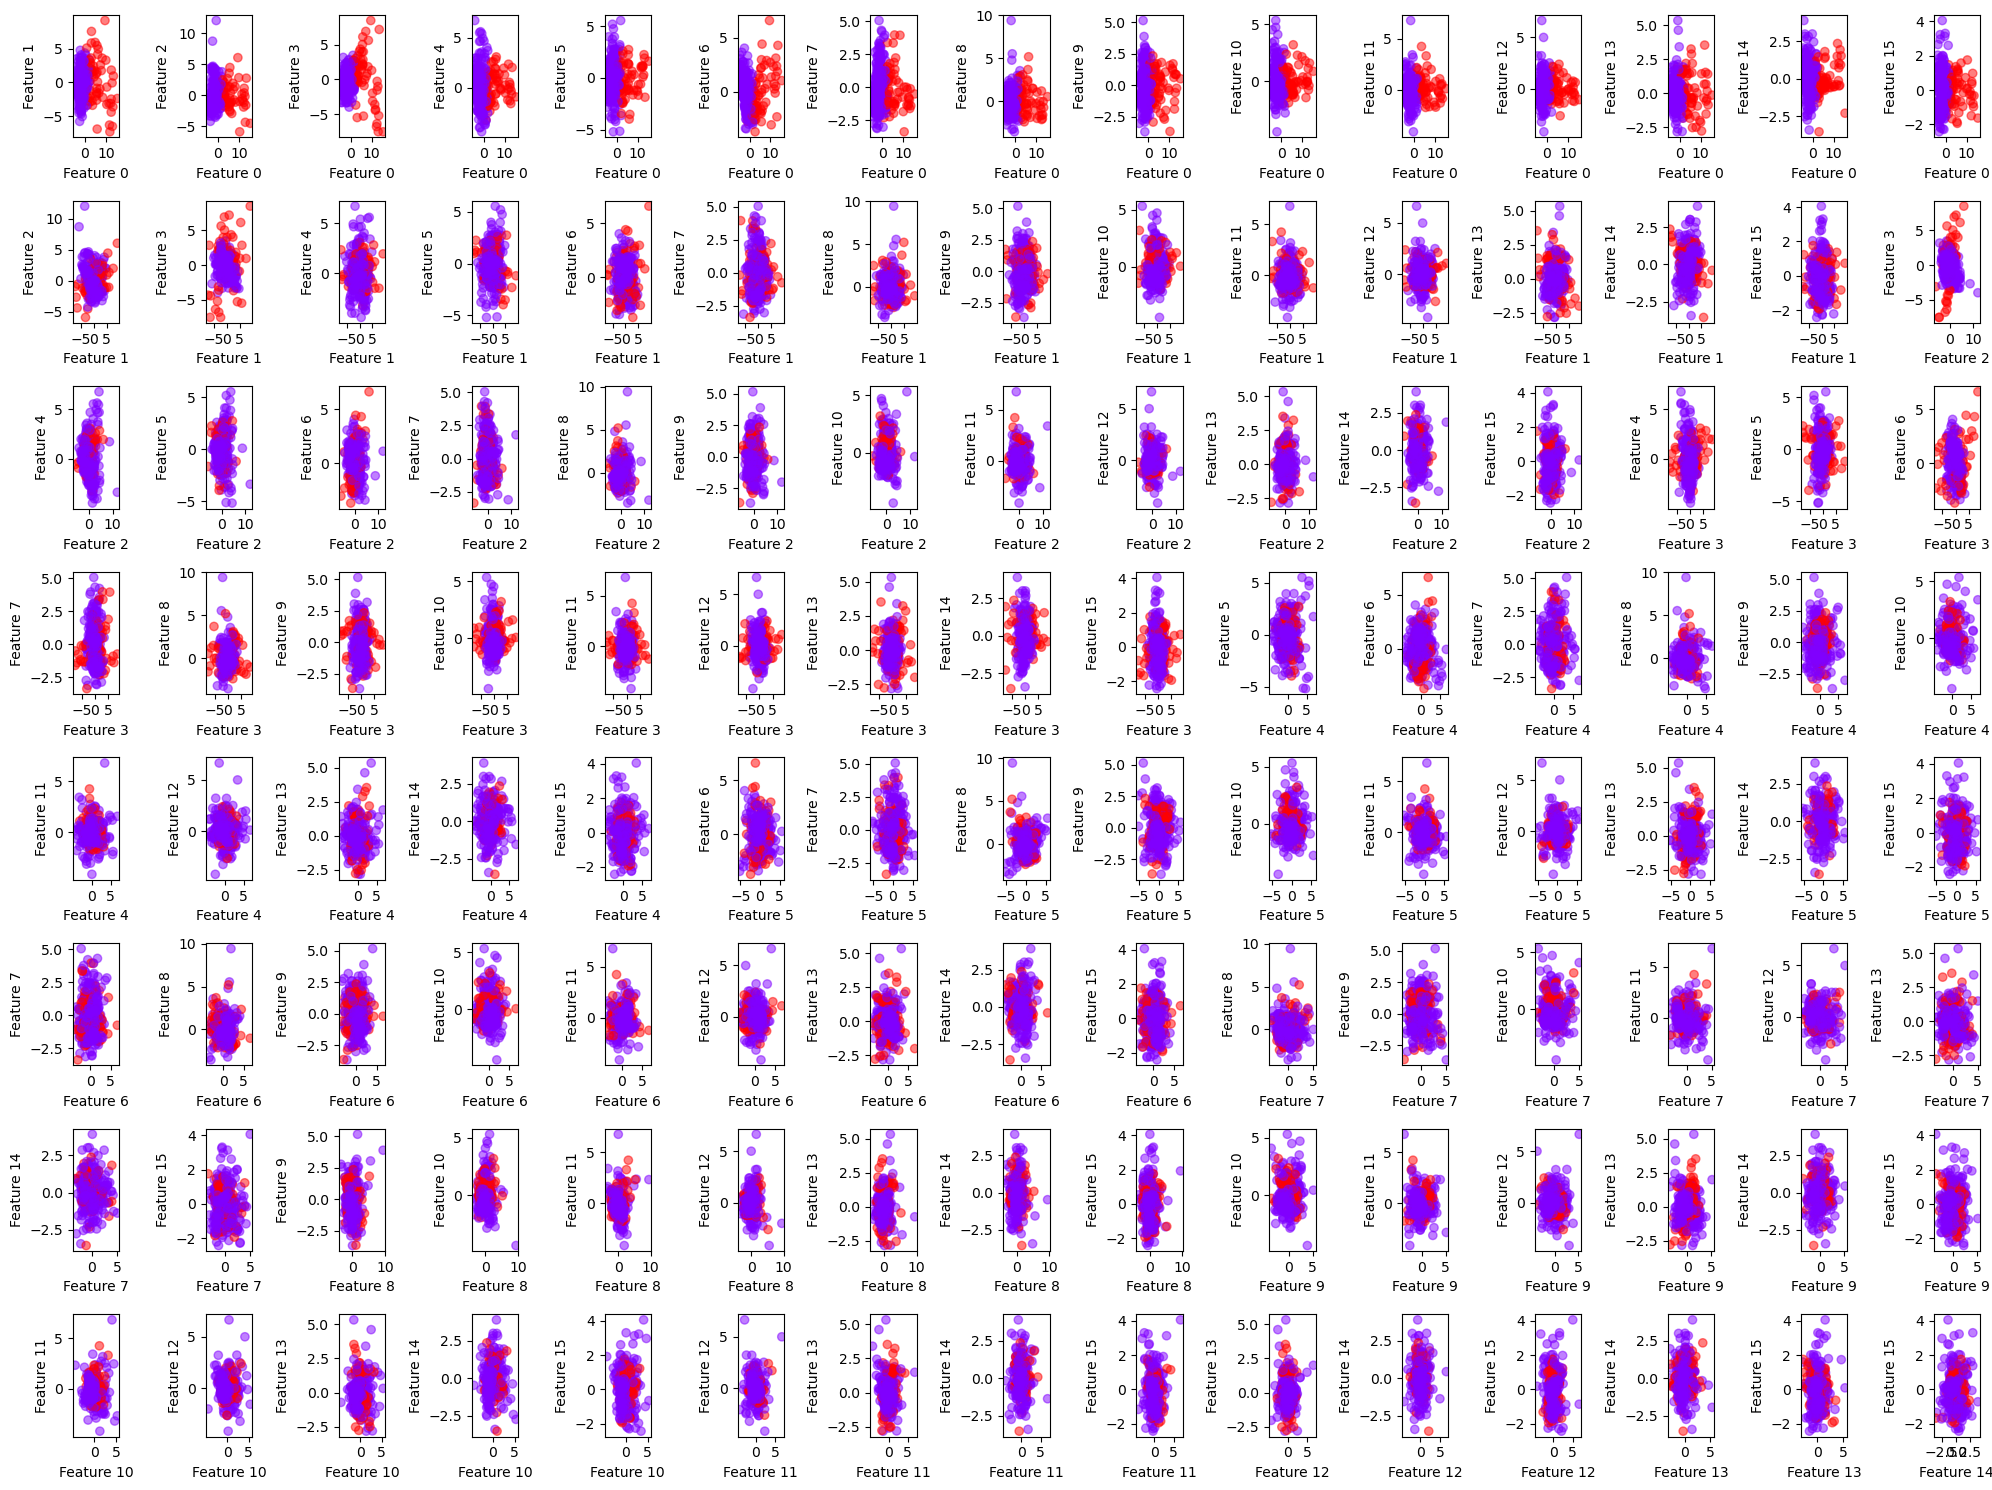

In [25]:

# k means clustering for the optimal number of clusters
kmeans = GaussianMixture(n_components=2).fit(X5)
# C = kmeans.cluster_centers_ # the cluster centers in the p dimensions
labelCluster = kmeans.predict(X5) # the labelling for each point

# Number of features in X5
num_features = X5.shape[1]

# Determine the number of rows and columns for the subplots based on the number of features
n_plots = num_features * (num_features - 1) // 2  # Total number of plots needed
n_cols = int(num_features - 1)  # Number of columns (one less than the number of features)
n_rows = int(np.ceil(n_plots / n_cols))  # Number of rows of plots

fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, 15))

# Flatten the array of axes for easy indexing
axs = axs.flatten()

# Counter for the subplot index
plot_number = 0

for i in range(num_features):
    for j in range(i + 1, num_features):
        axs[plot_number].scatter(X5[:, i], X5[:, j], c=labelCluster, cmap='rainbow', alpha=0.5)
        # axs[plot_number].scatter(C[:, i], C[:, j], marker='x', color='black', s=100)
        axs[plot_number].set_xlabel(f'Feature {i}')
        axs[plot_number].set_ylabel(f'Feature {j}')
        plot_number += 1

# Hide any unused subplots
for i in range(plot_number, n_rows * n_cols):
    fig.delaxes(axs[i])

plt.tight_layout()
plt.show()

# label clusterAll
hr_data1['ClusterAll_pca_GMM'] = labelCluster

# K-means Clustering ICA

In [26]:
X1 = np.asarray(featuresHR_ica)
X2 = np.asarray(featuresTEMP_ica)
X3 = np.asarray(featuresEDA_P_ica)
X4 = np.asarray(featuresEDA_T_ica)
X5 = np.asarray(hr_data_preprocessed_ica)

> ## featuresHR_pca

c:\Users\mario\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


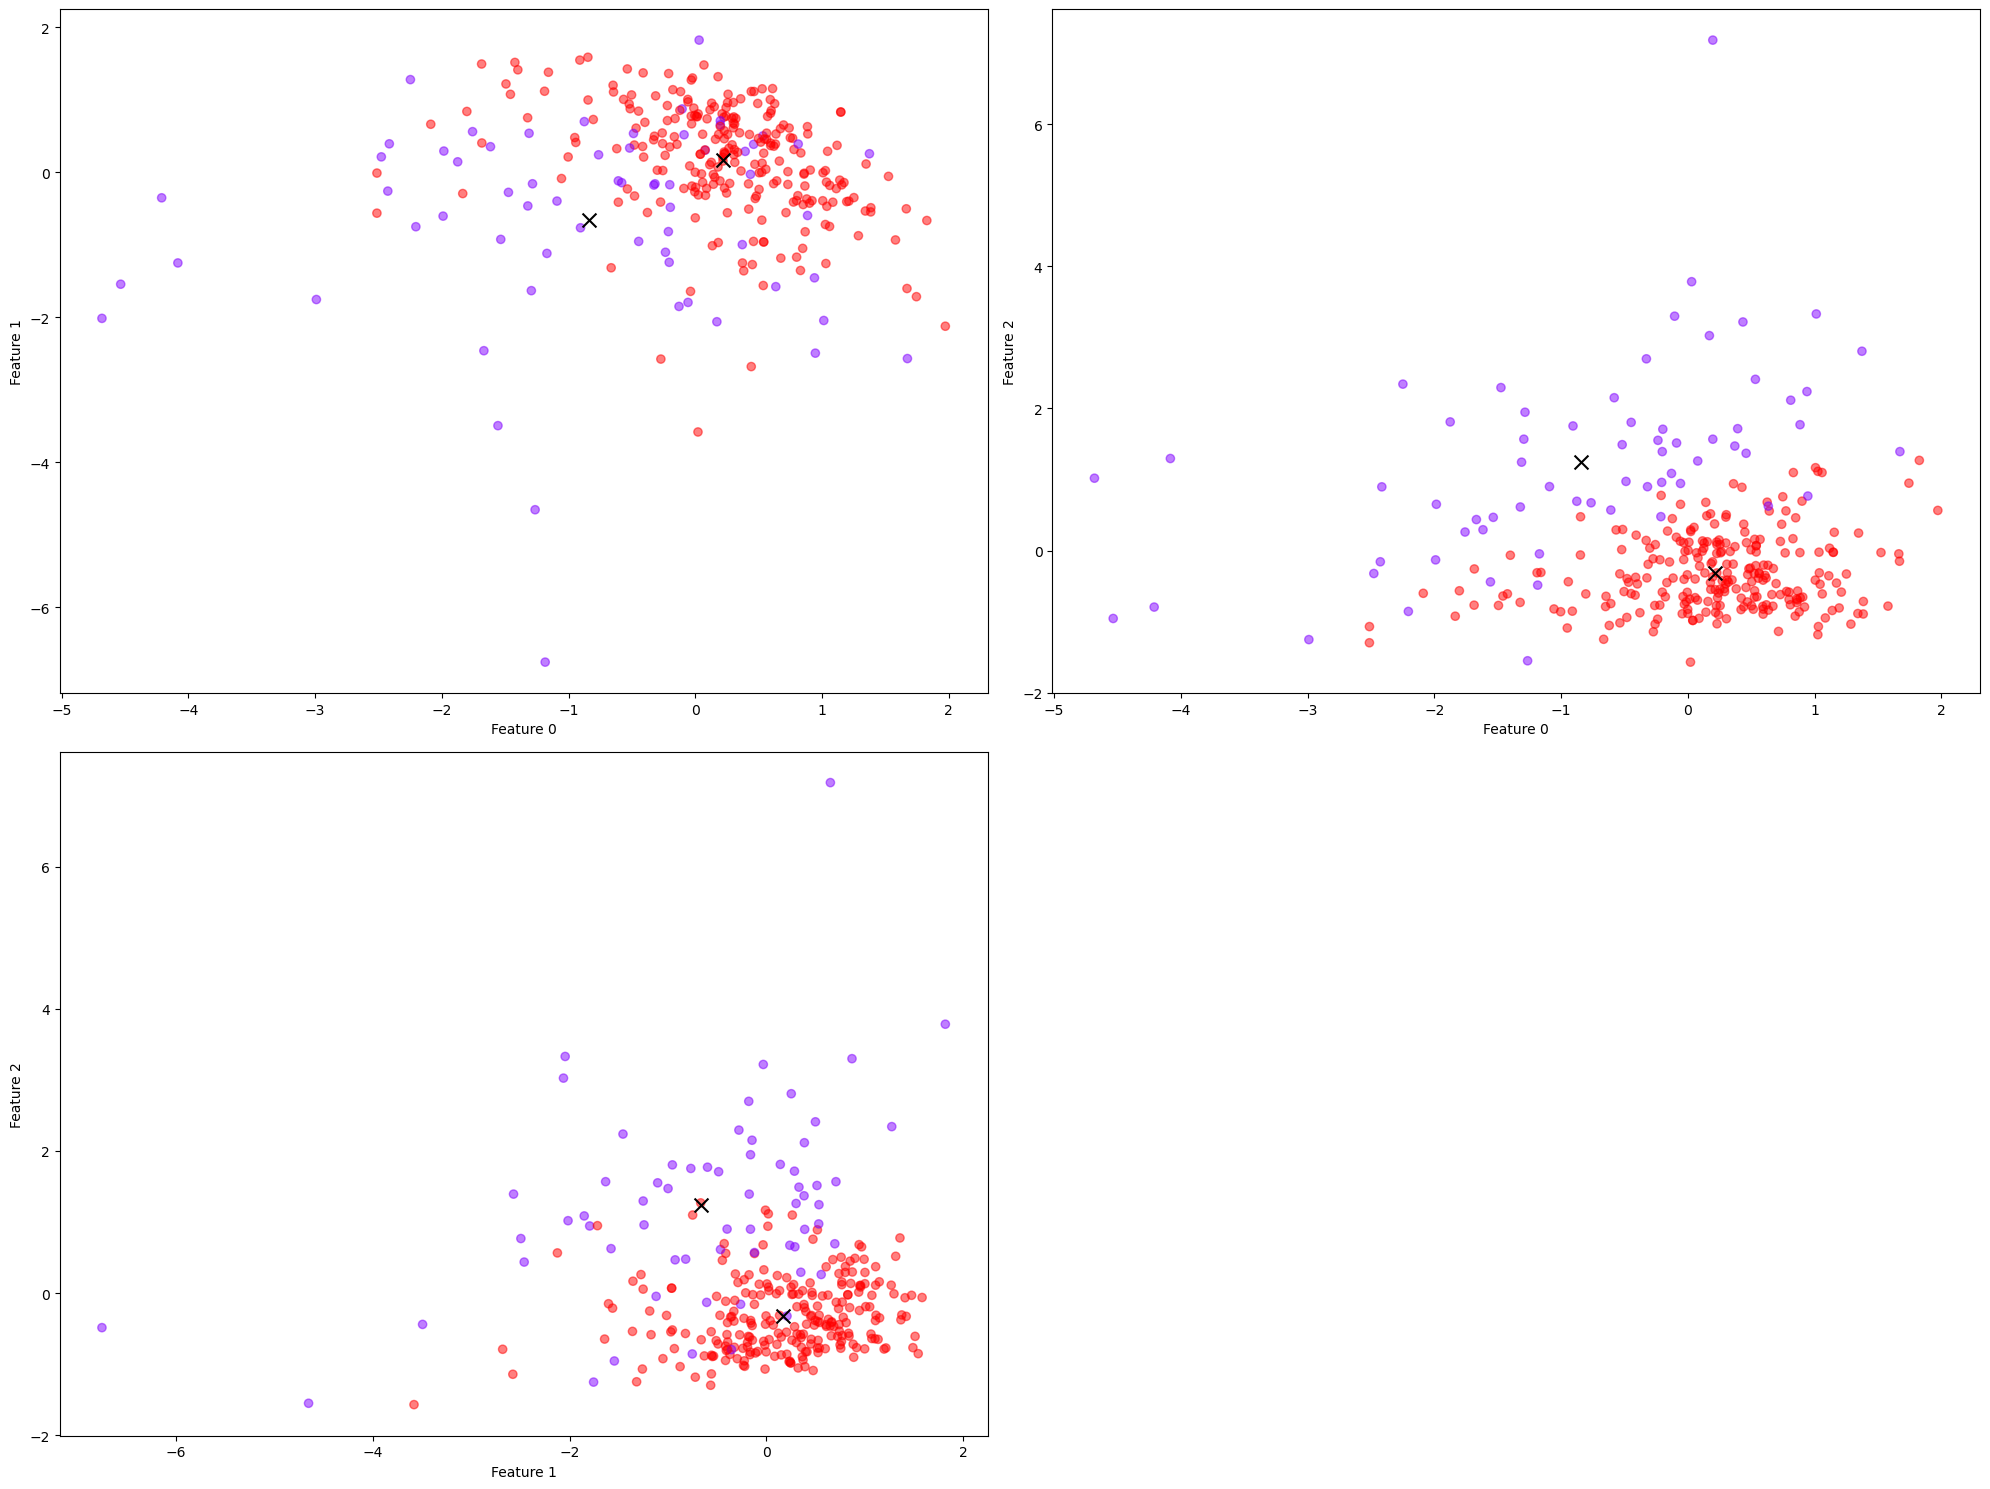

In [27]:
# k means clustering for the optimal number of clusters
kmeans = KMeans(n_clusters=2).fit(X1)
C = kmeans.cluster_centers_ # the cluster centers in the p dimensions
labelCluster = kmeans.labels_ # the labelling for each point

# Number of features in X1
num_features = X1.shape[1]

# Determine the number of rows and columns for the subplots based on the number of features
n_plots = num_features * (num_features - 1) // 2  # Total number of plots needed
n_cols = int(num_features - 1)  # Number of columns (one less than the number of features)
n_rows = int(np.ceil(n_plots / n_cols))  # Number of rows of plots

fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, 15))

# Flatten the array of axes for easy indexing
axs = axs.flatten()

# Counter for the subplot index
plot_number = 0

for i in range(num_features):
    for j in range(i + 1, num_features):
        axs[plot_number].scatter(X1[:, i], X1[:, j], c=labelCluster, cmap='rainbow', alpha=0.5)
        axs[plot_number].scatter(C[:, i], C[:, j], marker='x', color='black', s=100)
        axs[plot_number].set_xlabel(f'Feature {i}')
        axs[plot_number].set_ylabel(f'Feature {j}')
        plot_number += 1

# Hide any unused subplots
for i in range(plot_number, n_rows * n_cols):
    fig.delaxes(axs[i])

plt.tight_layout()
plt.show()

# label clusterHR
hr_data1['ClusterHR_ica'] = labelCluster

> ## featuresTEMP

c:\Users\mario\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


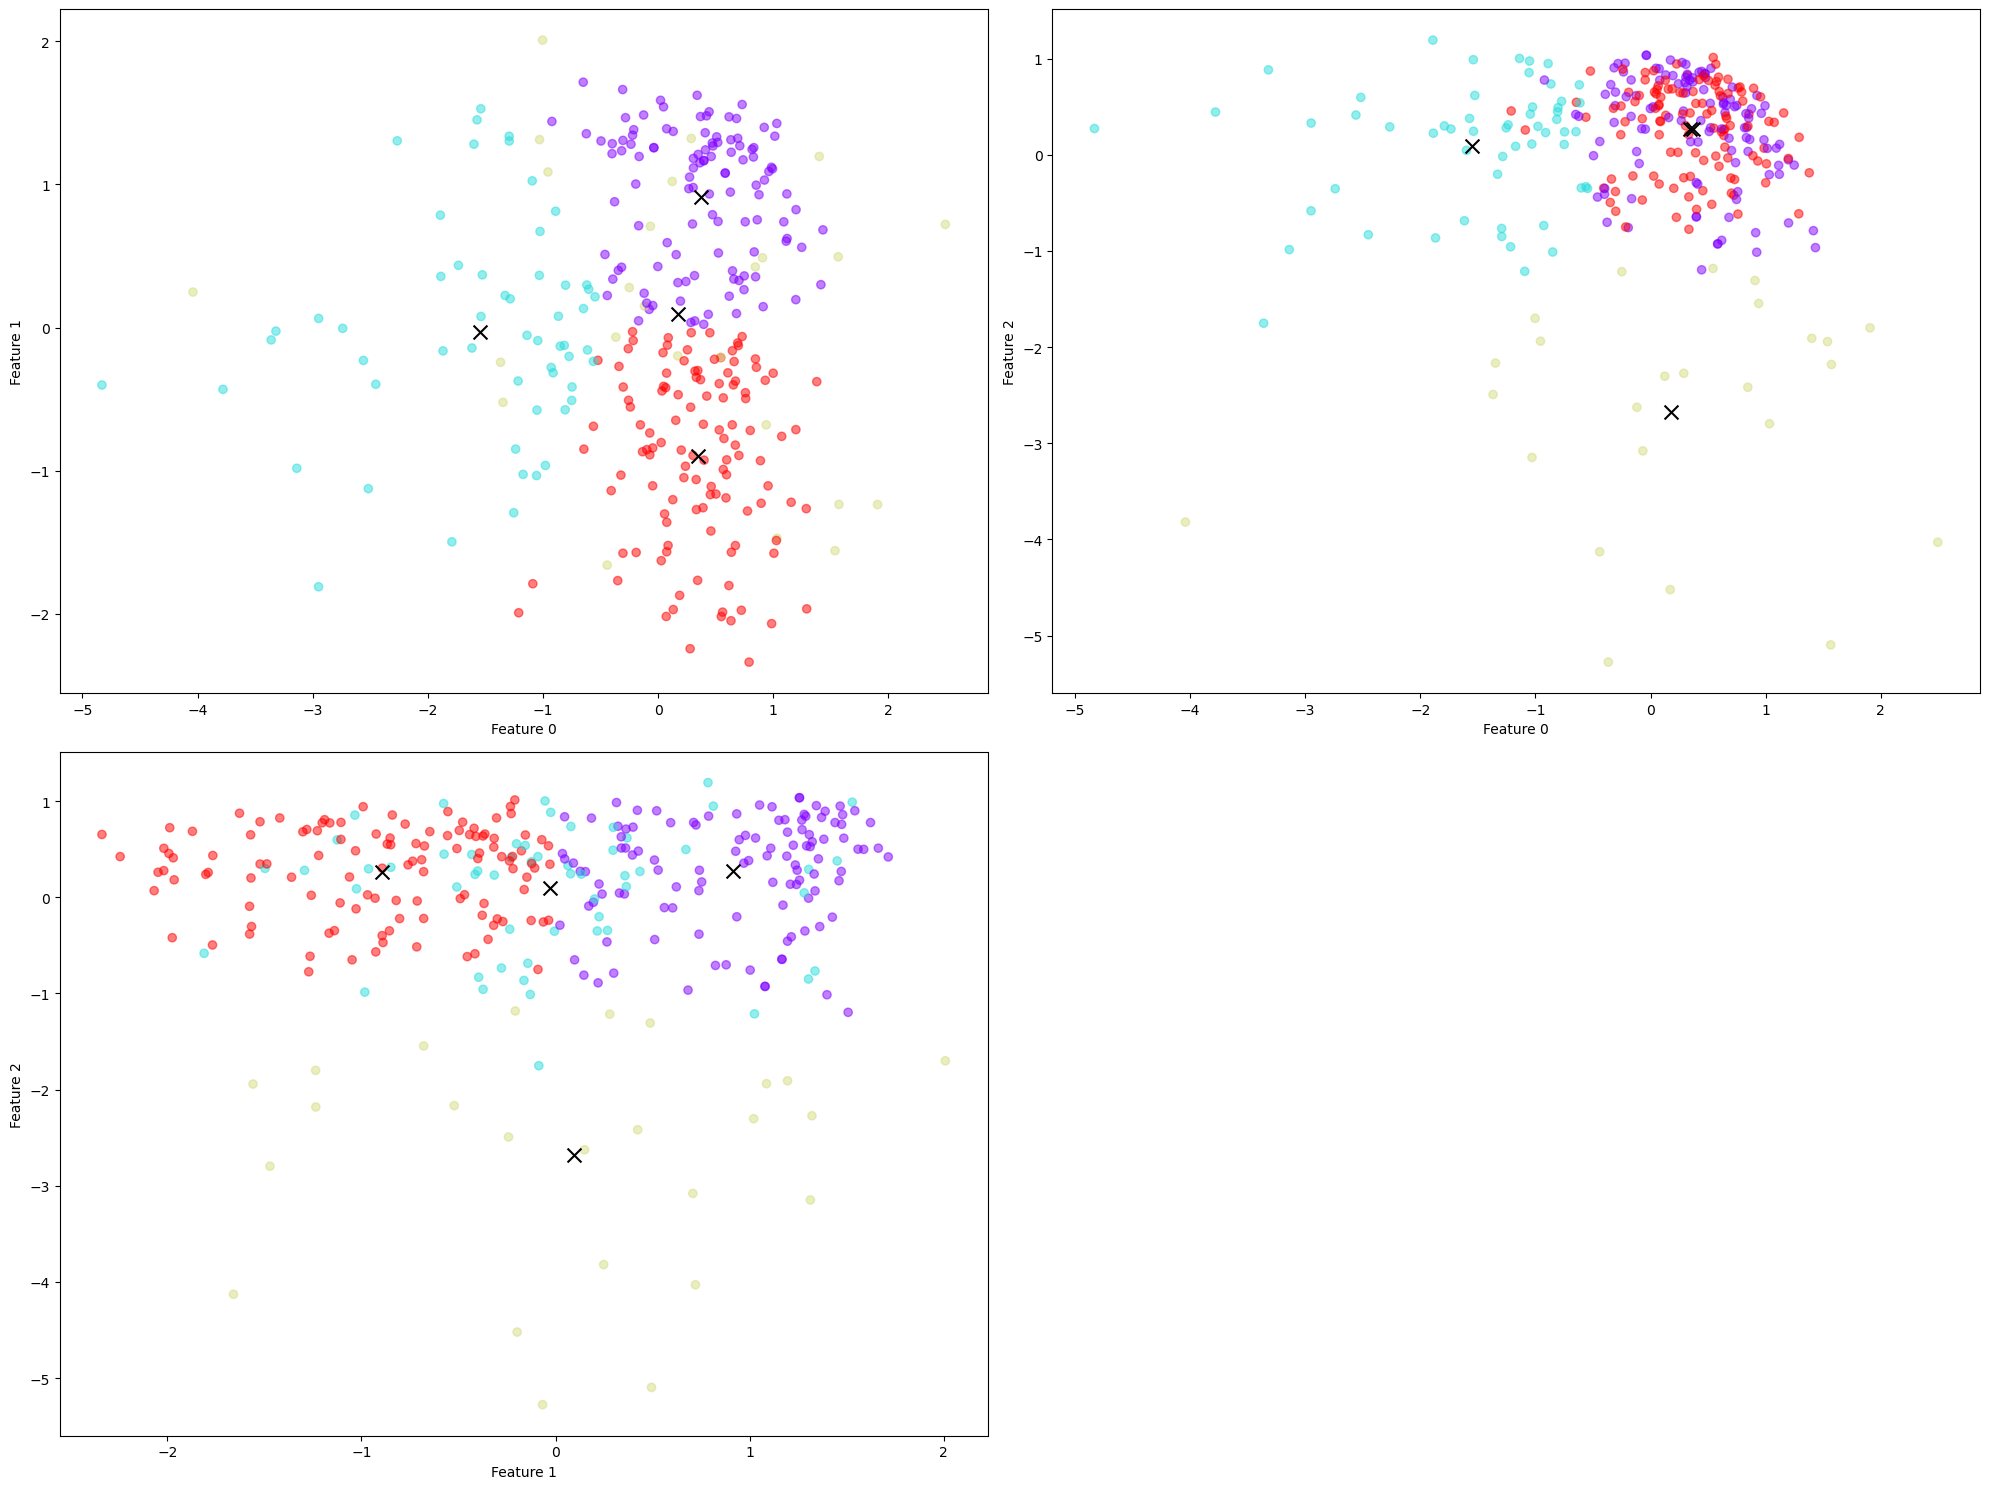

In [28]:
# k means clustering for the optimal number of clusters
kmeans = KMeans(n_clusters=4).fit(X2)
C = kmeans.cluster_centers_ # the cluster centers in the p dimensions
labelCluster = kmeans.labels_ # the labelling for each point

# Number of features in X2
num_features = X2.shape[1]

# Determine the number of rows and columns for the subplots based on the number of features
n_plots = num_features * (num_features - 1) // 2  # Total number of plots needed
n_cols = int(num_features - 1)  # Number of columns (one less than the number of features)
n_rows = int(np.ceil(n_plots / n_cols))  # Number of rows of plots

fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, 15))

# Flatten the array of axes for easy indexing
axs = axs.flatten()

# Counter for the subplot index
plot_number = 0

for i in range(num_features):
    for j in range(i + 1, num_features):
        axs[plot_number].scatter(X2[:, i], X2[:, j], c=labelCluster, cmap='rainbow', alpha=0.5)
        axs[plot_number].scatter(C[:, i], C[:, j], marker='x', color='black', s=100)
        axs[plot_number].set_xlabel(f'Feature {i}')
        axs[plot_number].set_ylabel(f'Feature {j}')
        plot_number += 1

# Hide any unused subplots
for i in range(plot_number, n_rows * n_cols):
    fig.delaxes(axs[i])

plt.tight_layout()
plt.show()

# label clusterTEMP
hr_data1['ClusterTEMP_ica'] = labelCluster


> ## featuresEDA_P

c:\Users\mario\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


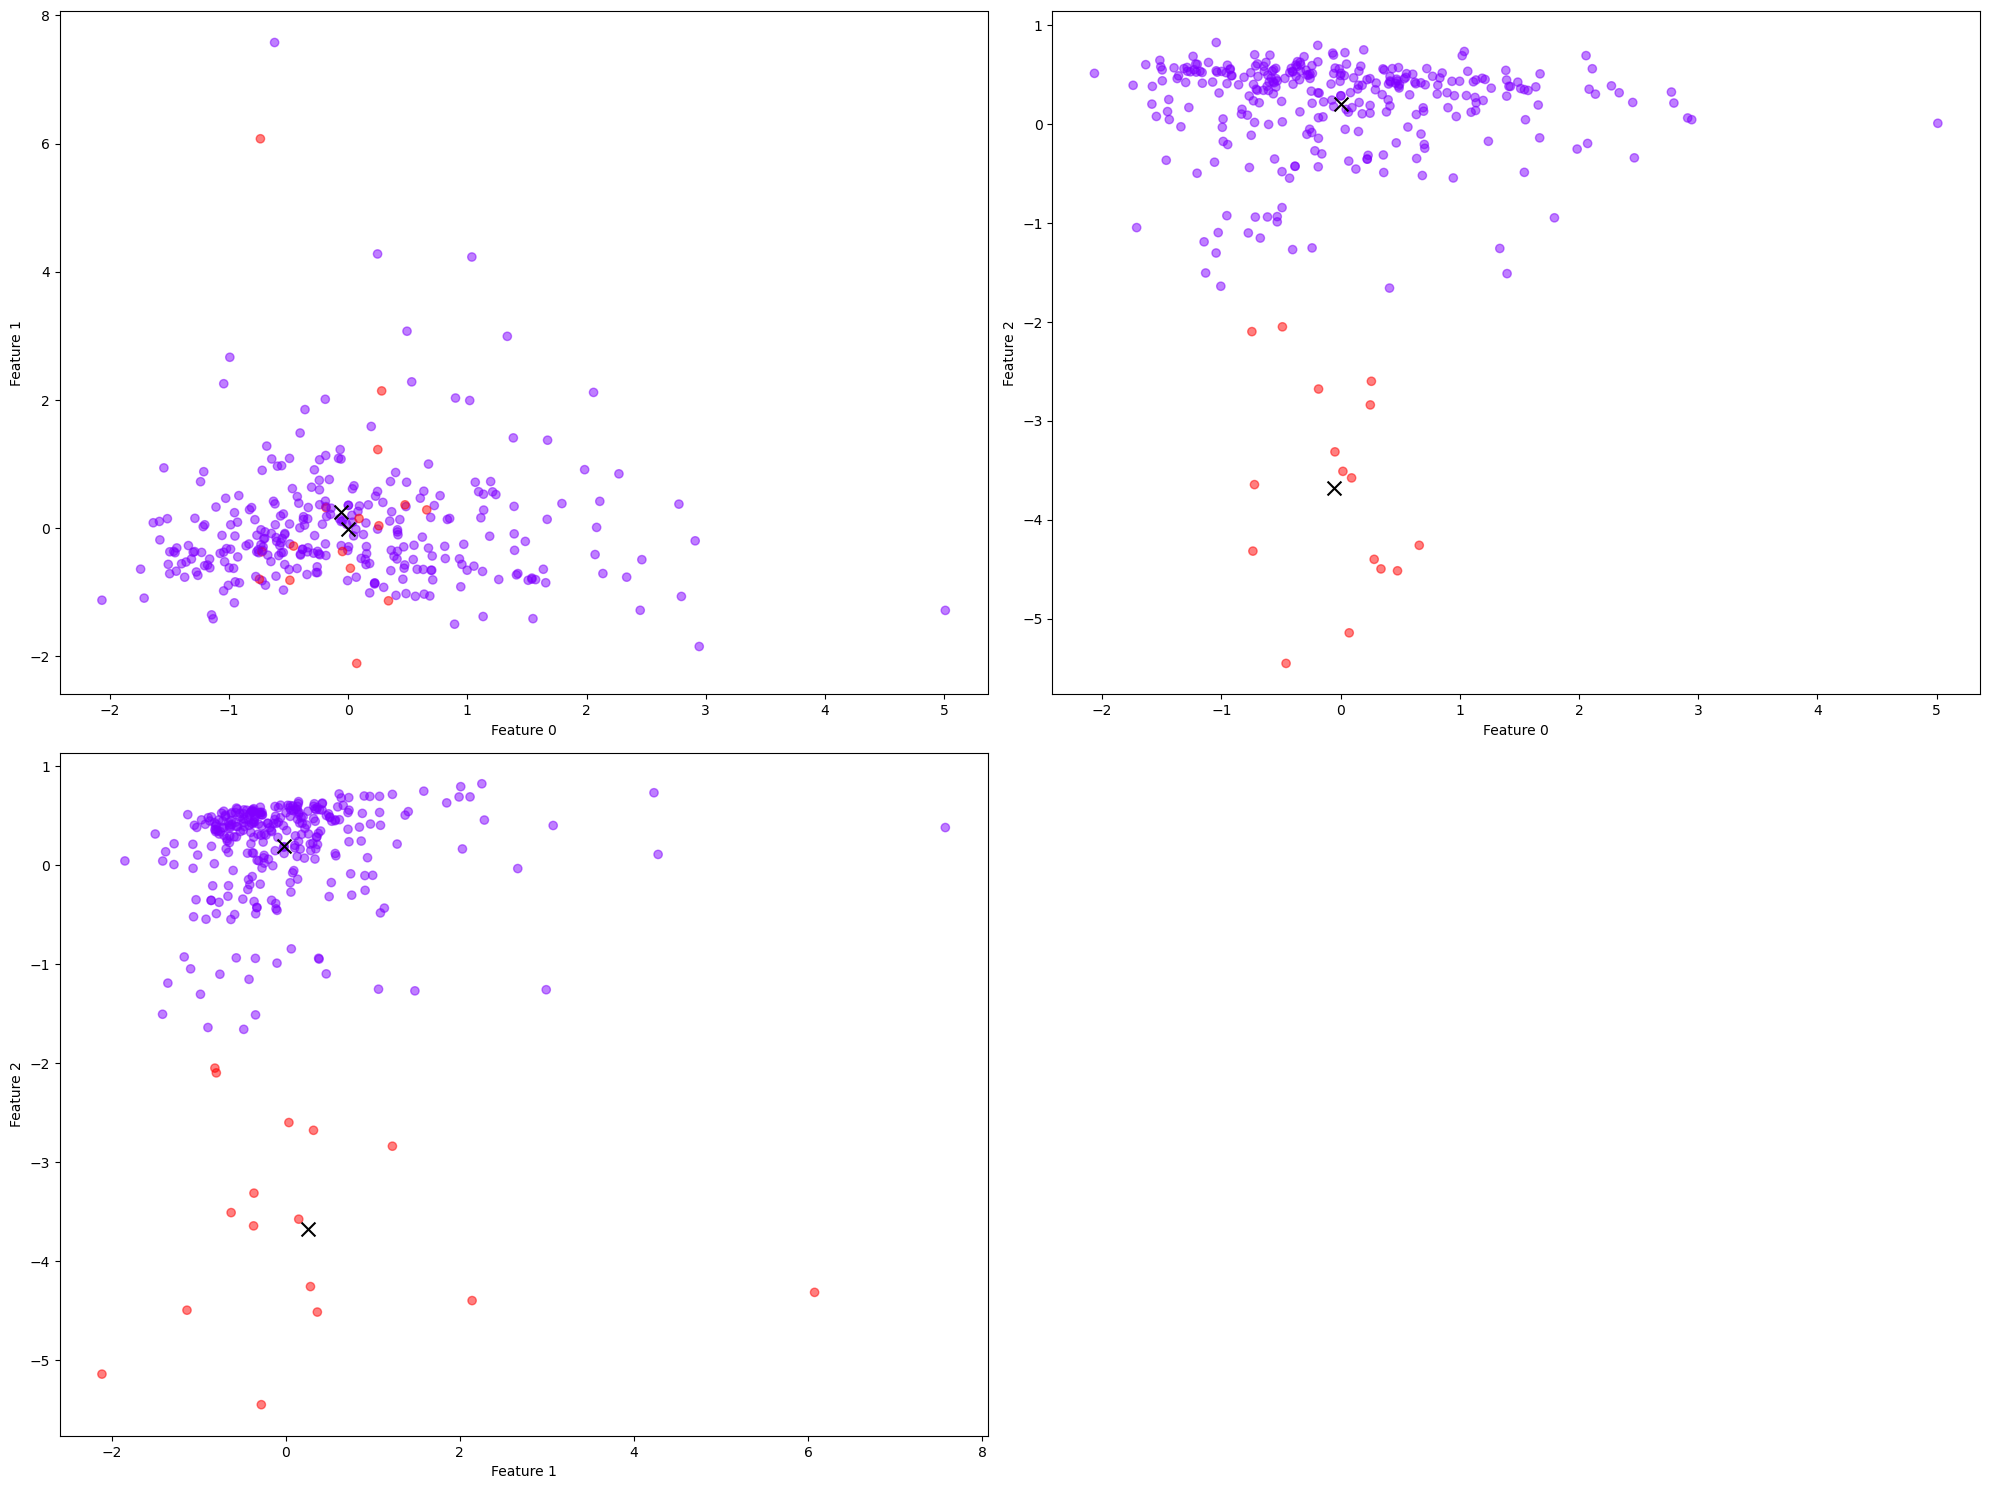

In [29]:
# k means clustering for the optimal number of clusters
kmeans = KMeans(n_clusters=2).fit(X3)
C = kmeans.cluster_centers_ # the cluster centers in the p dimensions
labelCluster = kmeans.labels_ # the labelling for each point

# Number of features in X3
num_features = X3.shape[1]

# Determine the number of rows and columns for the subplots based on the number of features
n_plots = num_features * (num_features - 1) // 2  # Total number of plots needed
n_cols = int(num_features - 1)  # Number of columns (one less than the number of features)
n_rows = int(np.ceil(n_plots / n_cols))  # Number of rows of plots

fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, 15))

# Flatten the array of axes for easy indexing
axs = axs.flatten()

# Counter for the subplot index
plot_number = 0

for i in range(num_features):
    for j in range(i + 1, num_features):
        axs[plot_number].scatter(X3[:, i], X3[:, j], c=labelCluster, cmap='rainbow', alpha=0.5)
        axs[plot_number].scatter(C[:, i], C[:, j], marker='x', color='black', s=100)
        axs[plot_number].set_xlabel(f'Feature {i}')
        axs[plot_number].set_ylabel(f'Feature {j}')
        plot_number += 1

# Hide any unused subplots
for i in range(plot_number, n_rows * n_cols):
    fig.delaxes(axs[i])

plt.tight_layout()
plt.show()

# label clusterEDA_P
hr_data1['ClusterEDA_P_ica'] = labelCluster

> ## featuresEDA_T

c:\Users\mario\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


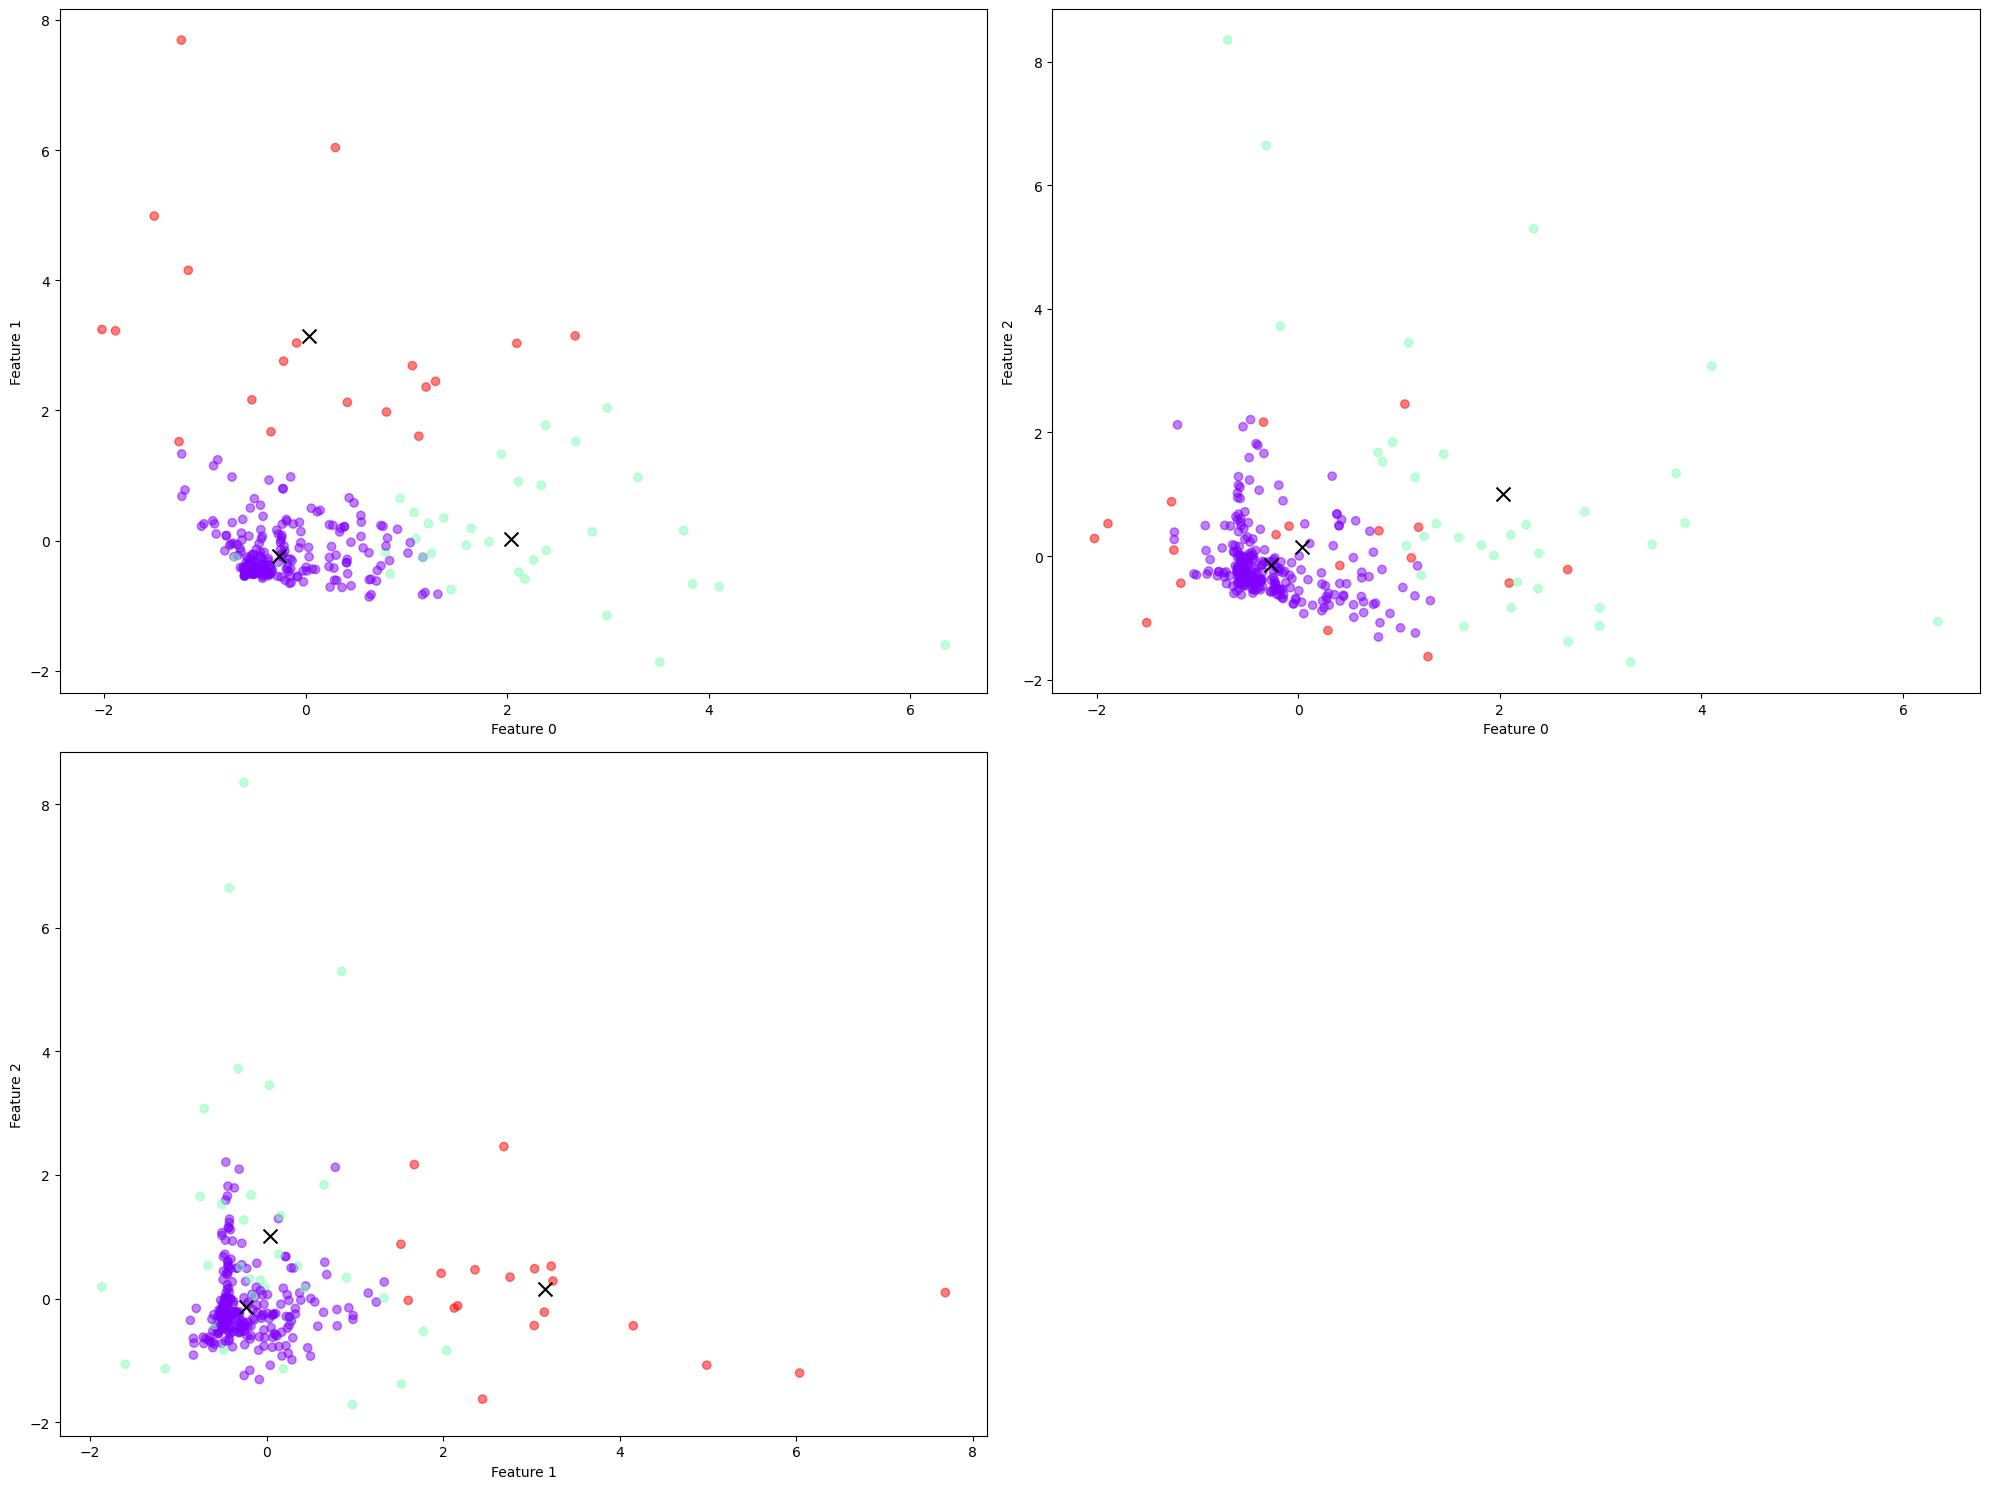

In [30]:
# k means clustering for the optimal number of clusters
kmeans = KMeans(n_clusters=3).fit(X4)
C = kmeans.cluster_centers_ # the cluster centers in the p dimensions
labelCluster = kmeans.labels_ # the labelling for each point

# Number of features in X4
num_features = X4.shape[1]

# Determine the number of rows and columns for the subplots based on the number of features
n_plots = num_features * (num_features - 1) // 2  # Total number of plots needed
n_cols = int(num_features - 1)  # Number of columns (one less than the number of features)
n_rows = int(np.ceil(n_plots / n_cols))  # Number of rows of plots

fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, 15))

# Flatten the array of axes for easy indexing
axs = axs.flatten()

# Counter for the subplot index
plot_number = 0

for i in range(num_features):
    for j in range(i + 1, num_features):
        axs[plot_number].scatter(X4[:, i], X4[:, j], c=labelCluster, cmap='rainbow', alpha=0.5)
        axs[plot_number].scatter(C[:, i], C[:, j], marker='x', color='black', s=100)
        axs[plot_number].set_xlabel(f'Feature {i}')
        axs[plot_number].set_ylabel(f'Feature {j}')
        plot_number += 1

# Hide any unused subplots
for i in range(plot_number, n_rows * n_cols):
    fig.delaxes(axs[i])

plt.tight_layout()
plt.show()

# label clusterEDA_T
hr_data1['ClusterEDA_T_ica'] = labelCluster

> ## hr_data_preprocessed

c:\Users\mario\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


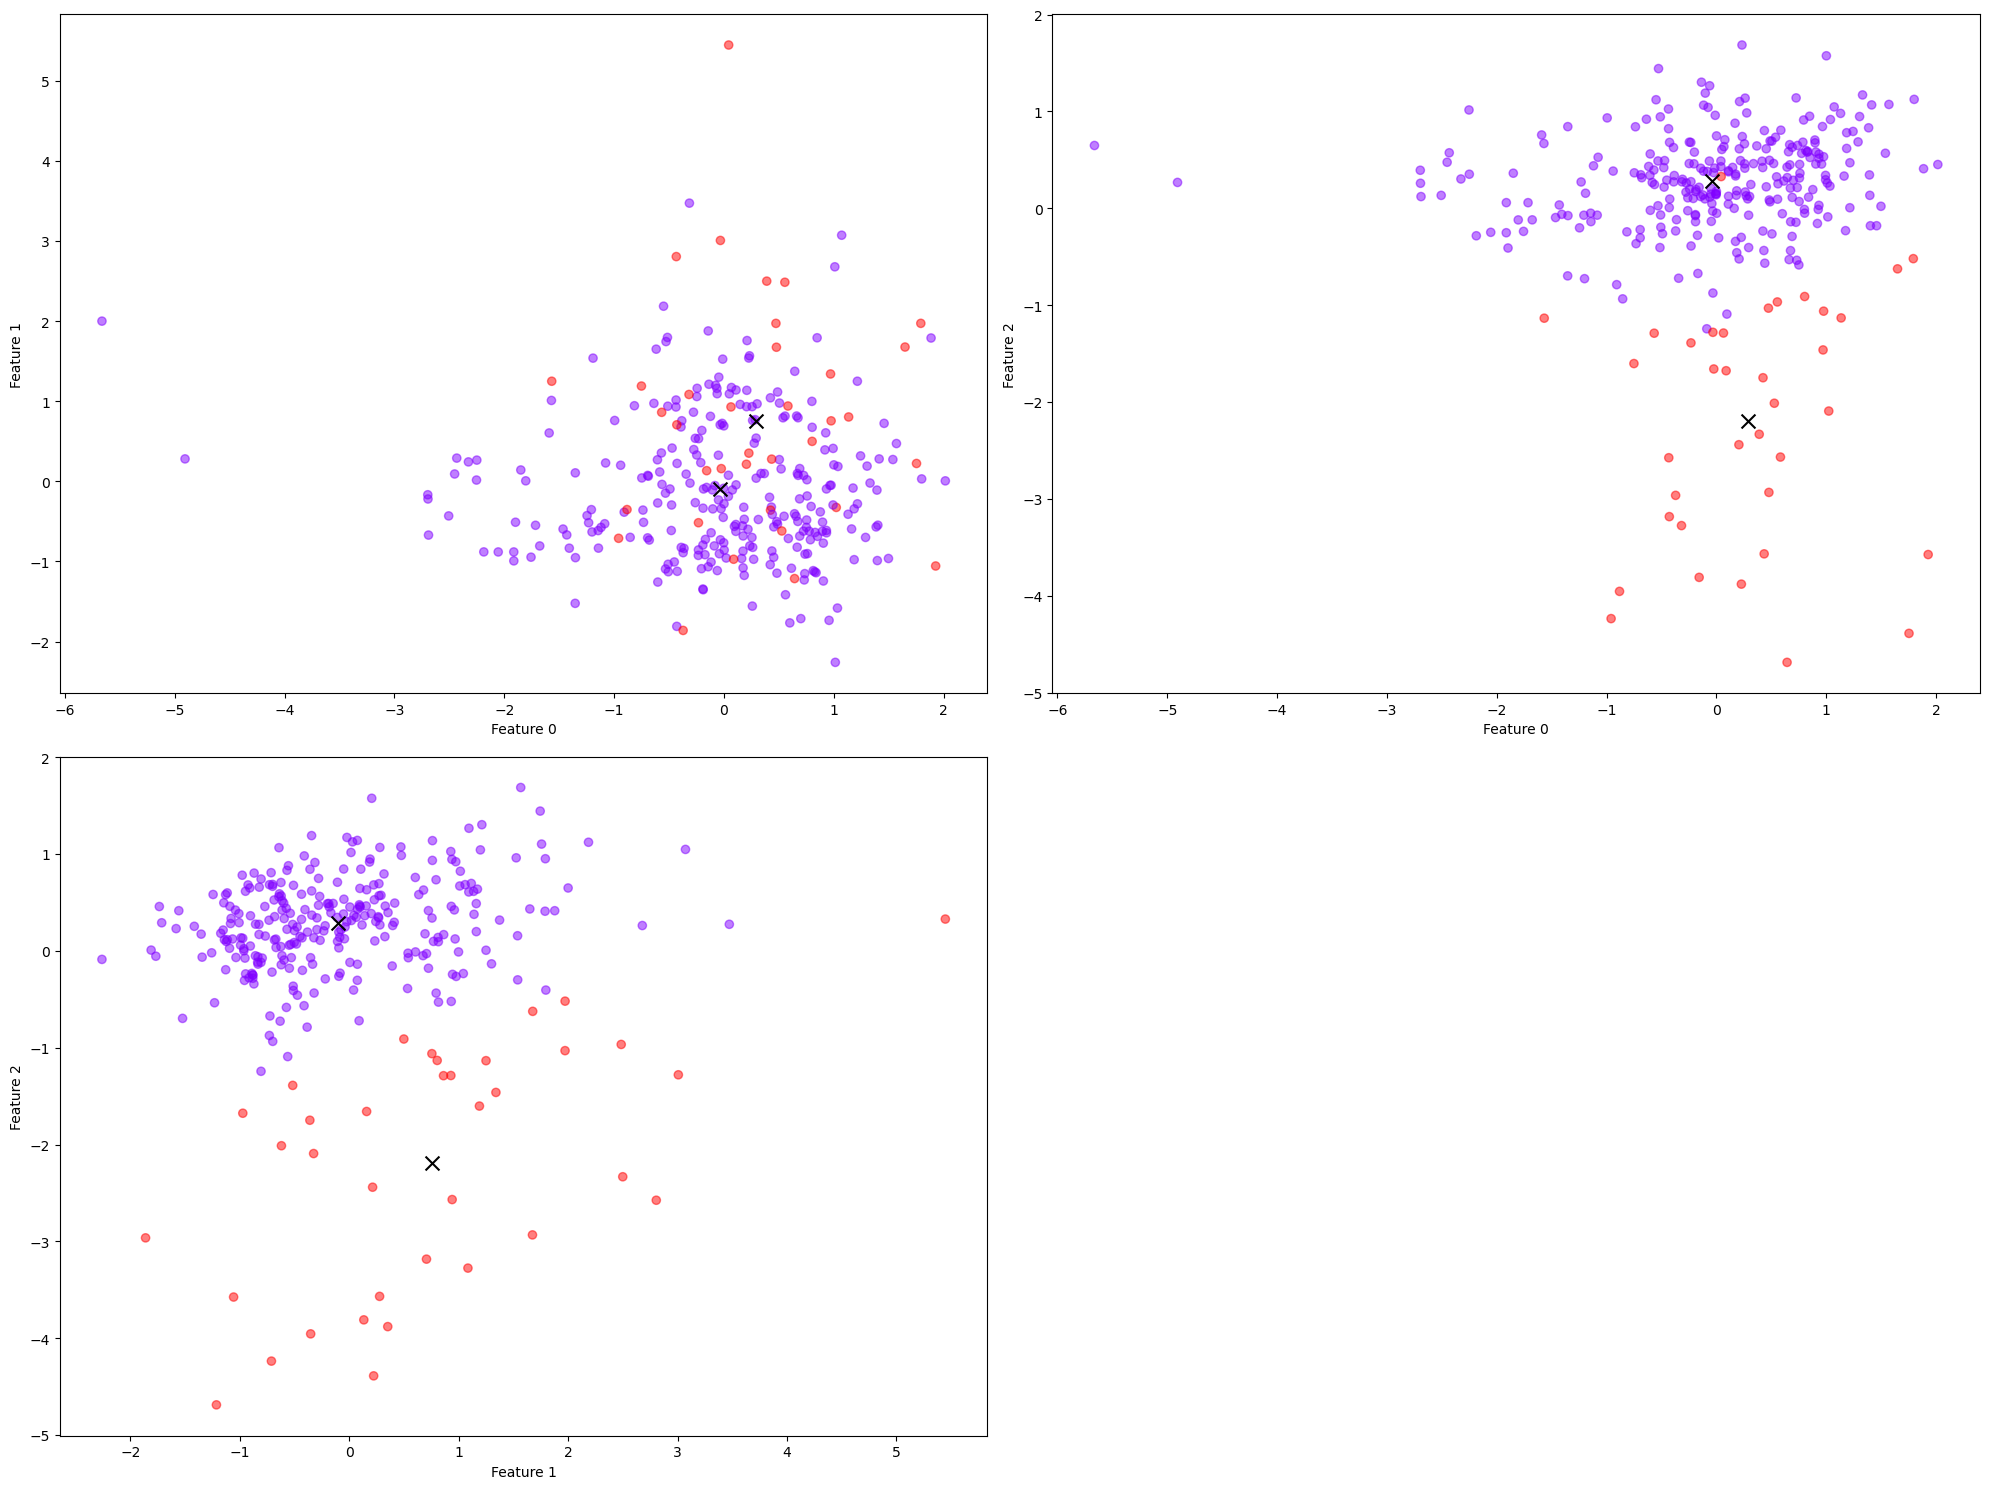

In [31]:

# k means clustering for the optimal number of clusters
kmeans = KMeans(n_clusters=2).fit(X5)
C = kmeans.cluster_centers_ # the cluster centers in the p dimensions

labelCluster = kmeans.labels_ # the labelling for each point

# Number of features in X5
num_features = X5.shape[1]

# Determine the number of rows and columns for the subplots based on the number of features
n_plots = num_features * (num_features - 1) // 2  # Total number of plots needed
n_cols = int(num_features - 1)  # Number of columns (one less than the number of features)
n_rows = int(np.ceil(n_plots / n_cols))  # Number of rows of plots

fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, 15))

# Flatten the array of axes for easy indexing
axs = axs.flatten()

# Counter for the subplot index
plot_number = 0

for i in range(num_features):
    for j in range(i + 1, num_features):
        axs[plot_number].scatter(X5[:, i], X5[:, j], c=labelCluster, cmap='rainbow', alpha=0.5)
        axs[plot_number].scatter(C[:, i], C[:, j], marker='x', color='black', s=100)
        axs[plot_number].set_xlabel(f'Feature {i}')
        axs[plot_number].set_ylabel(f'Feature {j}')
        plot_number += 1

# Hide any unused subplots
for i in range(plot_number, n_rows * n_cols):
    fig.delaxes(axs[i])

plt.tight_layout()
plt.show()

# label clusterAll
hr_data1['ClusterAll_ica'] = labelCluster

# Hierarchical ICA

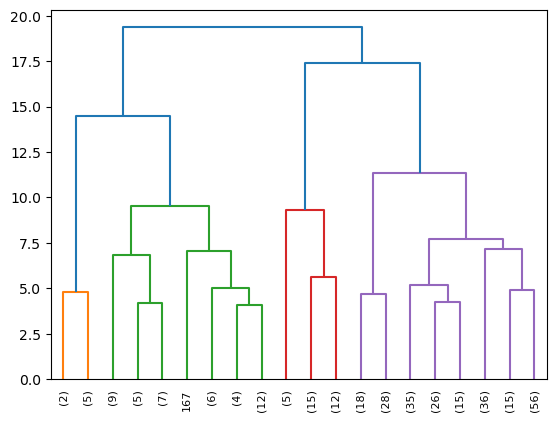

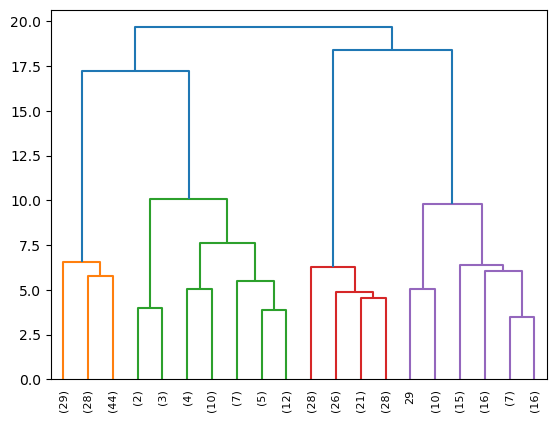

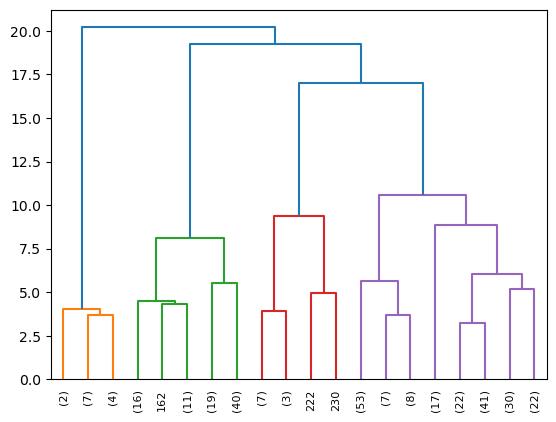

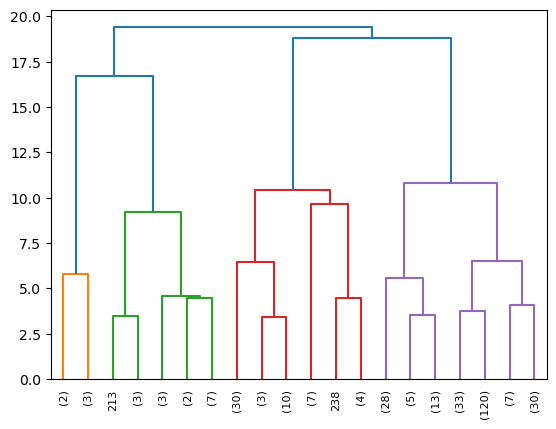

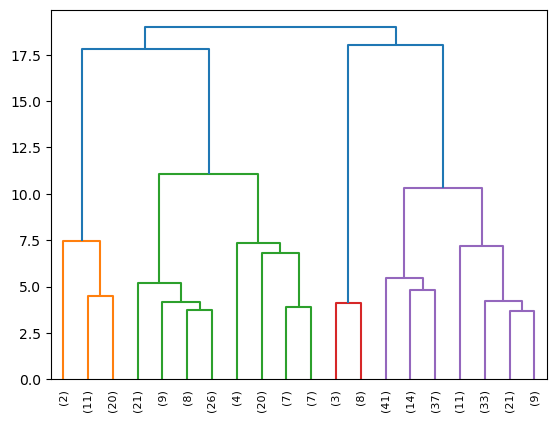

In [32]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

d_sample = 'euclidean' 
d_group = 'ward' 
N_leafs = 20 

Z1 = linkage(X1, method=d_group, metric=d_sample) #method denotes cluster distance, metric denotes sample distance

den = dendrogram(
    Z1,
    leaf_rotation=90.,
    leaf_font_size=8.,
    truncate_mode='lastp',
    p = N_leafs,
)
plt.show()

Z2 = linkage(X2, method=d_group, metric=d_sample) #method denotes cluster distance, metric denotes sample distance

den = dendrogram(
    Z2,
    leaf_rotation=90.,
    leaf_font_size=8.,
    truncate_mode='lastp',
    p = N_leafs,
)

plt.show()

Z3 = linkage(X3, method=d_group, metric=d_sample) #method denotes cluster distance, metric denotes sample distance

den = dendrogram(
    Z3,
    leaf_rotation=90.,
    leaf_font_size=8.,
    truncate_mode='lastp',
    p = N_leafs,
)

plt.show()

Z4 = linkage(X4, method=d_group, metric=d_sample) #method denotes cluster distance, metric denotes sample distance

den = dendrogram(
    Z4,
    leaf_rotation=90.,
    leaf_font_size=8.,
    truncate_mode='lastp',
    p = N_leafs,
)

plt.show()

Z5 = linkage(X5, method=d_group, metric=d_sample) #method denotes cluster distance, metric denotes sample distance

den = dendrogram(
    Z5,
    leaf_rotation=90.,
    leaf_font_size=8.,
    truncate_mode='lastp',
    p = N_leafs,
)

plt.show()



# plot the silhouette score for featuresHR, featuresTEMP, featuresEDA_P, featuresEDA_T
# fig, ax = plt.subplots(1, 5, figsize=(30, 8))


In [33]:
#look at the individual clusters
k1=4 #Number of clusters. Determine a usable number from dendrogram
k2=4
k3=4
k4=4
k5=4

cluster_designation1 = fcluster(Z1, k1, criterion='maxclust') #Get cluster designation of data points
cluster_designation2 = fcluster(Z2, k2, criterion='maxclust') #Get cluster designation of data points
cluster_designation3 = fcluster(Z3, k3, criterion='maxclust') #Get cluster designation of data points
cluster_designation4 = fcluster(Z4, k4, criterion='maxclust') #Get cluster designation of data points
cluster_designation5 = fcluster(Z5, k5, criterion='maxclust') #Get cluster designation of data points


hr_data1['ClusterAll_ica_hc'] = cluster_designation5
hr_data1['ClusterTEMP_ica_hc'] = cluster_designation2
hr_data1['ClusterEDA_P_ica_hc'] = cluster_designation3
hr_data1['ClusterEDA_T_ica_hc'] = cluster_designation4
hr_data1['ClusterHR_ica_hc'] = cluster_designation1


# GMM Clustering

c:\Users\mario\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\mario\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\mario\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\mario\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Window

c:\Users\mario\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\mario\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\mario\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\mario\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Window

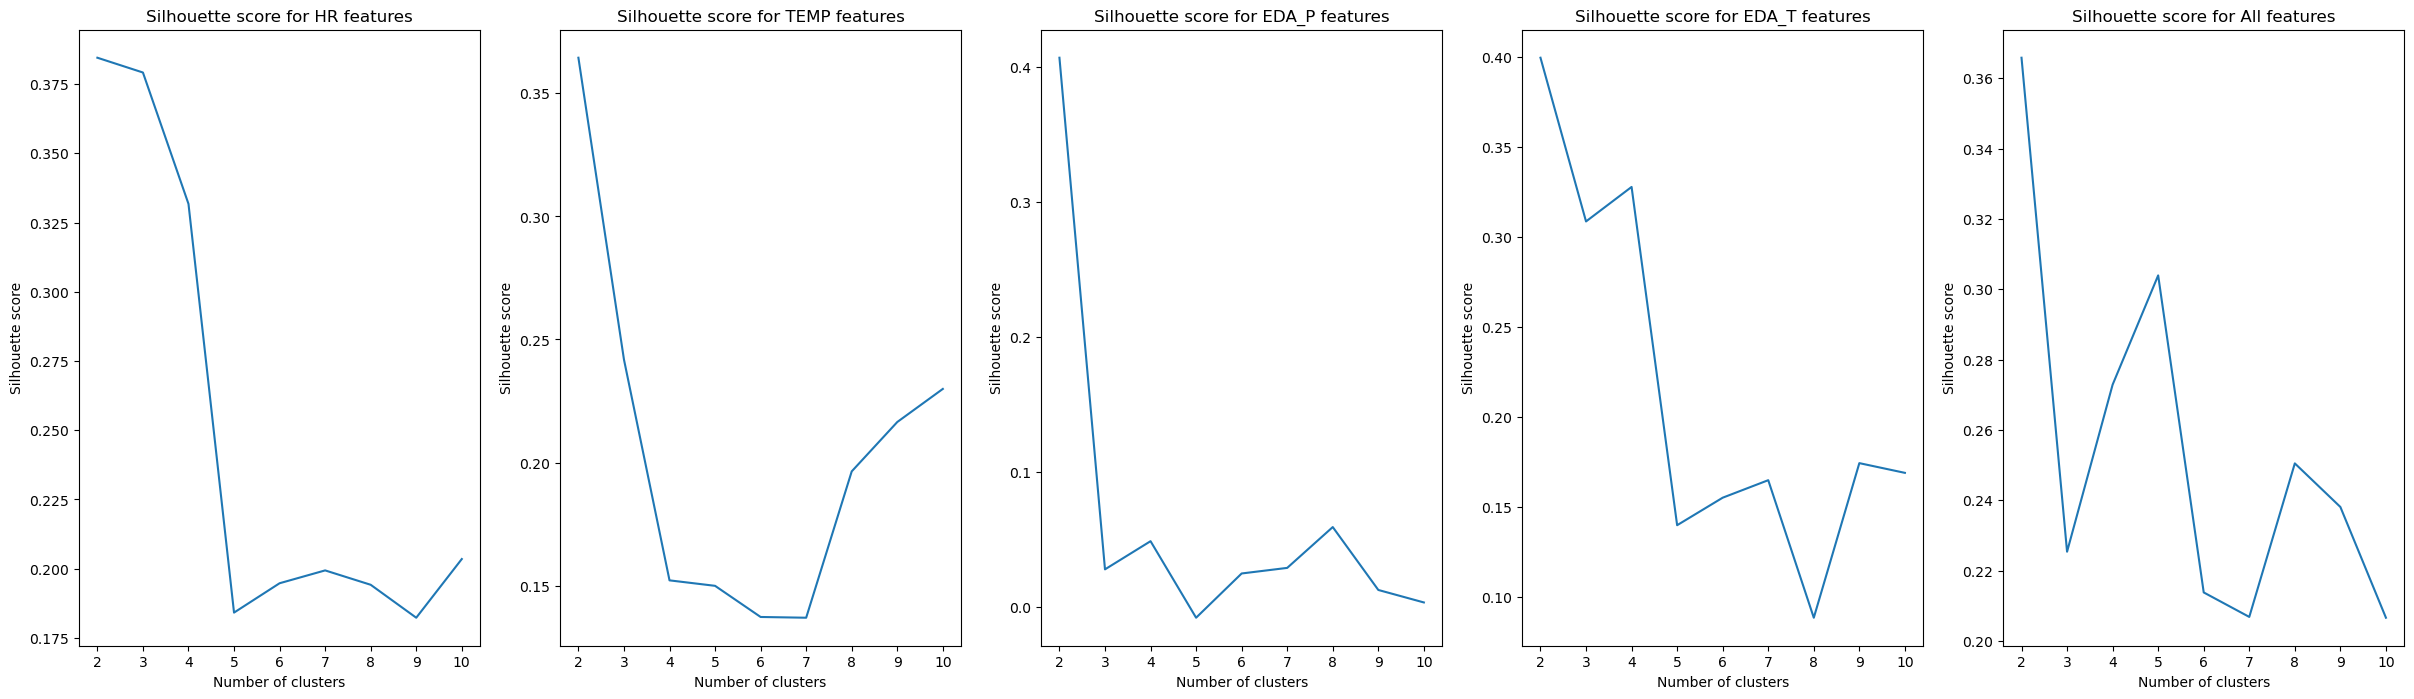

In [34]:
from sklearn.mixture import GaussianMixture


# shilouette score for featuresHR, featuresTEMP, featuresEDA_P, featuresEDA_T, hr_data_preprocessed with 2 to 10 clusters
silhouette_scoresHR = []
for i in range(2, 11):
    kmeans = GaussianMixture(n_components=i, random_state=0)
    kmeans.fit(featuresHR_ica)
    silhouette_scoresHR.append(silhouette_score(featuresHR_ica, kmeans.predict(featuresHR_ica)))

silhouette_scoresTEMP = []
for i in range(2, 11):
    kmeans = GaussianMixture(n_components=i, random_state=0)
    kmeans.fit(featuresTEMP_ica)
    silhouette_scoresTEMP.append(silhouette_score(featuresTEMP_ica, kmeans.predict(featuresTEMP_ica)))

silhouette_scoresEDA_P = []
for i in range(2, 11):
    kmeans = GaussianMixture(n_components=i, random_state=0)
    kmeans.fit(featuresEDA_P_ica)
    silhouette_scoresEDA_P.append(silhouette_score(featuresEDA_P_ica, kmeans.predict(featuresEDA_P_ica)))

silhouette_scoresEDA_T = []
for i in range(2, 11):
    kmeans = GaussianMixture(n_components=i, random_state=0)
    kmeans.fit(featuresEDA_T_ica)
    silhouette_scoresEDA_T.append(silhouette_score(featuresEDA_T_ica, kmeans.predict(featuresEDA_T_ica)))

silhouette_scoresAll = []
for i in range(2, 11):
    kmeans = GaussianMixture(n_components=i, random_state=0)
    kmeans.fit(hr_data_preprocessed_ica)
    silhouette_scoresAll.append(silhouette_score(hr_data_preprocessed_ica, kmeans.predict(hr_data_preprocessed_ica)))

# plot the silhouette score for featuresHR, featuresTEMP, featuresEDA_P, featuresEDA_T
fig, ax = plt.subplots(1, 5, figsize=(30, 8))
ax[0].plot(range(2, 11), silhouette_scoresHR)
ax[0].set_xlabel('Number of clusters')
ax[0].set_ylabel('Silhouette score')
ax[0].set_title('Silhouette score for HR features')

ax[1].plot(range(2, 11), silhouette_scoresTEMP)
ax[1].set_xlabel('Number of clusters')
ax[1].set_ylabel('Silhouette score')
ax[1].set_title('Silhouette score for TEMP features')

ax[2].plot(range(2, 11), silhouette_scoresEDA_P)
ax[2].set_xlabel('Number of clusters')
ax[2].set_ylabel('Silhouette score')
ax[2].set_title('Silhouette score for EDA_P features')

ax[3].plot(range(2, 11), silhouette_scoresEDA_T)
ax[3].set_xlabel('Number of clusters')
ax[3].set_ylabel('Silhouette score')
ax[3].set_title('Silhouette score for EDA_T features')

ax[4].plot(range(2, 11), silhouette_scoresAll)
ax[4].set_xlabel('Number of clusters')
ax[4].set_ylabel('Silhouette score')
ax[4].set_title('Silhouette score for All features')
plt.show()

> ## featuresHR_pca

c:\Users\mario\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


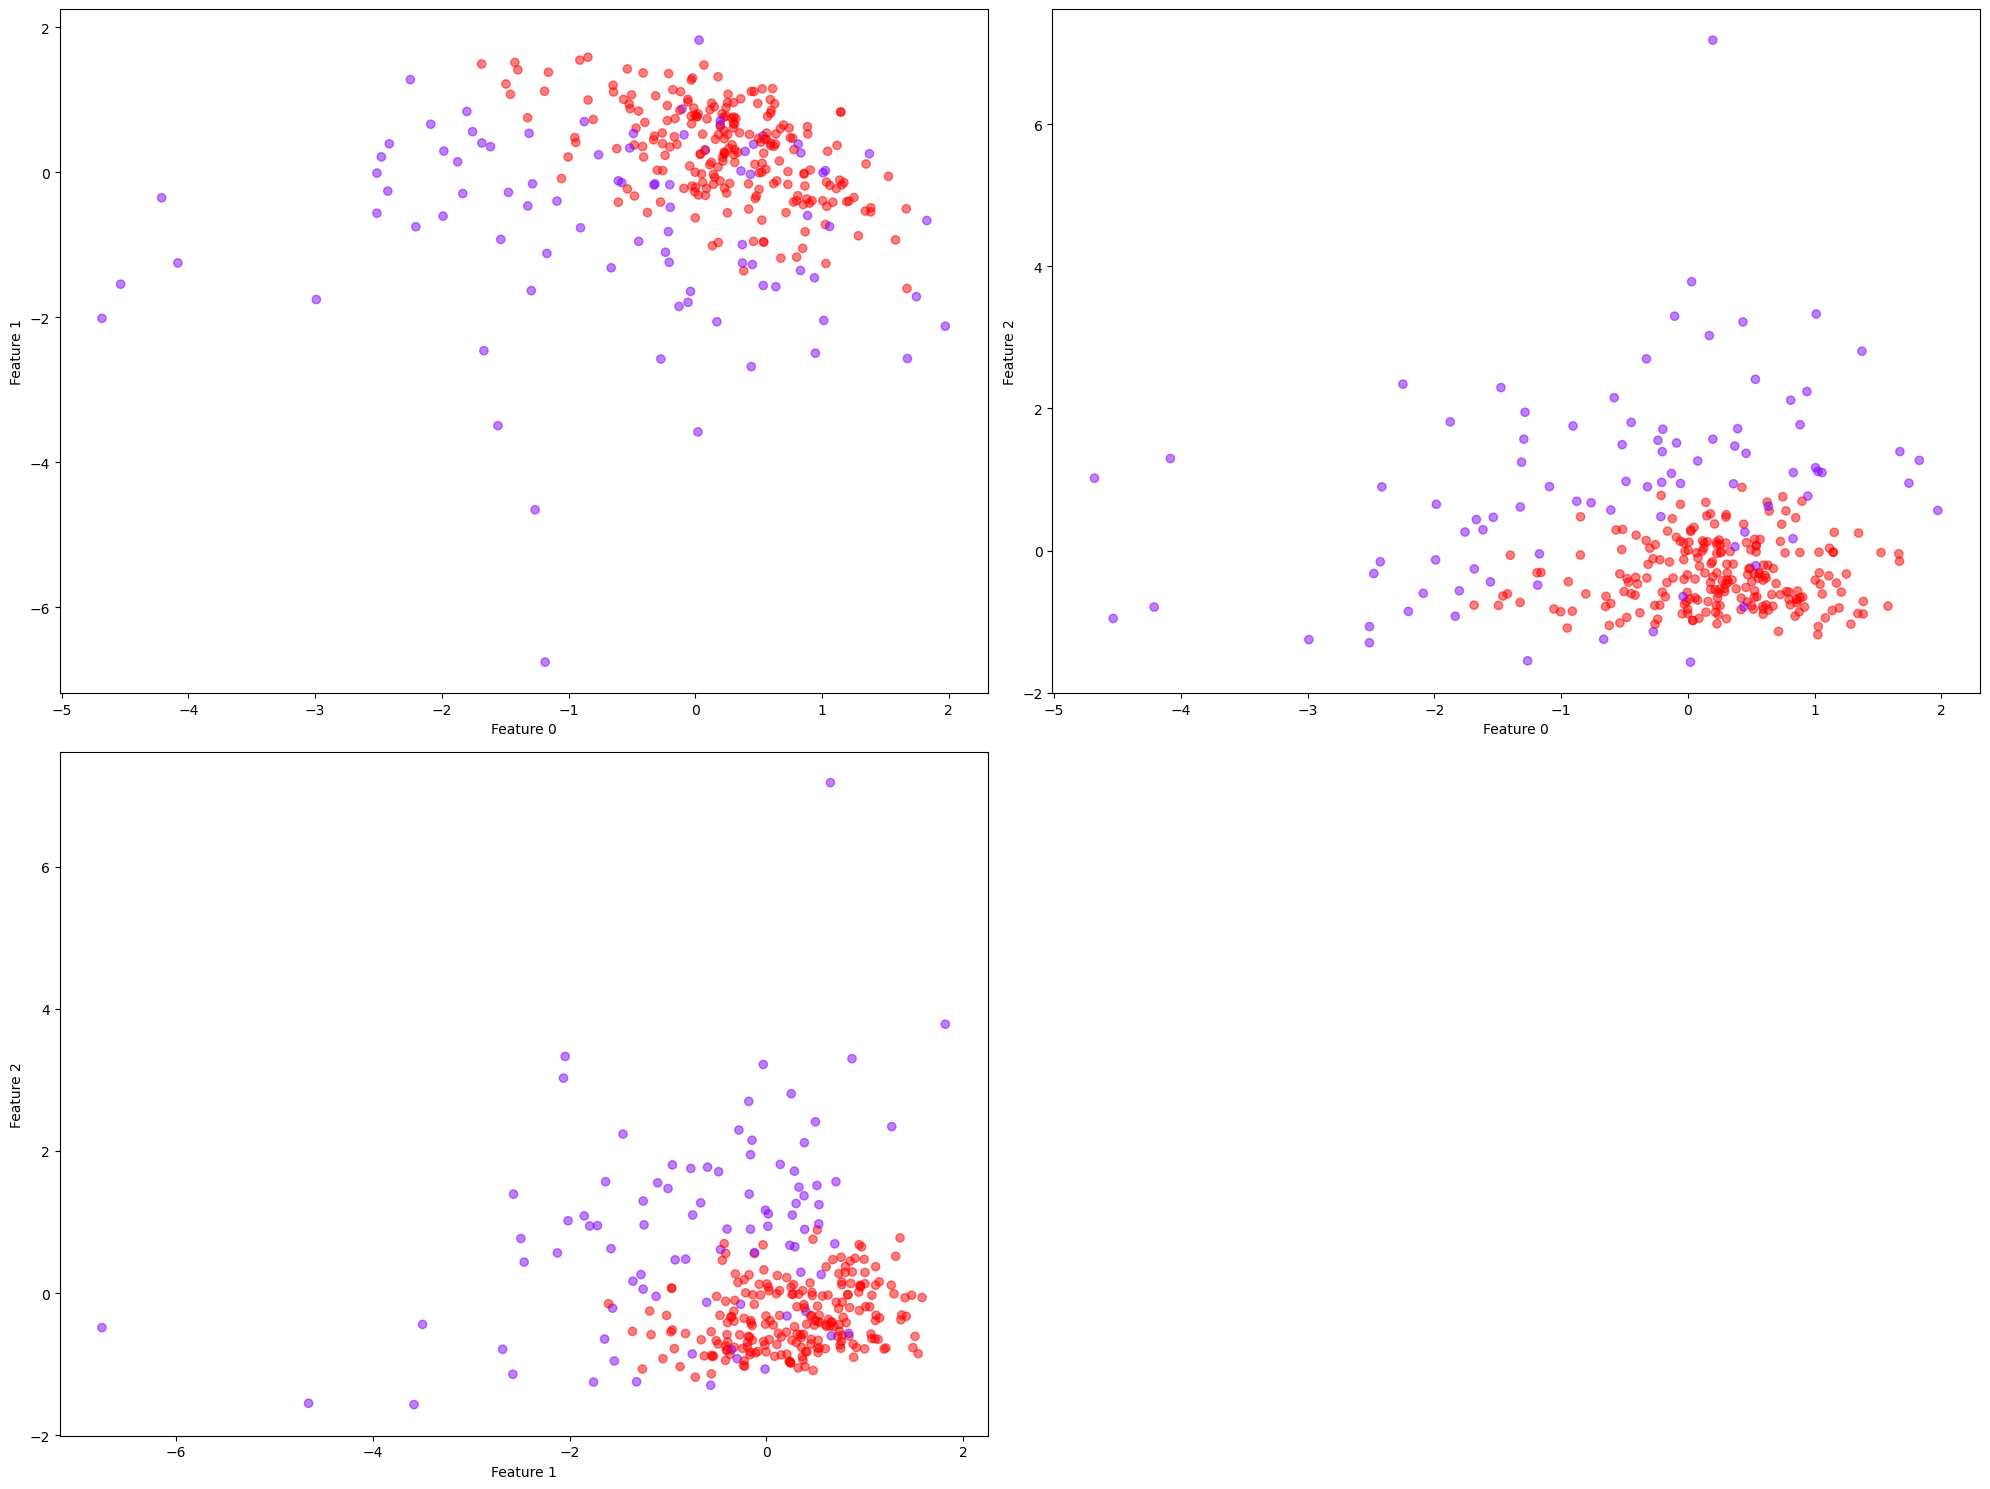

In [35]:
# k means clustering for the optimal number of clusters
kmeans = GaussianMixture(n_components=2).fit(X1)
# C = kmeans.cluster_centers_ # the cluster centers in the p dimensions
labelCluster = kmeans.predict(X1) # the labelling for each point

# Number of features in X1
num_features = X1.shape[1]

# Determine the number of rows and columns for the subplots based on the number of features
n_plots = num_features * (num_features - 1) // 2  # Total number of plots needed
n_cols = int(num_features - 1)  # Number of columns (one less than the number of features)
n_rows = int(np.ceil(n_plots / n_cols))  # Number of rows of plots

fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, 15))

# Flatten the array of axes for easy indexing
axs = axs.flatten()

# Counter for the subplot index
plot_number = 0

for i in range(num_features):
    for j in range(i + 1, num_features):
        axs[plot_number].scatter(X1[:, i], X1[:, j], c=labelCluster, cmap='rainbow', alpha=0.5)
        # axs[plot_number].scatter(C[:, i], C[:, j], marker='x', color='black', s=100)
        axs[plot_number].set_xlabel(f'Feature {i}')
        axs[plot_number].set_ylabel(f'Feature {j}')
        plot_number += 1

# Hide any unused subplots
for i in range(plot_number, n_rows * n_cols):
    fig.delaxes(axs[i])

plt.tight_layout()
plt.show()

# label clusterHR
hr_data1['ClusterHR_ica_GMM'] = labelCluster

> ## featuresTEMP

c:\Users\mario\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


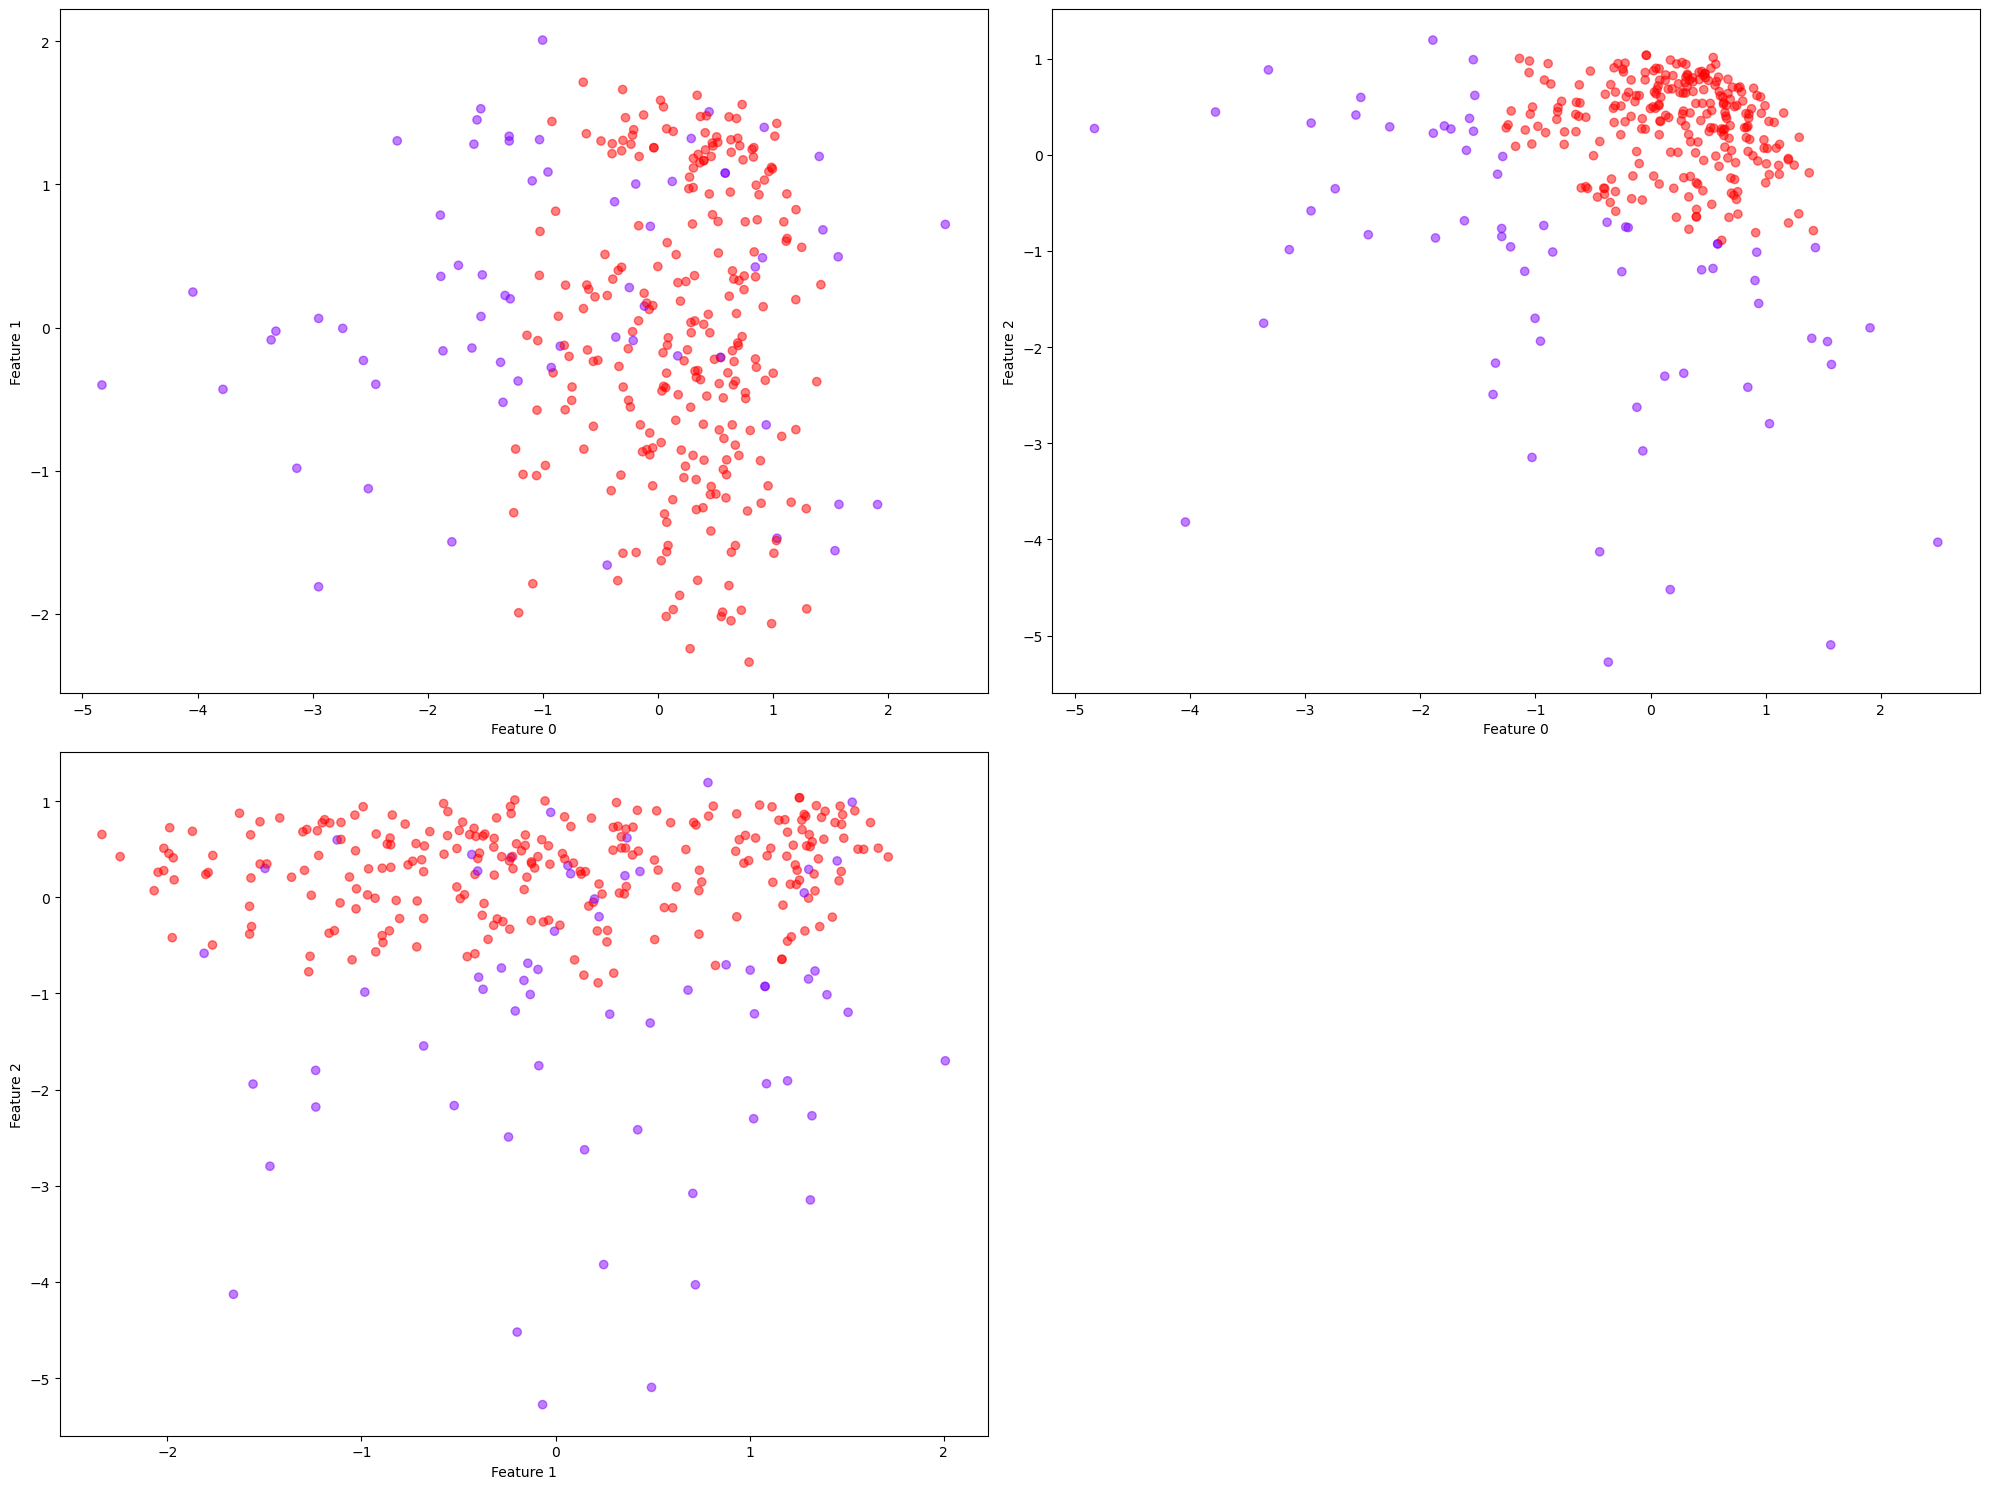

In [36]:
# k means clustering for the optimal number of clusters
kmeans = GaussianMixture(n_components=2).fit(X2)
# C = kmeans.predict # the cluster centers in the p dimensions
labelCluster = kmeans.predict(X2) # the labelling for each point

# Number of features in X2
num_features = X2.shape[1]

# Determine the number of rows and columns for the subplots based on the number of features
n_plots = num_features * (num_features - 1) // 2  # Total number of plots needed
n_cols = int(num_features - 1)  # Number of columns (one less than the number of features)
n_rows = int(np.ceil(n_plots / n_cols))  # Number of rows of plots

fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, 15))

# Flatten the array of axes for easy indexing
axs = axs.flatten()

# Counter for the subplot index
plot_number = 0

for i in range(num_features):
    for j in range(i + 1, num_features):
        axs[plot_number].scatter(X2[:, i], X2[:, j], c=labelCluster, cmap='rainbow', alpha=0.5)
        # axs[plot_number].scatter(C[:, i], C[:, j], marker='x', color='black', s=100)
        axs[plot_number].set_xlabel(f'Feature {i}')
        axs[plot_number].set_ylabel(f'Feature {j}')
        plot_number += 1

# Hide any unused subplots
for i in range(plot_number, n_rows * n_cols):
    fig.delaxes(axs[i])

plt.tight_layout()
plt.show()

# label clusterTEMP
hr_data1['ClusterTEMP_ica_GMM'] = labelCluster


> ## featuresEDA_P

c:\Users\mario\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


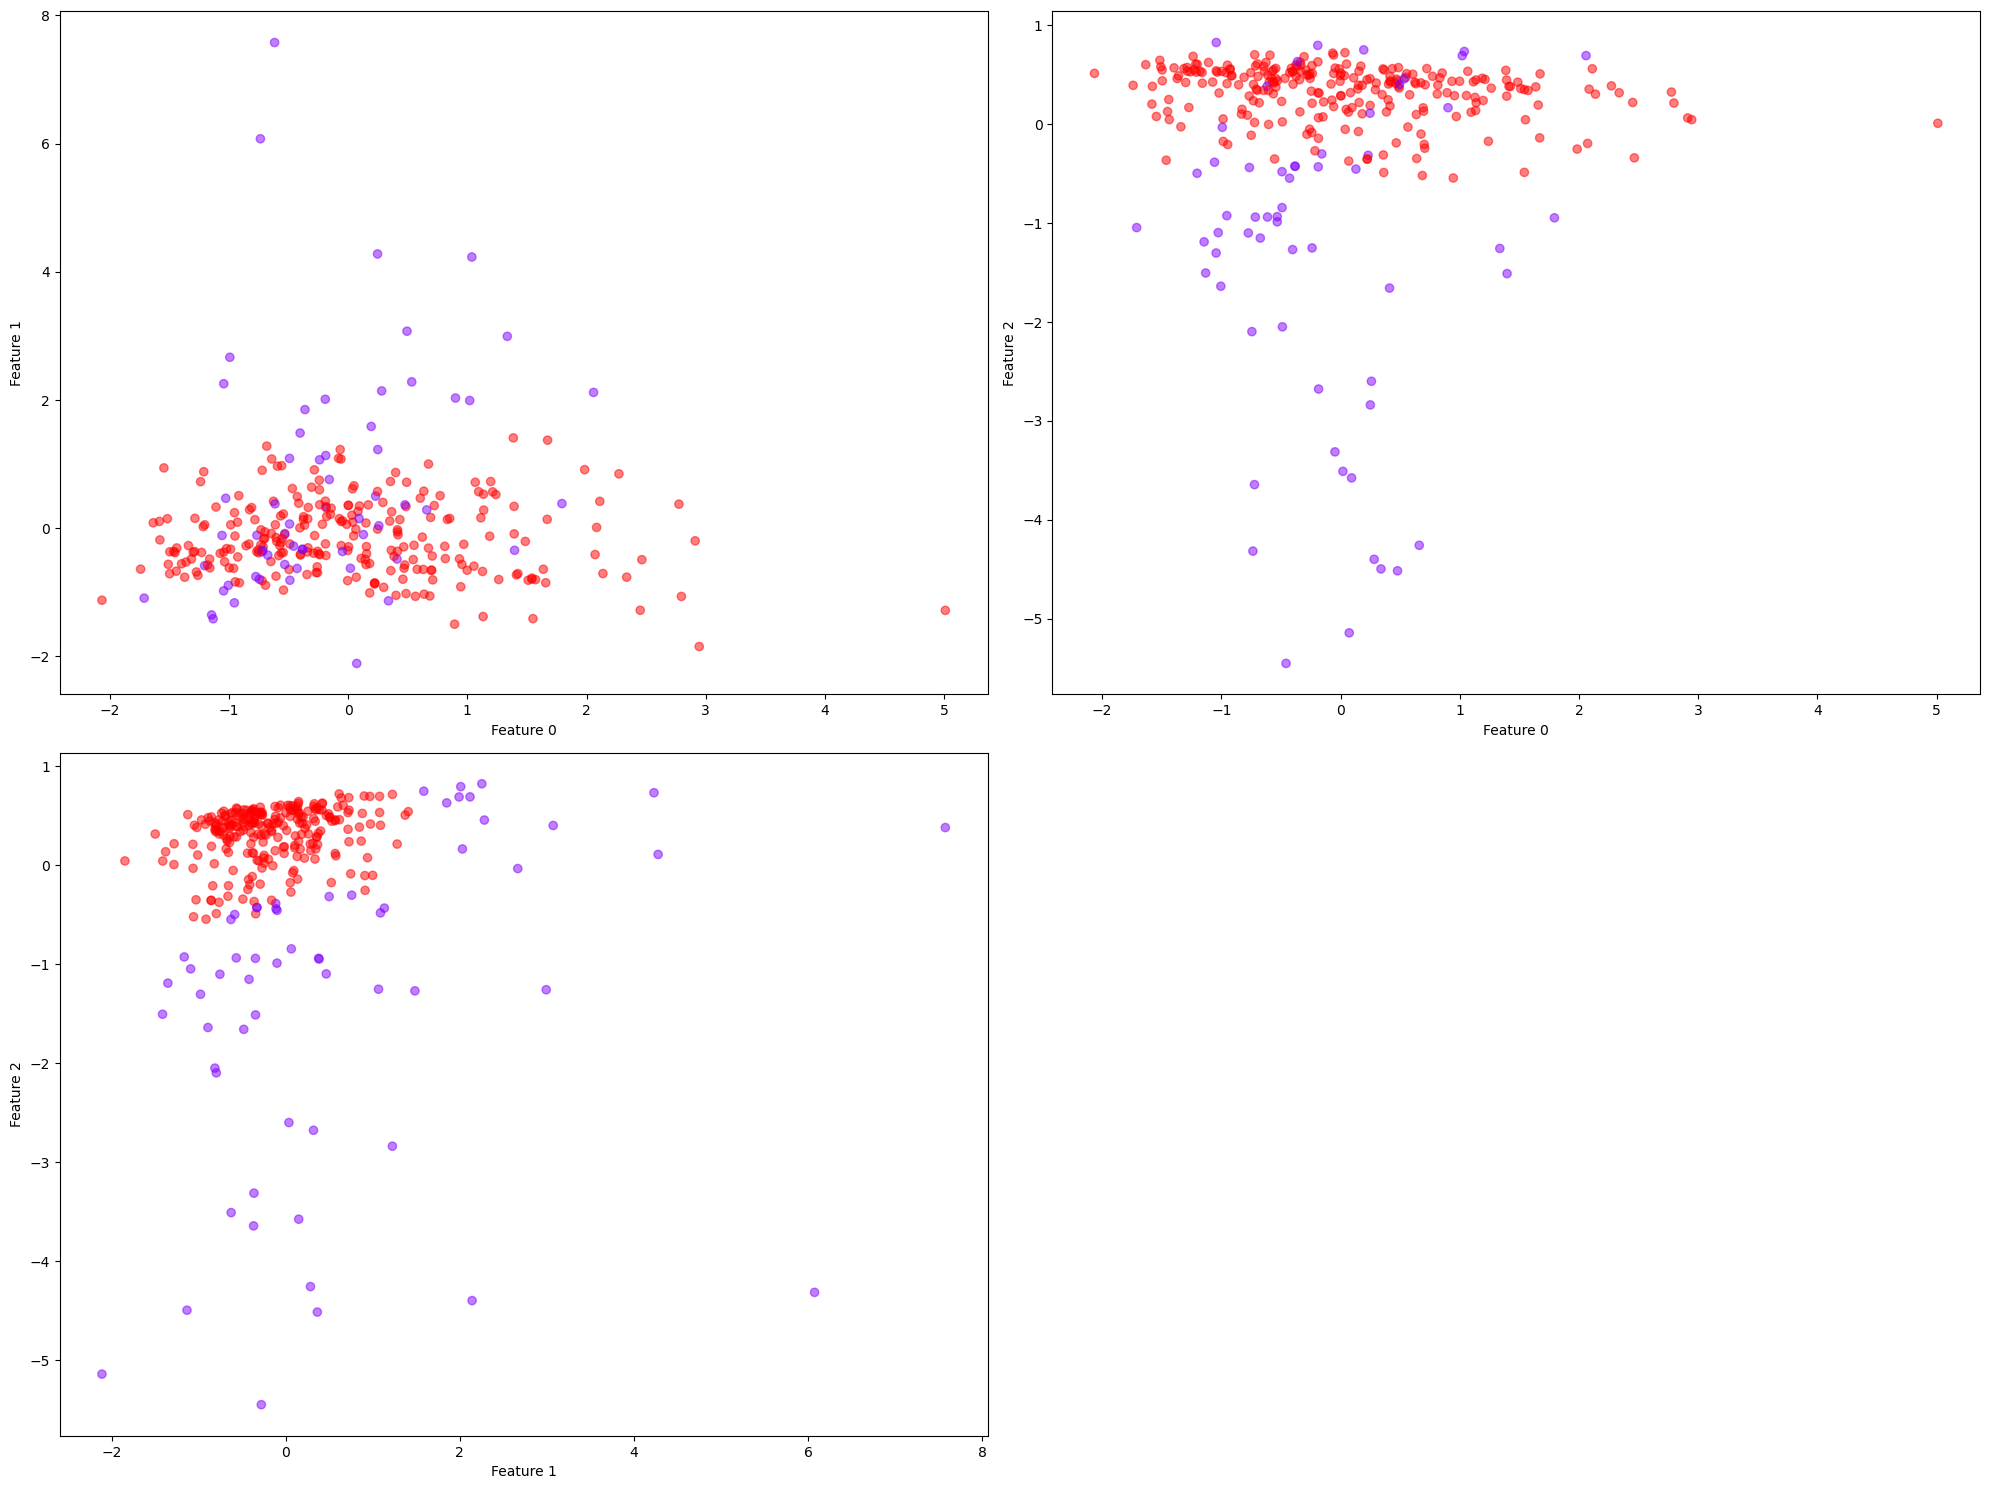

In [37]:
# k means clustering for the optimal number of clusters
kmeans = GaussianMixture(n_components=2).fit(X3)
# C = kmeans.cluster_centers_ # the cluster centers in the p dimensions
labelCluster = kmeans.predict(X3) # the labelling for each point

# Number of features in X3
num_features = X3.shape[1]

# Determine the number of rows and columns for the subplots based on the number of features
n_plots = num_features * (num_features - 1) // 2  # Total number of plots needed
n_cols = int(num_features - 1)  # Number of columns (one less than the number of features)
n_rows = int(np.ceil(n_plots / n_cols))  # Number of rows of plots

fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, 15))

# Flatten the array of axes for easy indexing
axs = axs.flatten()

# Counter for the subplot index
plot_number = 0

for i in range(num_features):
    for j in range(i + 1, num_features):
        axs[plot_number].scatter(X3[:, i], X3[:, j], c=labelCluster, cmap='rainbow', alpha=0.5)
        # axs[plot_number].scatter(C[:, i], C[:, j], marker='x', color='black', s=100)
        axs[plot_number].set_xlabel(f'Feature {i}')
        axs[plot_number].set_ylabel(f'Feature {j}')
        plot_number += 1

# Hide any unused subplots
for i in range(plot_number, n_rows * n_cols):
    fig.delaxes(axs[i])

plt.tight_layout()
plt.show()

# label clusterEDA_P
hr_data1['ClusterEDA_P_ica_GMM'] = labelCluster

> ## featuresEDA_T

c:\Users\mario\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


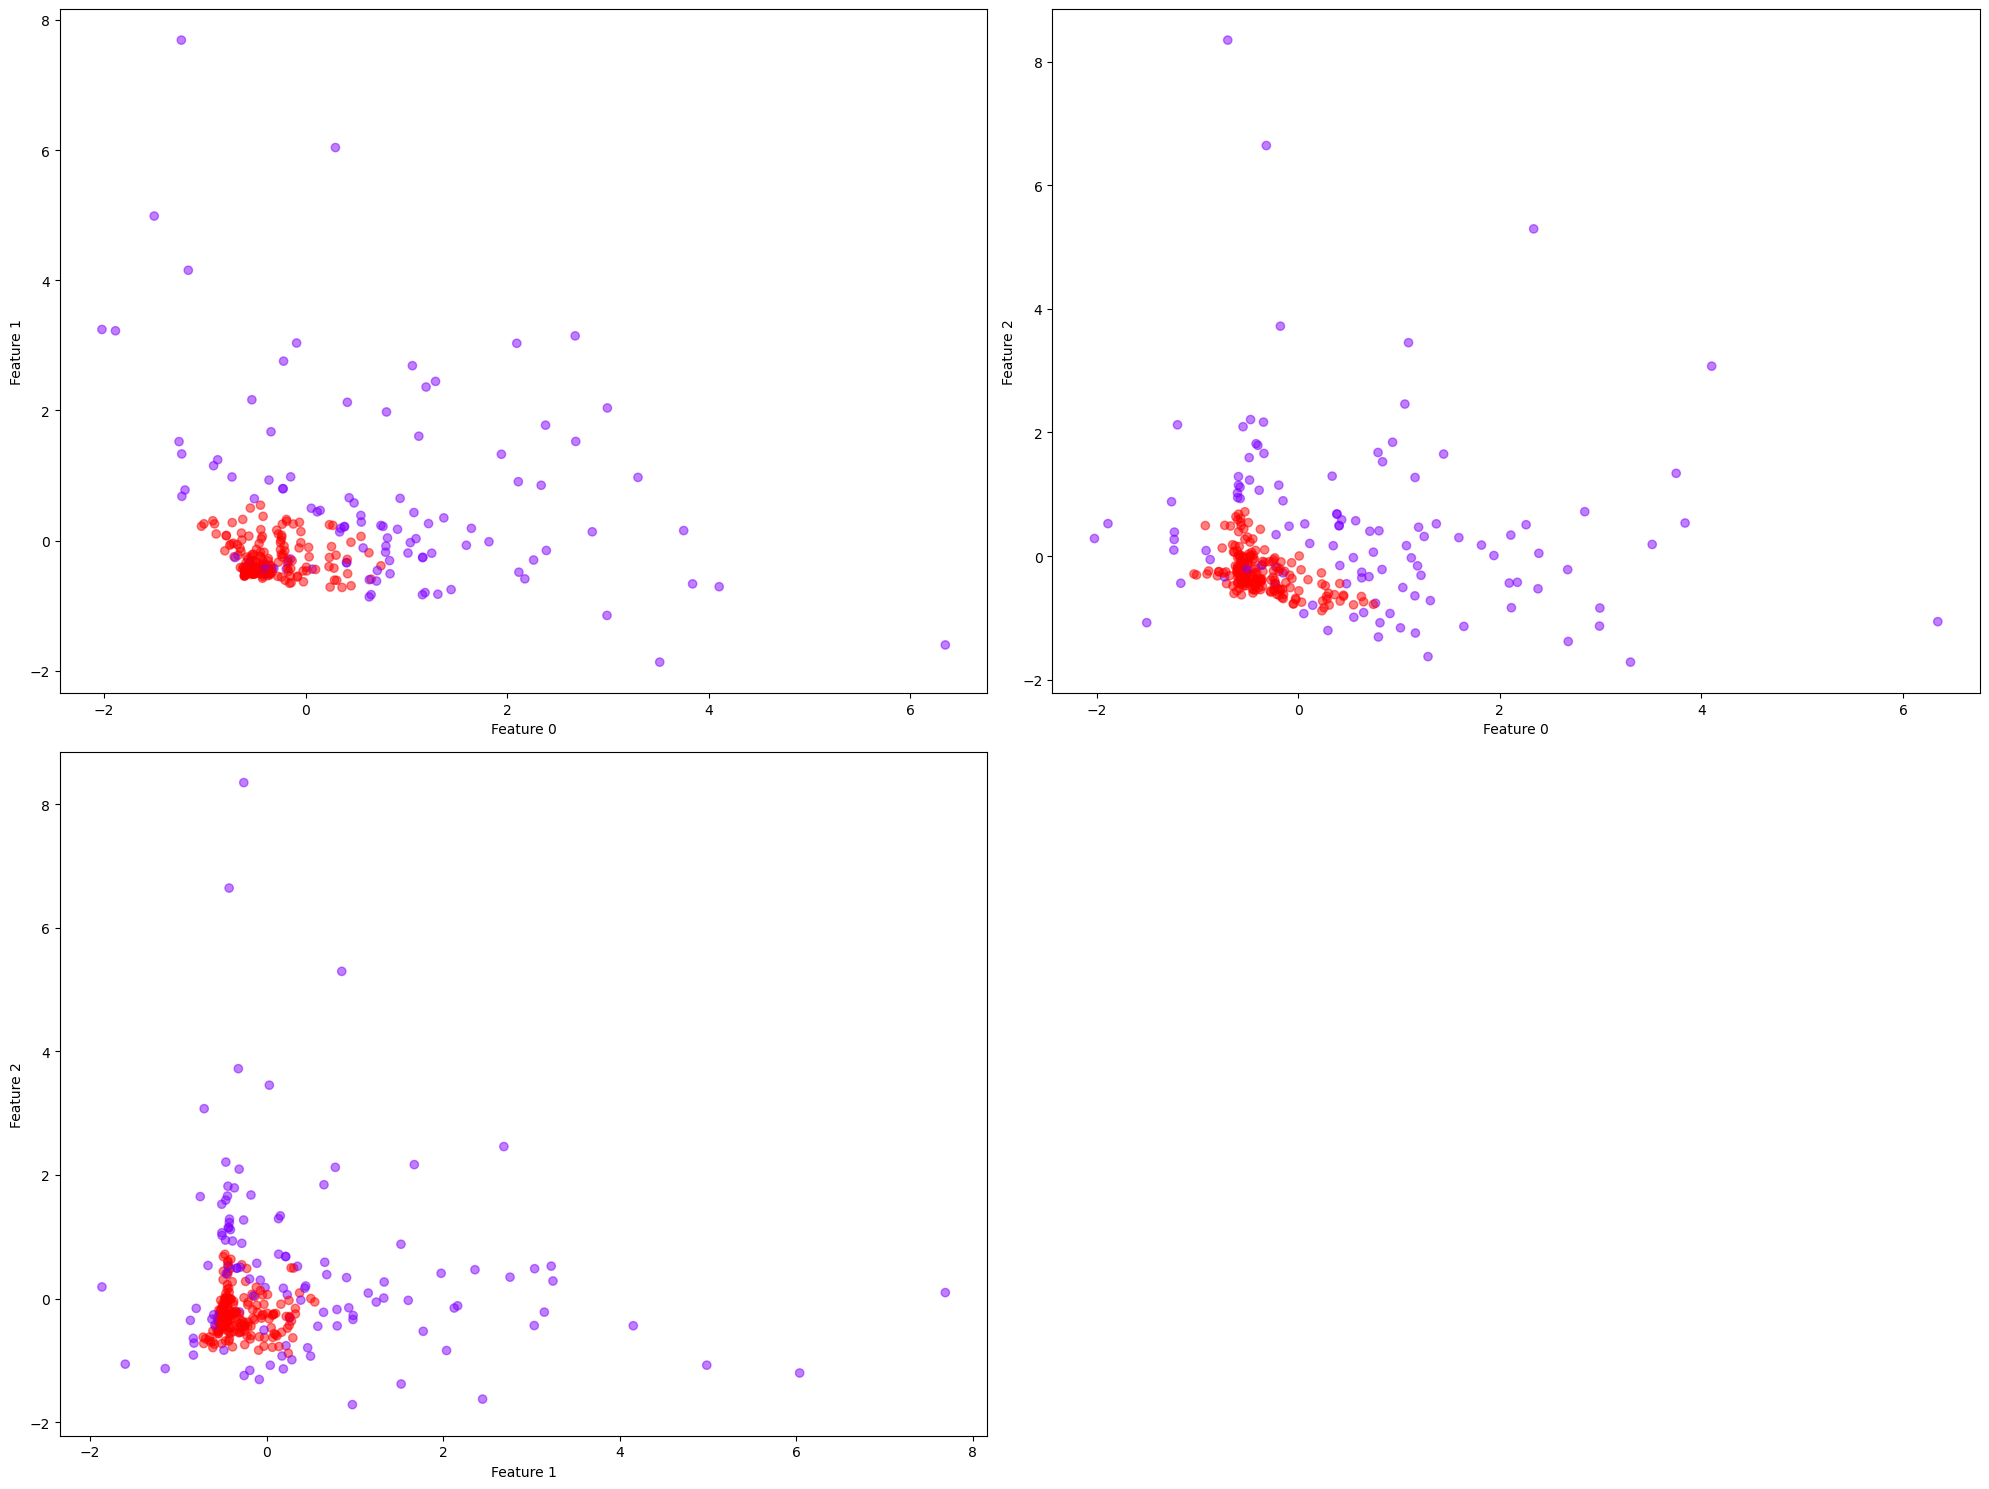

In [38]:
# k means clustering for the optimal number of clusters
kmeans = GaussianMixture(n_components=2).fit(X4)
# C = kmeans.cluster_centers_ # the cluster centers in the p dimensions
labelCluster = kmeans.predict(X4) # the labelling for each point

# Number of features in X4
num_features = X4.shape[1]

# Determine the number of rows and columns for the subplots based on the number of features
n_plots = num_features * (num_features - 1) // 2  # Total number of plots needed
n_cols = int(num_features - 1)  # Number of columns (one less than the number of features)
n_rows = int(np.ceil(n_plots / n_cols))  # Number of rows of plots

fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, 15))

# Flatten the array of axes for easy indexing
axs = axs.flatten()

# Counter for the subplot index
plot_number = 0

for i in range(num_features):
    for j in range(i + 1, num_features):
        axs[plot_number].scatter(X4[:, i], X4[:, j], c=labelCluster, cmap='rainbow', alpha=0.5)
        # axs[plot_number].scatter(C[:, i], C[:, j], marker='x', color='black', s=100)
        axs[plot_number].set_xlabel(f'Feature {i}')
        axs[plot_number].set_ylabel(f'Feature {j}')
        plot_number += 1

# Hide any unused subplots
for i in range(plot_number, n_rows * n_cols):
    fig.delaxes(axs[i])

plt.tight_layout()
plt.show()

# label clusterEDA_T
hr_data1['ClusterEDA_T_ica_GMM'] = labelCluster

> ## hr_data_preprocessed

c:\Users\mario\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


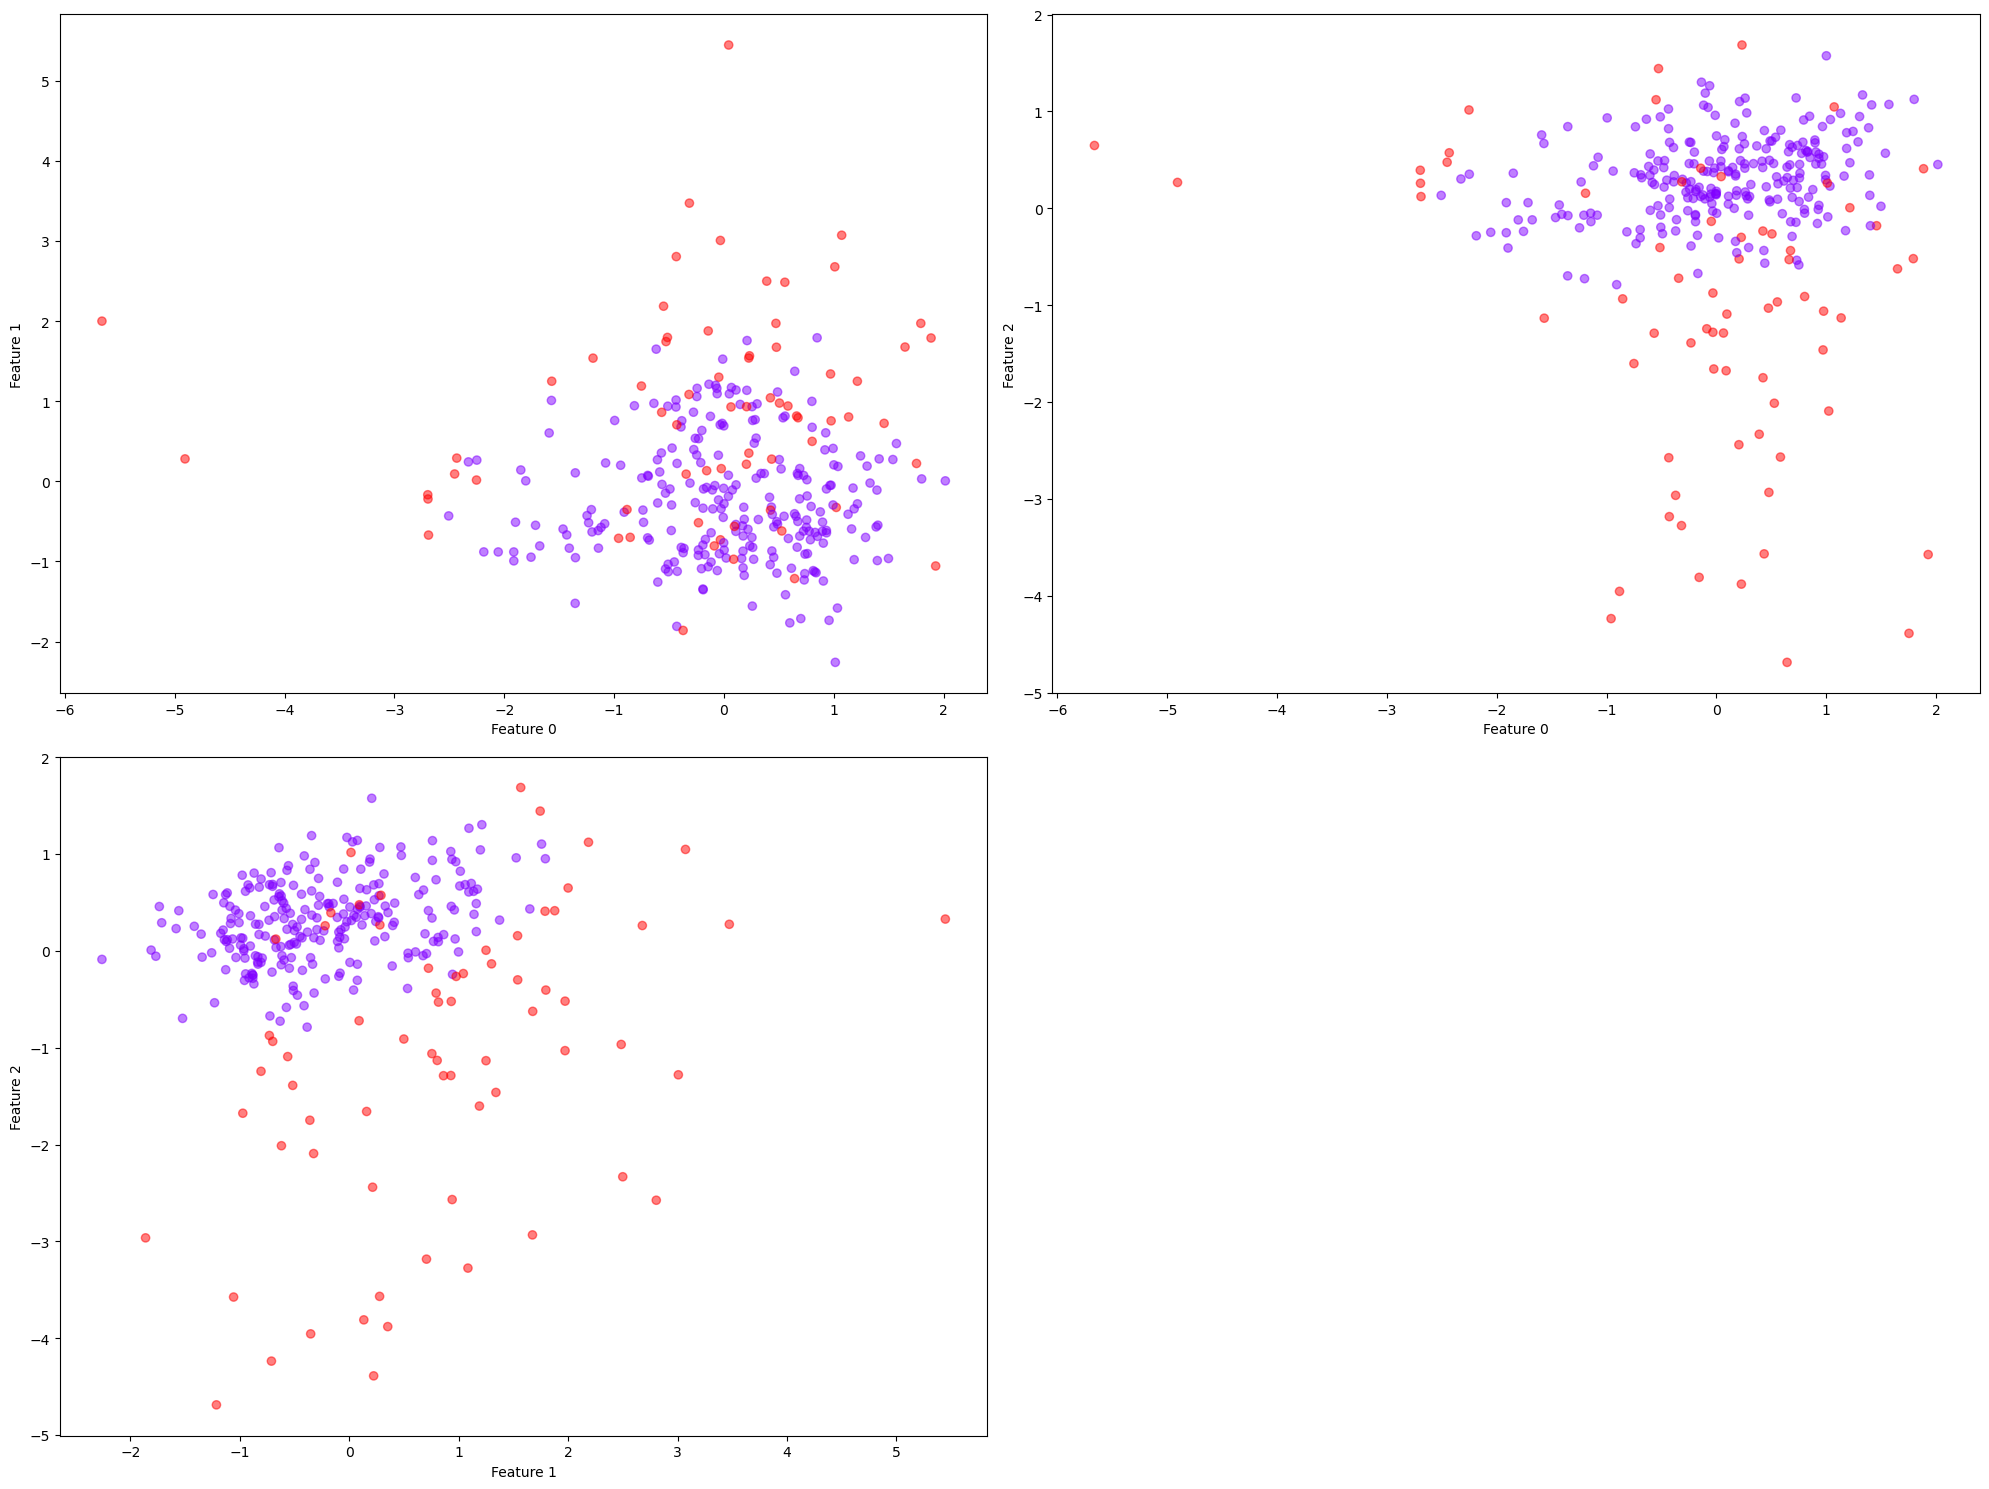

In [39]:

# k means clustering for the optimal number of clusters
kmeans = GaussianMixture(n_components=2).fit(X5)
# C = kmeans.cluster_centers_ # the cluster centers in the p dimensions

labelCluster = kmeans.predict(X5) # the labelling for each point

# Number of features in X5
num_features = X5.shape[1]

# Determine the number of rows and columns for the subplots based on the number of features
n_plots = num_features * (num_features - 1) // 2  # Total number of plots needed
n_cols = int(num_features - 1)  # Number of columns (one less than the number of features)
n_rows = int(np.ceil(n_plots / n_cols))  # Number of rows of plots

fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, 15))

# Flatten the array of axes for easy indexing
axs = axs.flatten()

# Counter for the subplot index
plot_number = 0

for i in range(num_features):
    for j in range(i + 1, num_features):
        axs[plot_number].scatter(X5[:, i], X5[:, j], c=labelCluster, cmap='rainbow', alpha=0.5)
        # axs[plot_number].scatter(C[:, i], C[:, j], marker='x', color='black', s=100)
        axs[plot_number].set_xlabel(f'Feature {i}')
        axs[plot_number].set_ylabel(f'Feature {j}')
        plot_number += 1

# Hide any unused subplots
for i in range(plot_number, n_rows * n_cols):
    fig.delaxes(axs[i])

plt.tight_layout()
plt.show()

# label clusterAll
hr_data1['ClusterAll_ica_GMM'] = labelCluster